In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, balanced_accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE, SelectFromModel
import shap 
import river 
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

## 1. Load, Combine and Transform Data

In [84]:
# Load the dataset files 
customer_df = pd.read_csv('customer.csv')
loan_df = pd.read_csv('loan.csv')
state_df = pd.read_csv('state_region.csv')

In [85]:
# Merge customer and loan data on 'customer_id'
try:
    merged_df = pd.merge(customer_df, loan_df, on='customer_id', how='left')
except KeyError as e:
    print(f"Error merging dataframes: {e}. Please check if 'customer_id' column exists in both dataframes or adjust the merge key.")
    exit()

In [86]:
# Merge merged_df and state_df on 'state'
try:
    merged_df = pd.merge(merged_df, state_df, on='state', how='left')
except KeyError as e:
    print(f"Error merging dataframes: {e}. Please check if 'customer_id' column exists in both dataframes or adjust the merge key.")
    exit()

In [5]:
merged_df

customer_id  \
0       b'\xa0\xe6\x1a\xc8H\xbd/(T]\x13[\xf5\x0fK\xd9\...   
1       b'c\xe3S\xf0yY7\xba\xda\x16JF\xec\xbe\xc0mY\xd...   
2       b'1\xe3uD\xe4\x13\x1f\x80\x1d\xb1\xa5\x14x\xac...   
3       b'bb\xf1Y\x00\xaf\x96\x85\x16\xaf\xb4z\x1c\xa0...   
4       b'\xaazF\x84\x93\xa0w\xb5G\xed0\xd0\xd4\xd4\xc...   
...                                                   ...   
270294  b'dp\xe7\x0b\xf6\x1b\x0b^\xa7/\xfa\xc4\x84\x1b...   
270295  b"%(\xb6\xa9|D\x9an\x82\xd4Z\r\x9aB\xe8\x93!\x...   
270296  b'nW\xbb\xdd{(\xf4\xed\xa5G9\x97Rq\xd4vg\xc7\x...   
270297  b'-\xbf\x0bF\x91\xa6j\xa5l\xe0D\x06c\xa3\xd0\x...   
270298  b'\xbd\x91sr\x84B\xd6\x81J\xa6\xc4\x8e\x91\x1b...   

                                       emp_title emp_length home_ownership  \
0                                            NaN        NaN           RENT   
1                                            NaN        NaN       MORTGAGE   
2                                     Care Giver        NaN            OWN   
3                                            NaN        NaN            OWN   
4                                            NaN        NaN            OWN   
...                                          ...        ...            ...   
270294                                 Carpenter  10+ years       MORTGAGE   
270295               Assistant attorney general   10+ years       MORTGAGE   
270296                Surface Equipment Operator  10+ years       MORTGAGE   
270297  Coordinator of Counseling and Disability  10+ years       MORTGAGE   
270298                                     Cook   10+ years            OWN   

        annual_inc  annual_inc_joint verification_status zip_code addr_state  \
0        25000.000               NaN            Verified    010xx         MA   
1        50000.000               NaN        Not Verified    010xx         MA   
2        46800.000               NaN            Verified    010xx         MA   
3        65000.000               NaN            Verified    010xx         MA   
4        49200.000               NaN     Source Verified    010xx         MA   
...            ...               ...                 ...      ...        ...   
270294   64147.199       128294.3984     Source Verified    998xx         AK   
270295   80000.000               NaN        Not Verified    998xx         AK   
270296   80000.000               NaN        Not Verified    998xx         AK   
270297   72000.000               NaN     Source Verified    998xx         AK   
270298   48000.000               NaN        Not Verified    999xx         AK   

        avg_cur_bal  ...  issue_d      issue_date  issue_year pymnt_plan  \
0            6864.0  ...   Apr-17      April 2017      2017.0      False   
1            3418.0  ...   Nov-17   November 2017      2017.0      False   
2           48173.0  ...   Dec-14   December 2014      2014.0      False   
3            2587.0  ...   Jan-16    January 2016      2016.0      False   
4             738.0  ...   Sep-18  September 2018      2018.0      False   
...             ...  ...      ...             ...         ...        ...   
270294      15239.0  ...   May-19        May 2019      2019.0      False   
270295      26890.0  ...   Jun-19       June 2019      2019.0      False   
270296      92942.0  ...   Mar-16      March 2016      2016.0      False   
270297      17358.0  ...   Nov-17   November 2017      2017.0      False   
270298      78331.0  ...   Sep-19  September 2019      2019.0      False   

              type             purpose              description notes  \
0       Individual         credit_card  Credit card refinancing  desc   
1       Individual    home_improvement         Home improvement  desc   
2       INDIVIDUAL  debt_consolidation       Debt consolidation  desc   
3       INDIVIDUAL         credit_card  Credit card refinancing  desc   
4       Individual         credit_card  Credit card refinancing  desc   
...            ...                 ...                      ... 

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270299 entries, 0 to 270298
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   customer_id          270299 non-null  object 
 1   emp_title            246637 non-null  object 
 2   emp_length           251554 non-null  object 
 3   home_ownership       270299 non-null  object 
 4   annual_inc           270299 non-null  float64
 5   annual_inc_joint     18794 non-null   float64
 6   verification_status  270299 non-null  object 
 7   zip_code             270299 non-null  object 
 8   addr_state           270299 non-null  object 
 9   avg_cur_bal          270299 non-null  float64
 10  Tot_cur_bal          270299 non-null  float64
 11  profession           270299 non-null  object 
 12  loan_id              270299 non-null  int64  
 13  loan_status          270299 non-null  object 
 14  loan_amount          270299 non-null  float64
 15  state            

The columns 'issue_d' and 'issue_date' contain datetime information but are currently stored as objects. They need to be converted to the datetime data type and then extracted into separate columns for month, quarter, and year. Additionally, since these two columns contain the same information, one of them can be removed to optimize the dataset.

In [87]:
# Convert to datetime
merged_df['issue_d'] = pd.to_datetime(merged_df['issue_d'], format='%b-%y')
# Extract month, quarter, year from date
merged_df['issue_month'] = merged_df['issue_d'].dt.month
merged_df['issue_quarter'] = merged_df['issue_d'].dt.quarter
merged_df['issue_year_num'] = merged_df['issue_d'].dt.year

In [8]:
# Validate check with issue_year
mismatched_years = merged_df[merged_df['issue_d'].dt.year != merged_df['issue_year'].astype(int)]
print(f"Number of mismatched years: {len(mismatched_years)}")

Number of mismatched years: 0


-> The 'year' information from 'issue_d' matches the data in the 'issue_year' column, so the 'issue_year' column can be removed to avoid data duplication.

In [9]:
# Check funded_amount and loan_amount:
if (merged_df['funded_amount'] == merged_df['loan_amount']).all():
    print('The two columns are containing the same data.')

The two columns are containing the same data.


-> The data in the 'funded_amount' column is identical to that in the 'loan_amount' column, so the 'funded_amount' column can be removed.

The 'emp_length' column represents a duration, which has a natural order and meaning → this is ordinal data, it should be treat as numerical data.

In [10]:
# Check data in the emp_length col:
merged_df['emp_length'].value_counts()

emp_length
10+ years    88549
< 1 year     24652
2 years      24036
3 years      21452
1 year       17722
5 years      16665
4 years      16207
6 years      11870
7 years      10823
8 years      10533
9 years       9045
Name: count, dtype: int64

In [88]:
# Clean the emp_length col
def clean_emp_length(val):
    if pd.isna(val):
        return np.nan 
    if val == '< 1 year':
        return 0
    if val == '10+ years':
        return 10
    return int(val.split()[0])

merged_df['emp_length'] = merged_df['emp_length'].apply(clean_emp_length)

When previewing the data, it can be seen that the data in the 'type' column also needs to be cleaned.

In [12]:
# Check data in the 'type' col:
merged_df['type'].value_counts()

type
Individual    169493
INDIVIDUAL     81709
Joint App      17931
JOINT            863
DIRECT_PAY       303
Name: count, dtype: int64

- 'Individual' and 'INDIVIDUAL' → same thing
- 'Joint App' and 'JOINT' → same thing

In [89]:
# Clean type col
def clean_type(val):
    if pd.isna(val):
        return 'UNKNOWN'
    val = val.strip().upper()
    if val in ['INDIVIDUAL']:
        return 'INDIVIDUAL'
    elif val in ['JOINT', 'JOINT APP']:
        return 'JOINT'
    elif val == 'DIRECT_PAY':
        return 'DIRECT_PAY'
    else:
        return 'OTHER'

merged_df['type'] = merged_df['type'].apply(clean_type)

Due to table merging, redundant columns were created. Specifically, the two columns 'state' and 'addr_state' are containing the same data.

In [14]:
# compare state vs addr_state
if (merged_df['state'] == merged_df['addr_state']).all():
    print('The two columns are containing the same data.')

The two columns are containing the same data.


Both 'zip_code', 'state' and 'subregion' contain geographic information. However, in this model, I only consider subregion-level areas and not smaller regions, so only the 'subregion' column will be retained.

The 'emp_title' column contains information about the customer's occupation. This data has been cleaned by processing the text, converting it into embeddings using SentenceTransformer, clustering the embeddings using KMeans, and labeling the clusters. The result of this process is the 'profession' column in the customer file. Therefore, the 'emp_title' column can be removed.

Drop redundant variables: 'customer_id', 'loan_id', 'emp_title', 'issue_d', 'issue_date', 'issue_year', 'funded_amount', 'addr_state', 'notes', 'description' and 'zip_code'

In [90]:
# Drop redundant column
merged_df = merged_df.drop(['customer_id', 'loan_id', 'emp_title', 'issue_d', 'issue_date', 'issue_year', 'funded_amount', 'addr_state', 'notes', 'description', 'zip_code', 'state', 'region'], axis=1)

The goal of this model is to predict good loan and bad loan based on the target variable 'loan_status'.

In [16]:
# Inspect unique values in 'loan_status' col to create the mapping.
print("\nUnique values in target variable:", merged_df['loan_status'].unique())


Unique values in target variable: ['Fully Paid' 'Current' 'Charged Off' 'Late (31-120 days)'
 'In Grace Period' 'Late (16-30 days)' 'Default']


The approach for this "Predict Credit Default" project is to transform it into a binary classification problem. I will group the statuses into two main categories:

1. **Default (Target = 1):** This includes statuses: 'Charged Off', 'Default', and 'Late (31-120 days)'.
2. **Non-default (Target = 0):** This includes statuses: 'Fully Paid', 'Current', 'In Grace Period', and 'Late (16-30 days)'.

In [91]:
default = ['Charged Off', 'Default', 'Late (16-30 days)', 'Late (31-120 days)']
non_default = ['Fully Paid', 'Current', 'In Grace Period']

def map_loan_status(status):
    if status in default:
        return 1  # Default
    elif status in non_default:
        return 0  # Non-default
    else:
        return np.nan  # Unknown or to be excluded

merged_df['loan_status'] = merged_df['loan_status'].apply(map_loan_status)

In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270299 entries, 0 to 270298
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   emp_length           251554 non-null  float64
 1   home_ownership       270299 non-null  object 
 2   annual_inc           270299 non-null  float64
 3   annual_inc_joint     18794 non-null   float64
 4   verification_status  270299 non-null  object 
 5   avg_cur_bal          270299 non-null  float64
 6   Tot_cur_bal          270299 non-null  float64
 7   profession           270299 non-null  object 
 8   loan_status          270299 non-null  int64  
 9   loan_amount          270299 non-null  float64
 10  term                 270299 non-null  object 
 11  int_rate             270299 non-null  float64
 12  installment          270299 non-null  float64
 13  grade                270299 non-null  object 
 14  pymnt_plan           270299 non-null  bool   
 15  type             

## 2. EDA The Dataset

### 2.1 Overview

In [19]:
# Check missing value in overall df
pd.DataFrame({'num_null': merged_df.isna().sum(),'percent_null': merged_df.isna().sum() / len(merged_df) * 100})

num_null  percent_null
emp_length              18745      6.934913
home_ownership              0      0.000000
annual_inc                  0      0.000000
annual_inc_joint       251505     93.046959
verification_status         0      0.000000
avg_cur_bal                 0      0.000000
Tot_cur_bal                 0      0.000000
profession                  0      0.000000
loan_status                 0      0.000000
loan_amount                 0      0.000000
term                        0      0.000000
int_rate                    0      0.000000
installment                 0      0.000000
grade                       0      0.000000
pymnt_plan                  0      0.000000
type                        0      0.000000
purpose                     0      0.000000
subregion                   0      0.000000
issue_month                 0      0.000000
issue_quarter               0      0.000000
issue_year_num              0      0.000000

7% null rate in the 'emp_length' column is still considered acceptable. Missing values are expected to be filled with the median value.

The 'annual_inc_joint' column contains many null values because not all customers have this type of income. Therefore, I will create a new column **'total_inc' = 'annual_inc_joint' + 'annual_inc'** to represent total income, and a new binary column **'have_inc_joint' (yes/no)** to retain important information from 'annual_inc_joint' before removing it.

In [92]:
# Create new variable 'total_inc'
merged_df['total_inc'] = np.where(
    merged_df['annual_inc_joint'].isna(),
    merged_df['annual_inc'],
    merged_df['annual_inc'] + merged_df['annual_inc_joint']
)

# Create new variable 'have_inc_joint'
merged_df['have_inc_joint'] = merged_df['annual_inc_joint'].apply(lambda x: 'yes' if pd.notnull(x) else 'no')

# Drop redundant cols
merged_df.drop(columns = ['annual_inc','annual_inc_joint'], inplace=True)

In [93]:
tar_col = 'loan_status'
num_cols = merged_df.select_dtypes(include='number').columns.tolist()
num_cols.remove('loan_status')
cat_cols = merged_df.select_dtypes(exclude='number').columns.tolist()
num_cols, cat_cols, tar_col

(['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'total_inc'],
 ['home_ownership',
  'verification_status',
  'profession',
  'term',
  'grade',
  'pymnt_plan',
  'type',
  'purpose',
  'subregion',
  'have_inc_joint'],
 'loan_status')

In [22]:
# Statistic of cat cols
cat_stats = []
for c in cat_cols:
    cat_stats.append([c, merged_df[c].dtype, merged_df[c].nunique(),merged_df[c].unique().tolist(), merged_df[c].isna().sum()])
cat_stats = pd.DataFrame(cat_stats, columns=['Cat-col', 'dtype', 'num_unique_value', 'values', 'num_null'])
cat_stats

Cat-col   dtype  num_unique_value  \
0       home_ownership  object                 6   
1  verification_status  object                 3   
2           profession  object                18   
3                 term  object                 2   
4                grade  object                 7   
5           pymnt_plan    bool                 2   
6                 type  object                 3   
7              purpose  object                13   
8            subregion  object                 9   
9       have_inc_joint  object                 2   

                                              values  num_null  
0            [RENT, MORTGAGE, OWN, ANY, OTHER, NONE]         0  
1          [Verified, Not Verified, Source Verified]         0  
2  [No Information, Healthcare/Medical, Others, L...         0  
3                           [ 36 months,  60 months]         0  
4                              [C, A, B, D, E, F, G]         0  
5                                      [False, True]         0  
6                    [INDIVIDUAL, JOINT, DIRECT_PAY]         0  
7  [credit_card, home_improvement, debt_consolida...         0  
8  [New England, Mountain, Middle Atlantic, West ...         0  
9                                          [no, yes]         0

In [23]:
# Statistic of num cols
merged_df[num_cols].describe()

emp_length    avg_cur_bal   Tot_cur_bal    loan_amount  \
count  251554.000000  270299.000000  2.702990e+05  270299.000000   
mean        5.869289   13668.796092  1.446931e+05   15412.829496   
std         3.749492   16753.975392  1.639825e+05    9459.781419   
min         0.000000       0.000000  0.000000e+00    1000.000000   
25%         2.000000    3107.000000  2.948200e+04    8000.000000   
50%         6.000000    7376.000000  8.047800e+04   13200.000000   
75%        10.000000   18921.500000  2.165500e+05   20300.000000   
max        10.000000  623229.000000  9.971659e+06   40000.000000   

            int_rate    installment    issue_month  issue_quarter  \
count  270299.000000  270299.000000  270299.000000  270299.000000   
mean        0.130765     453.919176       6.739544       2.587727   
std         0.048865     272.337511       3.410329       1.115205   
min         0.053100      29.520000       1.000000       1.000000   
25%         0.094300     256.040010       4.000000       2.000000   
50%         0.126100     383.959990       7.000000       3.000000   
75%         0.160100     605.120000      10.000000       4.000000   
max         0.309900    1719.830000      12.000000       4.000000   

       issue_year_num     total_inc  
count   270299.000000  2.702990e+05  
mean      2016.587242  8.870368e+04  
std          1.837425  9.343633e+04  
min       2012.000000  2.000000e+03  
25%       2015.000000  5.000000e+04  
50%       2017.000000  7.000000e+04  
75%       2018.000000  1.040000e+05  
max       2019.000000  1.399288e+07

### 2.2 Inspect Target

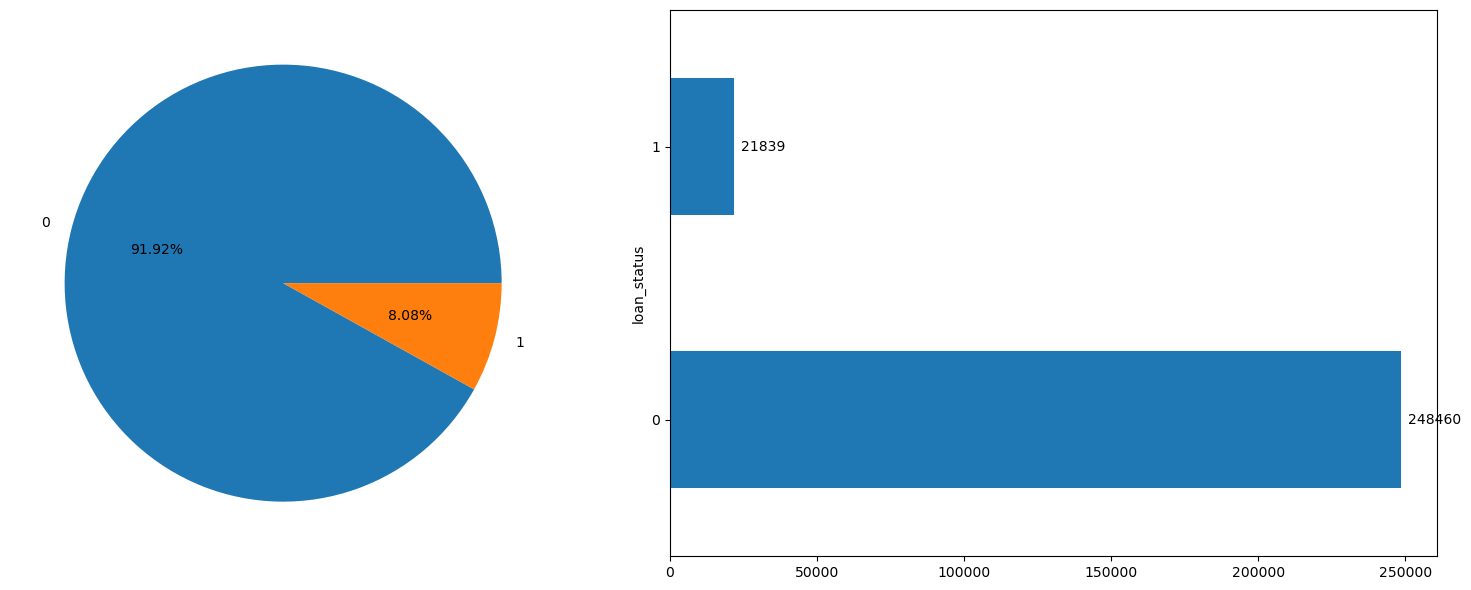

In [12]:
# Statistic of targets
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart with percentages
merged_df[tar_col].value_counts().plot(kind='pie', ax=axs[0], autopct='%.2f%%')
axs[0].set_ylabel('')

# Horizontal bar chart with data labels
target_counts = merged_df[tar_col].value_counts().sort_index()
target_counts.plot(kind='barh', ax=axs[1])

# Add data labels
for i, (index, value) in enumerate(target_counts.items()):
    axs[1].text(value + max(target_counts)*0.01, i, f'{value}', va='center')

plt.tight_layout()
plt.show()

It can be seen that the dataset is highly imbalanced, with over 92% of samples belonging to label 0: Good Loan. Since the dataset is relatively large (270k records), this indicates a positive aspect — the low proportion of Bad Loans at around 8%. However, it also poses a potential risk that the model may not perform well in predicting label 1.

### 2.3 Univariate Analysis

#### 2.3.1 Cat cols

In [25]:
cat_cols

['home_ownership',
 'verification_status',
 'profession',
 'term',
 'grade',
 'pymnt_plan',
 'type',
 'purpose',
 'subregion',
 'have_inc_joint']

**Review 'home_ownership' column**

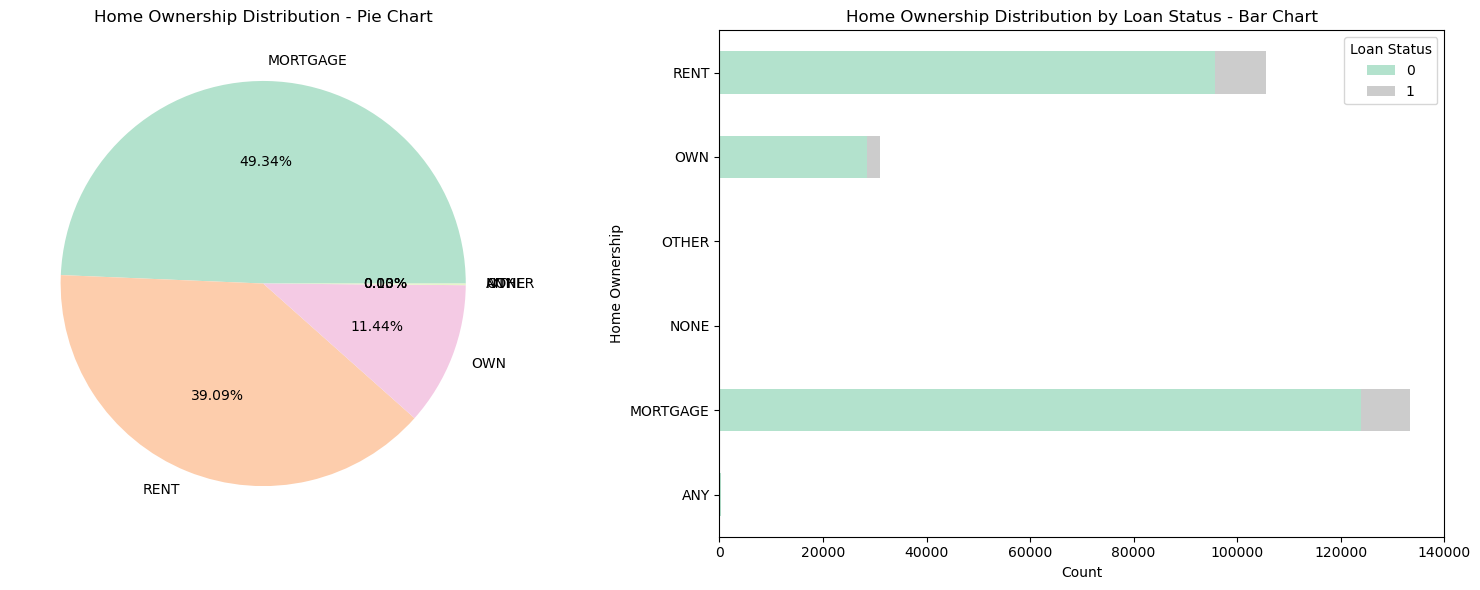

Count of Loan Status by Home Ownership Category:
loan_status     Loan Status: 0  Loan Status: 1
home_ownership                                
ANY                        339              10
MORTGAGE                123982            9372
NONE                         2               0
OTHER                        3               1
OWN                      28443            2484
RENT                     95691            9972
Percentage of Loan Status by Home Ownership Category:
loan_status     Loan Status: 0  Loan Status: 1
home_ownership                                
ANY                      97.13            2.87
MORTGAGE                 92.97            7.03
NONE                    100.00            0.00
OTHER                    75.00           25.00
OWN                      91.97            8.03
RENT                     90.56            9.44


In [13]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['home_ownership'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Home Ownership Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart with 'loan_status' as hue
ho_counts = merged_df.groupby(['home_ownership', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
ho_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Home Ownership Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Home Ownership')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
ho_percentage = merged_df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
ho_counts = ho_counts.rename(columns=lambda x: f'Loan Status: {x}')
ho_percentage = ho_percentage.rename(columns=lambda x: f'Loan Status: {x}')
ho_percentage = ho_percentage.round(2)
print("Count of Loan Status by Home Ownership Category:")
print(ho_counts)
print('Percentage of Loan Status by Home Ownership Category:')
print(ho_percentage)

**MORTGAGE** is the most common home ownership status, followed by **RENT**, these two categories together account for over **88%** of the total observations.

**OWN** represents a significant but smaller portion **(11.44%)** of the data.

**NONE**, **OTHER** and **ANY** are negligible, with a combined proportion of only about 0.1%. Therefore, I will group them into a single category called "OTHERS" to avoid noise.

The 'OTHER' category has a significantly higher proportion of class 1 compared to other categories; however, in terms of quantity, this group consists of only 3 records, which can be considered noise. Therefore, it can be concluded that there appears to be no significant relationship between 'home_ownership' and 'loan_status'.

In [94]:
merged_df['home_ownership'] = merged_df['home_ownership'].replace(['NONE', 'ANY', 'OTHER'], 'OTHERS')

**Review 'verification_status' column**

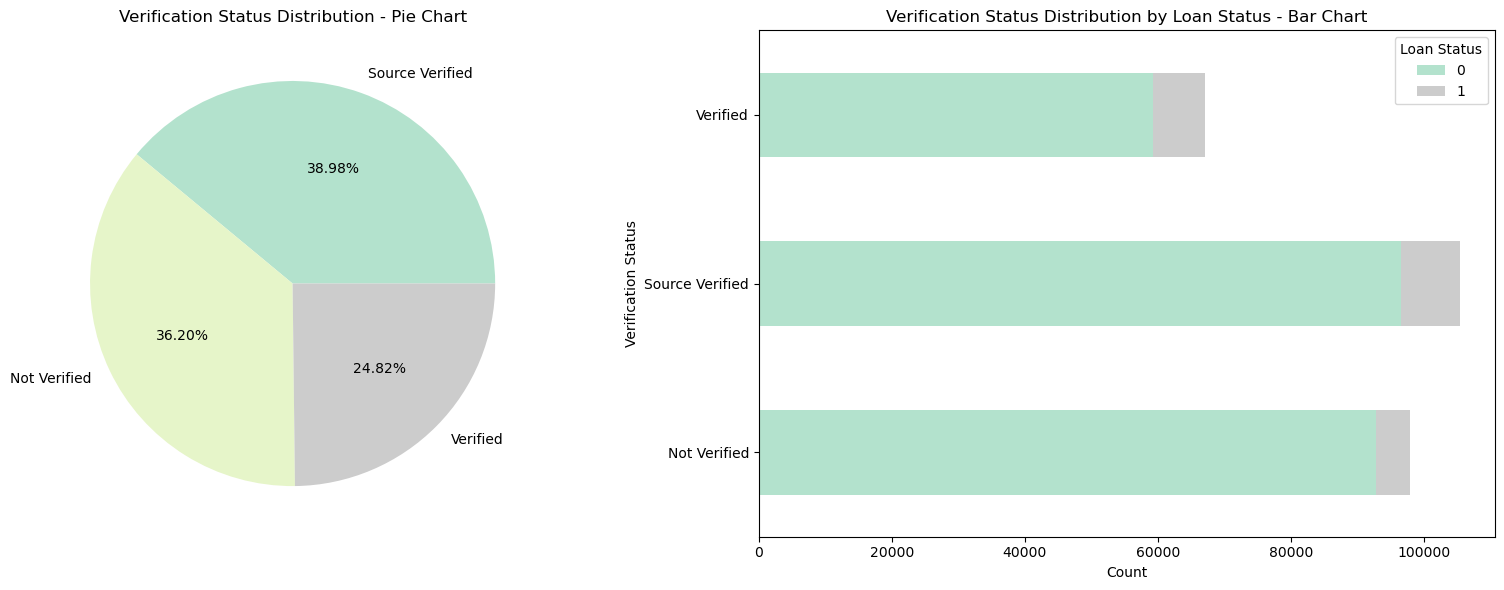

Count of Loan Status by Verification Status Category:
loan_status          Loan Status: 0  Loan Status: 1
verification_status                                
Not Verified                  92749            5102
Source Verified               96501            8872
Verified                      59210            7865
Percentage of Loan Status by Verification Status Category:
loan_status          Loan Status: 0  Loan Status: 1
verification_status                                
Not Verified                  94.79            5.21
Source Verified               91.58            8.42
Verified                      88.27           11.73


In [15]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['verification_status'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Verification Status Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
vs_counts = merged_df.groupby(['verification_status', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
vs_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Verification Status Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Verification Status')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
vs_percentage = merged_df.groupby('verification_status')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
vs_counts = vs_counts.rename(columns=lambda x: f'Loan Status: {x}')
vs_percentage = vs_percentage.rename(columns=lambda x: f'Loan Status: {x}')
vs_percentage = vs_percentage.round(2)
print('Count of Loan Status by Verification Status Category:')
print(vs_counts)
print('Percentage of Loan Status by Verification Status Category:')
print(vs_percentage)

**Source Verified** and **Not Verified** are the most prevalent verification statuses, accounting for over 75% of the data.

**Verified** represents a smaller but significant portion (24.82% ).

The verification status appears to be a strong indicator of loan risk. Loans that are fully 'Verified' are more than twice as likely to be in 'Loan Status' 1 compared to loans that are 'Not Verified'. 'Source Verified' loans fall in between but are also notably riskier than 'Not Verified' loans.

In conclusion, the level of income verification is a significant factor related to loan status, with more thoroughly verified loans exhibiting a higher propensity to be in 'Loan Status' 1 in this dataset. This suggests that **verification_status** could be a **valuable feature** for a predictive model.

**Review 'profession' column**

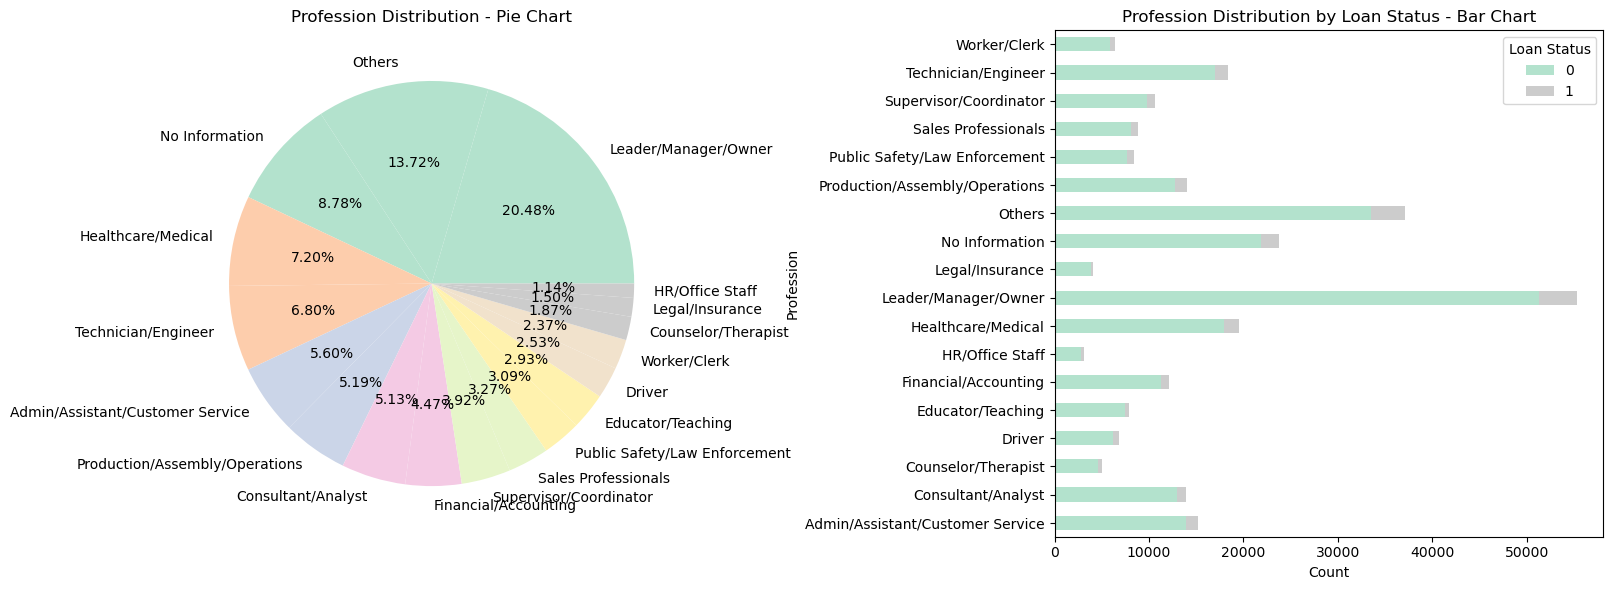

Count of Loan Status by Profession Category:
loan_status                       Loan Status: 0  Loan Status: 1
profession                                                      
Admin/Assistant/Customer Service           13915            1229
Consultant/Analyst                         12945             931
Counselor/Therapist                         4615             439
Driver                                      6160             688
Educator/Teaching                           7402             516
Financial/Accounting                       11220             865
HR/Office Staff                             2809             260
Healthcare/Medical                         17940            1533
Leader/Manager/Owner                       51323            4038
Legal/Insurance                             3796             250
No Information                             21824            1911
Others                                     33513            3581
Production/Assembly/Operations             12

In [16]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['profession'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Profession Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
profession_counts = merged_df.groupby(['profession', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
profession_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Profession Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Profession')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
profession_percentage = merged_df.groupby('profession')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
profession_counts = profession_counts.rename(columns=lambda x: f'Loan Status: {x}')
profession_percentage = profession_percentage.rename(columns=lambda x: f'Loan Status: {x}')
profession_percentage = profession_percentage.round(2)
print('Count of Loan Status by Profession Category:')
print(profession_counts)
print('Percentage of Loan Status by Profession Category:')
print(profession_percentage)

After processing the data from the 'emp_title' column, which had 77,000 unique values, and performing clustering using KMeans, the resulting 'profession' column has 18 unique values. The high-cardinality categorical column will be processed using target encoding before being used in the model. 

**Leader/Manager/Owner** is the most prevalent profession, accounting for over 20% of the data, **8.78%** of customers have **no occupation information** and **13.72%** belong to small-sized categories that have been grouped into the **'Others'** category.

There appears to be no significant relationship between 'profession' and 'loan_status'.

**Review 'subregion' column**

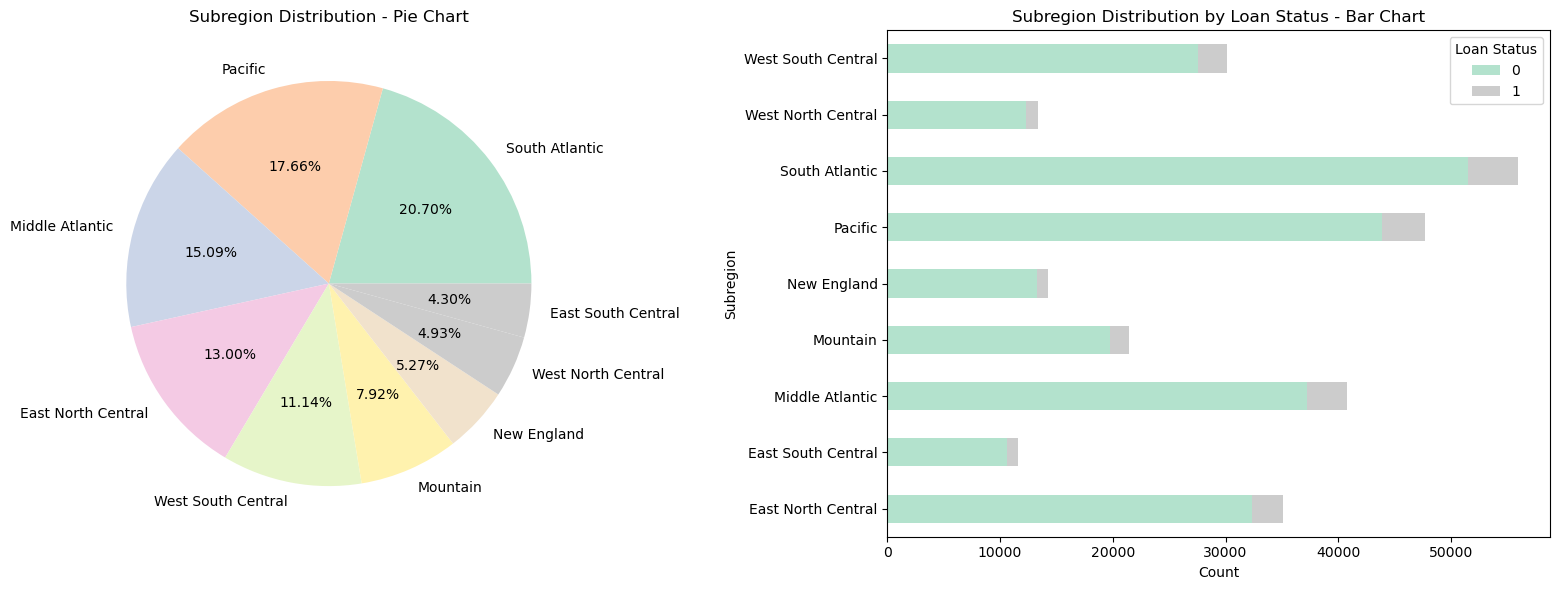

Count of Loan Status by Subregion Category:
loan_status         Loan Status: 0  Loan Status: 1
subregion                                         
East North Central           32388            2755
East South Central           10598            1022
Middle Atlantic              37200            3581
Mountain                     19786            1615
New England                  13249             984
Pacific                      43879            3857
South Atlantic               51500            4452
West North Central           12272            1050
West South Central           27588            2523
Percentage of Loan Status by Subregion Category:
loan_status         Loan Status: 0  Loan Status: 1
subregion                                         
East North Central           92.16            7.84
East South Central           91.20            8.80
Middle Atlantic              91.22            8.78
Mountain                     92.45            7.55
New England                  93.09      

In [95]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['subregion'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Subregion Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
sr_counts = merged_df.groupby(['subregion', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
sr_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Subregion Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Subregion')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
sr_percentage = merged_df.groupby('subregion')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
sr_counts = sr_counts.rename(columns=lambda x: f'Loan Status: {x}')
sr_percentage = sr_percentage.rename(columns=lambda x: f'Loan Status: {x}')
sr_percentage = sr_percentage.round(2)
print('Count of Loan Status by Subregion Category:')
print(sr_counts)
print('Percentage of Loan Status by Subregion Category:')
print(sr_percentage)

Although there is some variation in default rates, the range of these rates across all subregions is relatively narrow. There appears to be no significant relationship between 'subregion' and 'loan_status'.

**Review 'term' column**

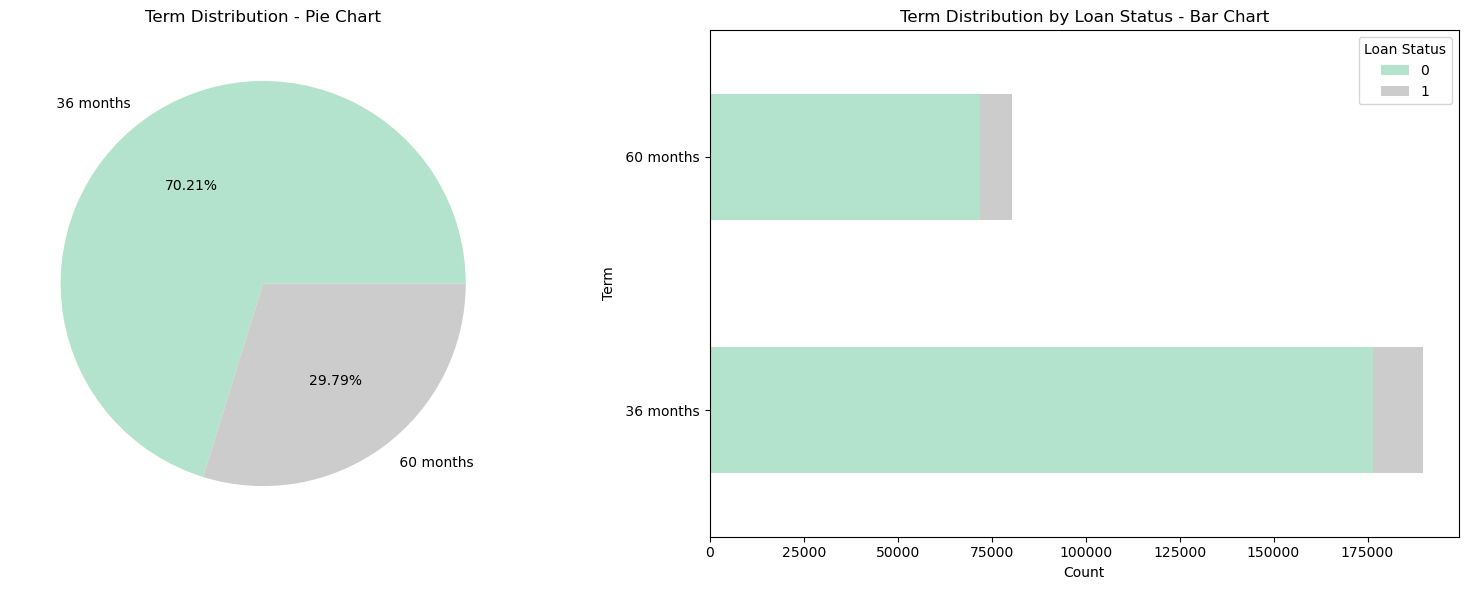

Count of Loan Status by Term Category:
loan_status  Loan Status: 0  Loan Status: 1
term                                       
36 months            176570           13202
60 months             71890            8637
Percentage of Loan Status by Term Category:
loan_status  Loan Status: 0  Loan Status: 1
term                                       
36 months             93.04            6.96
60 months             89.27           10.73


In [18]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['term'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Term Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
term_counts = merged_df.groupby(['term', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
term_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Term Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Term')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
term_percentage = merged_df.groupby('term')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
term_counts = term_counts.rename(columns=lambda x: f'Loan Status: {x}')
term_percentage = term_percentage.rename(columns=lambda x: f'Loan Status: {x}')
term_percentage = term_percentage.round(2)
print('Count of Loan Status by Term Category:')
print(term_counts)
print('Percentage of Loan Status by Term Category:')
print(term_percentage)

**'36 months'** is the most prevalent loan term, accounting for **70.21%** of the data, while the remaining **29.79%** belong to **'60 months'** term

Loans with a term of '60 months' account for only about half the proportion compared to those with a '36 months' term, but they have more than 1.5 times the proportion of 'Loan Status' 1. This indicates that longer-term loans tend to carry higher risk.

**Review 'grade' column**

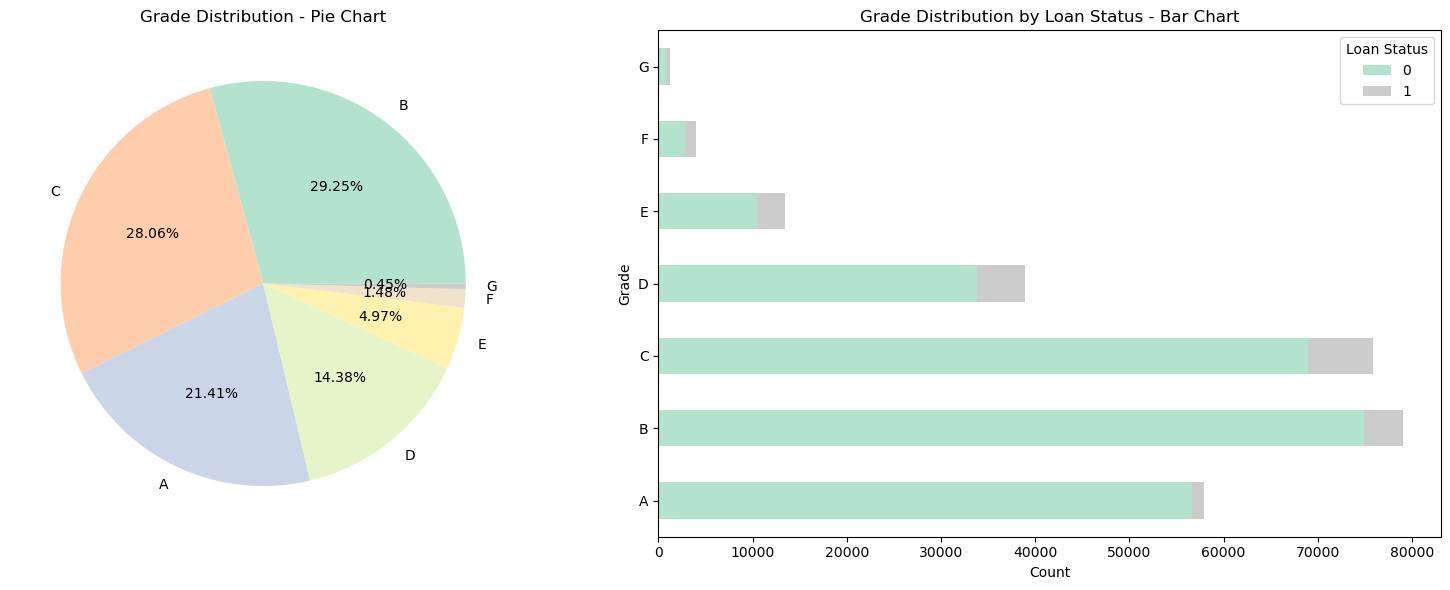

Count of Loan Status by Grade Category:
loan_status  Loan Status: 0  Loan Status: 1
grade                                      
A                     56655            1216
B                     74944            4128
C                     68990            6850
D                     33770            5106
E                     10468            2961
F                      2813            1192
G                       820             386
Percentage of Loan Status by Grade Category:
loan_status  Loan Status: 0  Loan Status: 1
grade                                      
A                     97.90            2.10
B                     94.78            5.22
C                     90.97            9.03
D                     86.87           13.13
E                     77.95           22.05
F                     70.24           29.76
G                     67.99           32.01


In [19]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['grade'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Grade Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
grade_counts = merged_df.groupby(['grade', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
grade_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Grade Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Grade')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
grade_percentage = merged_df.groupby('grade')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
grade_counts = grade_counts.rename(columns=lambda x: f'Loan Status: {x}')
grade_percentage = grade_percentage.rename(columns=lambda x: f'Loan Status: {x}')
grade_percentage = grade_percentage.round(2)
print('Count of Loan Status by Grade Category:')
print(grade_counts)
print('Percentage of Loan Status by Grade Category:')
print(grade_percentage)

**93%** of the data belongs to groups **A, B, C, and D**, while only about **7%** belongs to the remaining three groups **E, F, and G**.

Loan Grade is a **highly predictive feature** for determining loan status. Lower grades (D, E, F, G) are associated with considerably higher risk of default compared to higher grades (A, B, C). This monotonic trend makes **'Grade'** a **potentially crucial variable** for credit risk assessment and modeling.

**Review 'type' column**

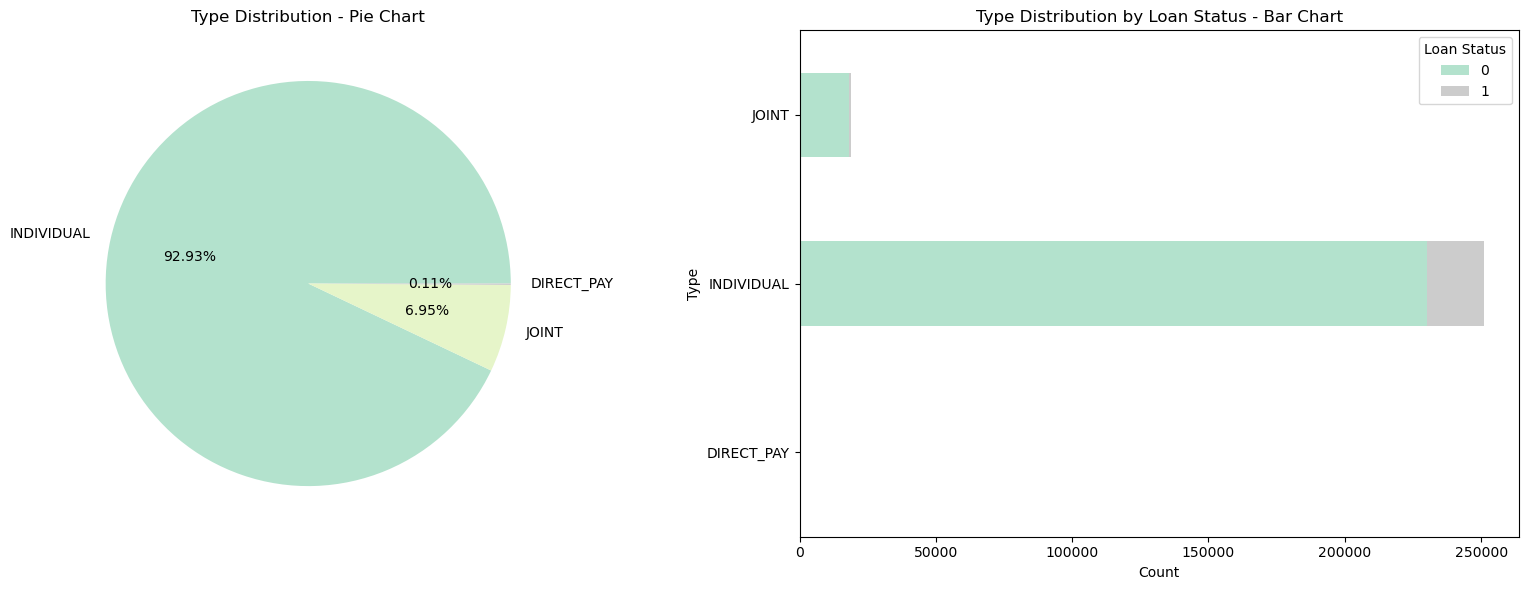

Count of Loan Status by Type Category:
loan_status  Loan Status: 0  Loan Status: 1
type                                       
DIRECT_PAY              260              43
INDIVIDUAL           230082           21120
JOINT                 18118             676
Percentage of Loan Status by Type Category:
loan_status  Loan Status: 0  Loan Status: 1
type                                       
DIRECT_PAY            85.81           14.19
INDIVIDUAL            91.59            8.41
JOINT                 96.40            3.60


In [20]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['type'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Type Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
type_counts = merged_df.groupby(['type', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
type_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Type Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Type')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
type_percentage = merged_df.groupby('type')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
type_counts = type_counts.rename(columns=lambda x: f'Loan Status: {x}')
type_percentage = type_percentage.rename(columns=lambda x: f'Loan Status: {x}')
type_percentage = type_percentage.round(2)
print('Count of Loan Status by Type Category:')
print(type_counts)
print('Percentage of Loan Status by Type Category:')
print(type_percentage)

The dataset is severely imbalanced, **INDIVIDUAL** is the most common type, accounting for **92.93%** of the data while **'DIRECT_PAY'** has only **0.11%**

The 'Type' variable appears to have predictive power regarding loan status. 'JOINT' loans seem considerably less risky than 'INDIVIDUAL' loans, while 'DIRECT_PAY' loans appear the riskiest.

In conclusion, while the loan types are very unevenly distributed, they show distinct risk profiles, making 'Type' a potentially useful feature for predicting loan status.

**Review 'purpose' column**

In [96]:
# Define mapping dictionary for semantic grouping
purpose_mapping = {
    'debt_consolidation': 'debt_consolidation',
    'credit_card': 'credit_card',
    'home_improvement': 'home_related',
    'house': 'home_related',
    'medical': 'health',
    'car': 'auto',
    'wedding': 'personal_lifestyle',
    'vacation': 'personal_lifestyle',
    'moving': 'personal_lifestyle',
    'major_purchase': 'major_purchase',
    'small_business': 'business',
    'other': 'other',
    'renewable_energy': 'other'
}

# Apply the mapping to the DataFrame
merged_df['purpose'] = merged_df['purpose'].map(purpose_mapping)
merged_df['purpose'] = merged_df['purpose'].fillna('other')

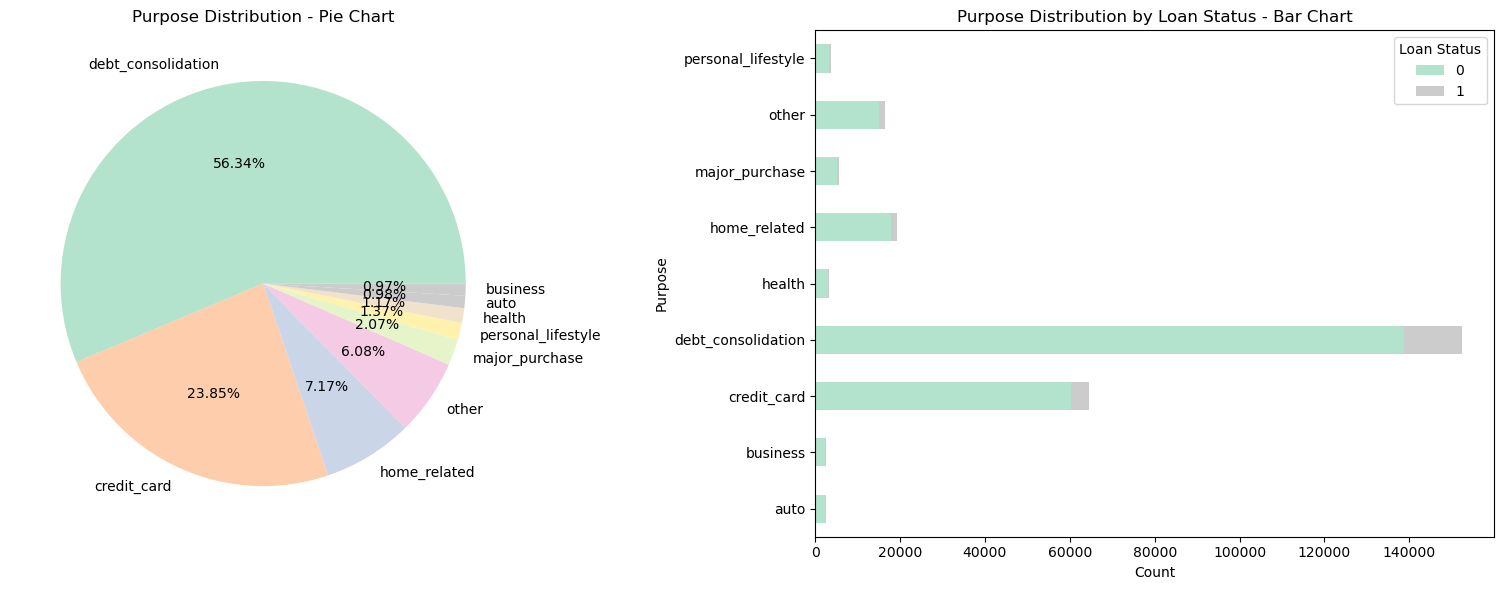

Count of Loan Status by Purpose Category:
loan_status         Loan Status: 0  Loan Status: 1
purpose                                           
auto                          2490             155
business                      2310             305
credit_card                  60368            4109
debt_consolidation          138710           13575
health                        2927             246
home_related                 17984            1403
major_purchase                5154             430
other                        15162            1273
personal_lifestyle            3355             343
Percentage of Loan Status by Purpose Category:
loan_status         Loan Status: 0  Loan Status: 1
purpose                                           
auto                         94.14            5.86
business                     88.34           11.66
credit_card                  93.63            6.37
debt_consolidation           91.09            8.91
health                       92.25          

In [22]:
# Pie chart
fig, axs = plt.subplots(1, 2, figsize=(16, 6))   
merged_df['purpose'].value_counts(dropna=False).plot(kind='pie', autopct='%.2f%%', ax=axs[0], title='Purpose Distribution - Pie Chart', cmap='Pastel2')
axs[0].set_ylabel('')  

# Horizontal bar chart
purpose_counts = merged_df.groupby(['purpose', 'loan_status']).size().unstack(fill_value=0)

# Plotting horizontal stacked bar chart
purpose_counts.plot(kind='barh', stacked=True, ax=axs[1], cmap='Pastel2')
axs[1].set_title('Purpose Distribution by Loan Status - Bar Chart')
axs[1].set_ylabel('Purpose')
axs[1].set_xlabel('Count')

# Add legend for loan status
axs[1].legend(title='Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

# Print data table
purpose_percentage = merged_df.groupby('purpose')['loan_status'].value_counts(normalize=True).unstack(fill_value=0) * 100
purpose_counts = purpose_counts.rename(columns=lambda x: f'Loan Status: {x}')
purpose_percentage = purpose_percentage.rename(columns=lambda x: f'Loan Status: {x}')
purpose_percentage = purpose_percentage.round(2)
print('Count of Loan Status by Purpose Category:')
print(purpose_counts)
print('Percentage of Loan Status by Purpose Category:')
print(purpose_percentage)

56.34% of customers took out loans for the purpose of **'debt_consolidation'**, and 23.85% for **'credit_card'** purposes, while the remaining 20% borrowed for other purposes.

**Highest Risk Purposes**: 'Business' loans show the highest percentage of 'Loan Status' 1 at 11.66%. 'Personal Lifestyle' (9.28%) and 'Debt Consolidation' (8.91%) loans also exhibit relatively higher default rates compared to the overall average.

**Lowest Risk Purposes**: 'Auto' loans have the lowest percentage of 'Loan Status' 1 at 5.86%. 'Credit Card' loans, despite being a very common purpose, also have a relatively low default rate of 6.37%.

The purpose of the loan provides some indication of the associated risk. Loans for 'business', 'personal lifestyle', and 'debt consolidation' tend to have higher default rates, while loans for 'auto' and 'credit card' consolidation show lower default rates in this dataset. This makes 'Purpose' a potentially useful categorical feature for predicting loan status.

#### 2.3.2 Num cols

In [38]:
num_cols

['emp_length',
 'avg_cur_bal',
 'Tot_cur_bal',
 'loan_amount',
 'int_rate',
 'installment',
 'issue_month',
 'issue_quarter',
 'issue_year_num',
 'total_inc']

In [39]:
# statistics of num cols
merged_df[num_cols].describe()

emp_length    avg_cur_bal   Tot_cur_bal    loan_amount  \
count  251554.000000  270299.000000  2.702990e+05  270299.000000   
mean        5.869289   13668.796092  1.446931e+05   15412.829496   
std         3.749492   16753.975392  1.639825e+05    9459.781419   
min         0.000000       0.000000  0.000000e+00    1000.000000   
25%         2.000000    3107.000000  2.948200e+04    8000.000000   
50%         6.000000    7376.000000  8.047800e+04   13200.000000   
75%        10.000000   18921.500000  2.165500e+05   20300.000000   
max        10.000000  623229.000000  9.971659e+06   40000.000000   

            int_rate    installment    issue_month  issue_quarter  \
count  270299.000000  270299.000000  270299.000000  270299.000000   
mean        0.130765     453.919176       6.739544       2.587727   
std         0.048865     272.337511       3.410329       1.115205   
min         0.053100      29.520000       1.000000       1.000000   
25%         0.094300     256.040010       4.000000       2.000000   
50%         0.126100     383.959990       7.000000       3.000000   
75%         0.160100     605.120000      10.000000       4.000000   
max         0.309900    1719.830000      12.000000       4.000000   

       issue_year_num     total_inc  
count   270299.000000  2.702990e+05  
mean      2016.587242  8.870368e+04  
std          1.837425  9.343633e+04  
min       2012.000000  2.000000e+03  
25%       2015.000000  5.000000e+04  
50%       2017.000000  7.000000e+04  
75%       2018.000000  1.040000e+05  
max       2019.000000  1.399288e+07

**Review 'loan_amount' column**

<Axes: xlabel='loan_amount', ylabel='Density'>

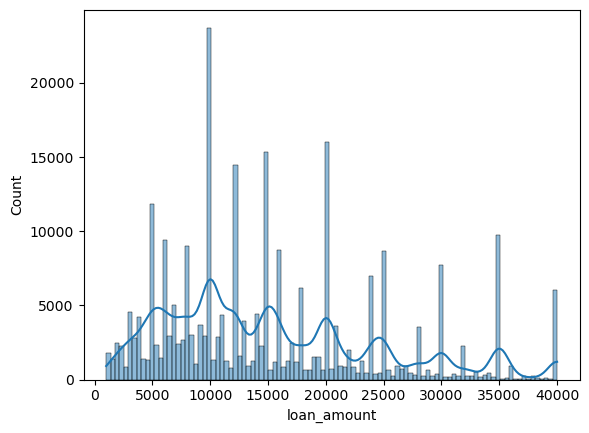

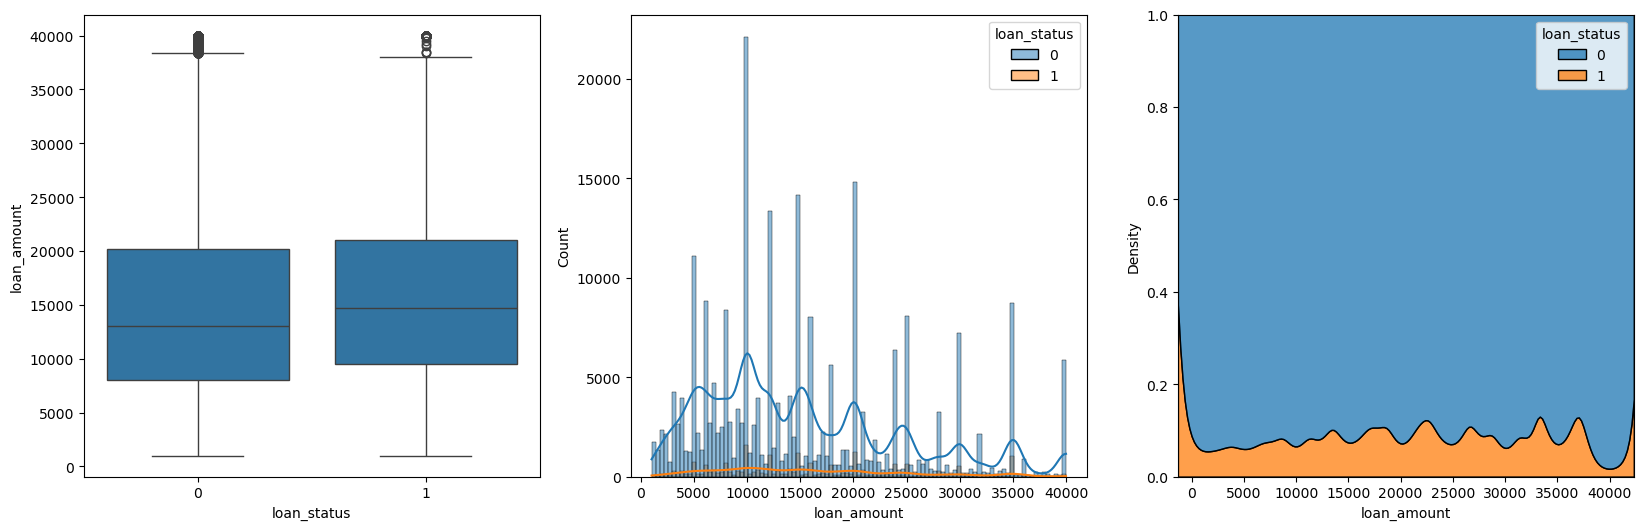

In [40]:
c = 'loan_amount'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

The data is heavily skewed to the left, indicating that most loans have smaller amounts. There are multiple peaks in the distribution, suggesting that loan amounts cluster around certain values (e.g., around 5000, 10000, 15000, etc.).

The Kernel Density Estimate (KDE) curve overlays the histogram, providing a smooth representation of the distribution. The long tail on the right indicates the presence of a few very large loan amounts, but these are less frequent.

There is no strong correlation between loan_amount and loan_status.

**Review 'total_inc' column**

<Axes: xlabel='total_inc', ylabel='Density'>

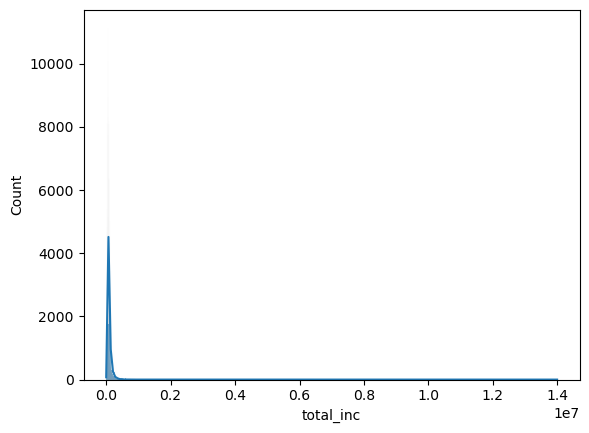

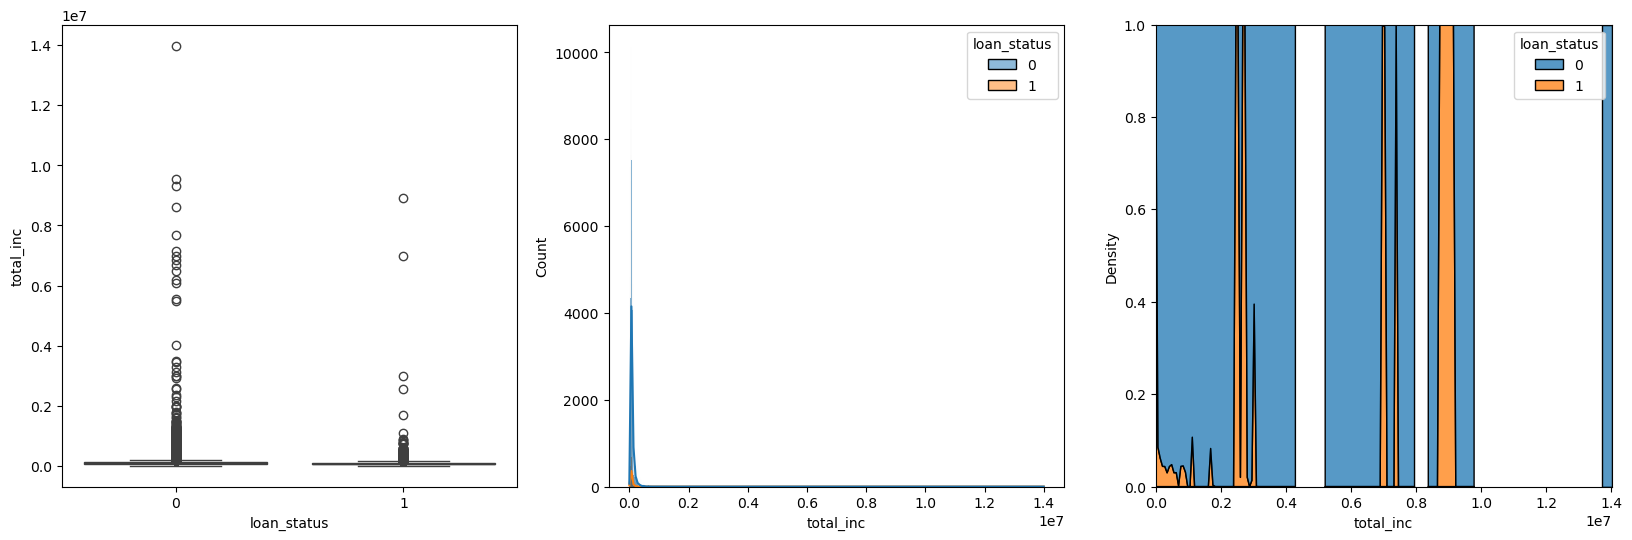

In [42]:
c = 'total_inc'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

The total_income distribution is highly skewed, with most individuals having low incomes and a few outliers with very high incomes. The long tail indicates the presence of extreme values, but these are rare.

There is no strong correlation between total_income and loan_status. Both defaulters and non-defaulters have similar income distributions, as evidenced by the overlapping box plots and KDE plots.

<Axes: xlabel='total_inc', ylabel='Density'>

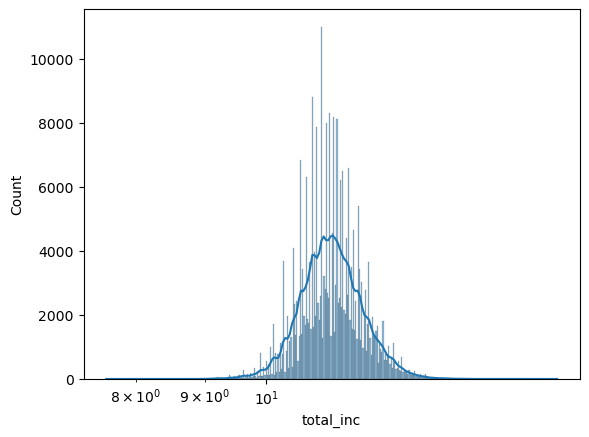

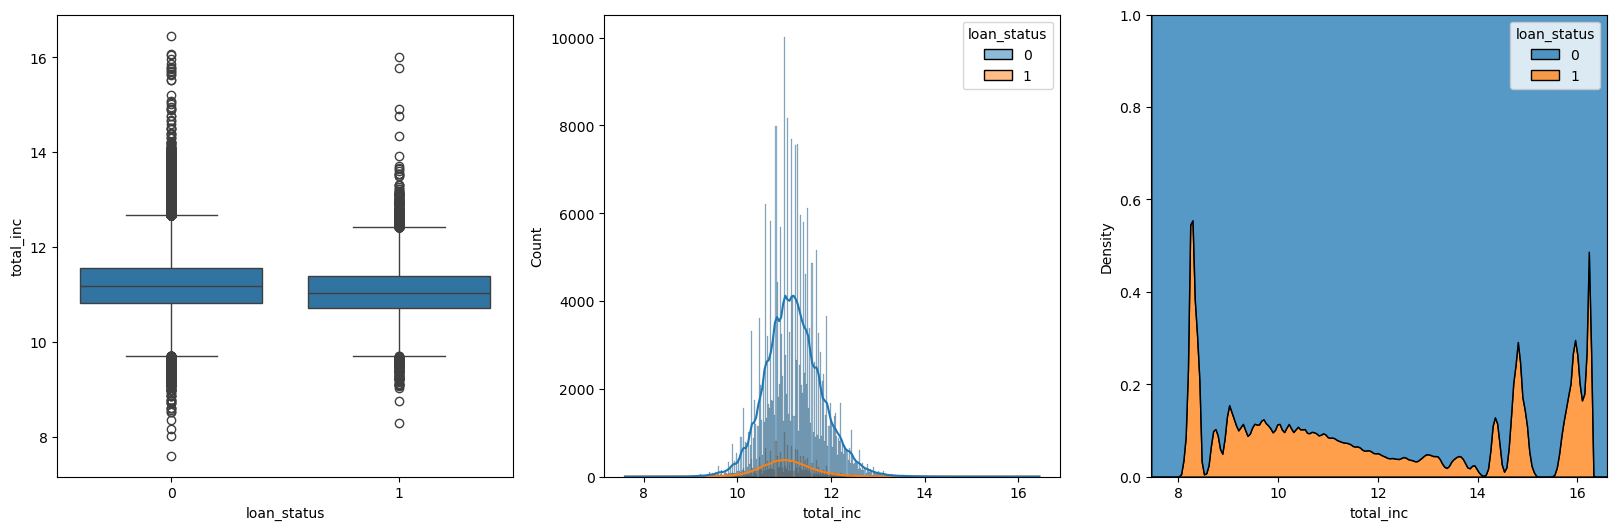

In [41]:
c = 'total_inc'

df1 = merged_df.copy()
df1[c] = np.log(df1[c]).fillna(-1)

sns.histplot(df1, x=c, kde=True, log_scale=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=df1, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=df1, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=df1, x=c, hue=tar_col, multiple='fill', ax=axs[2])

The log transformation reduces the skewness in the total_income distribution, making it more symmetric but it does not uncover a strong relationship with loan_status

**Review 'avg_cur_bal' column**

<Axes: xlabel='avg_cur_bal', ylabel='Density'>

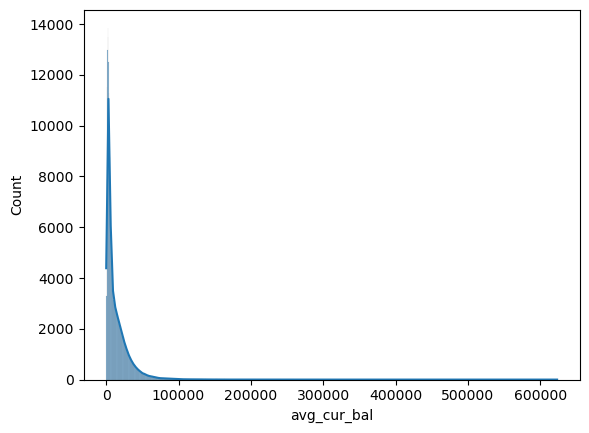

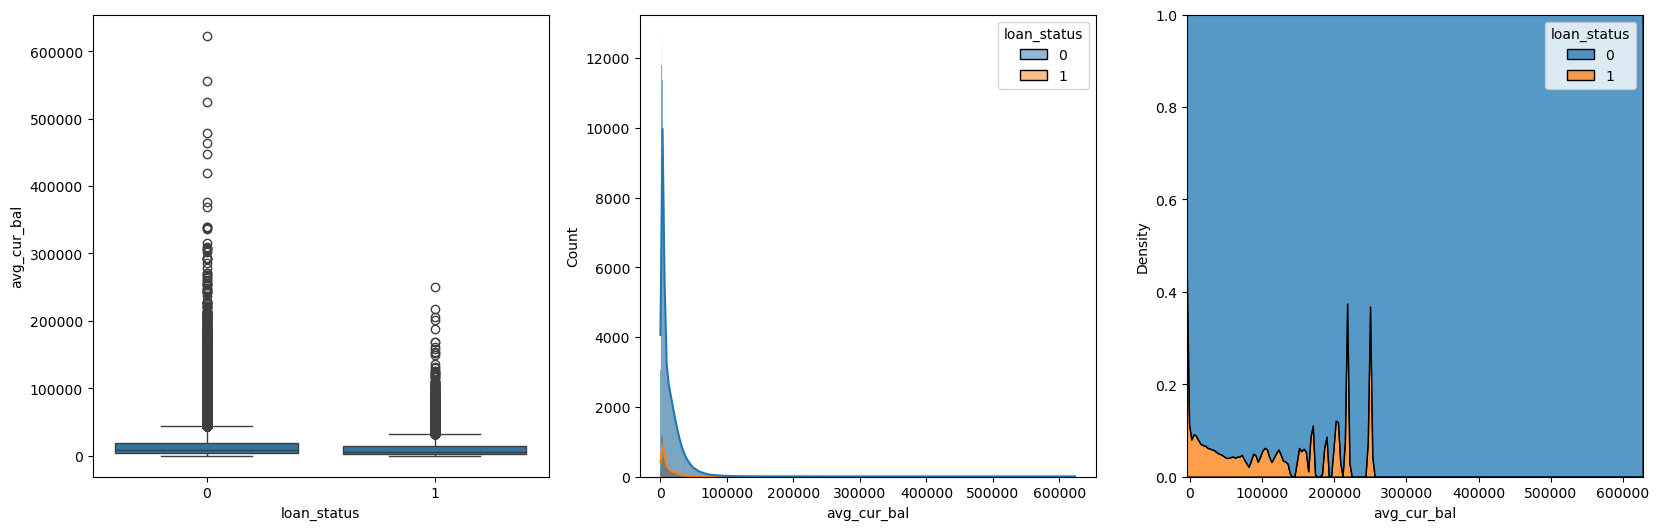

In [43]:
c = 'avg_cur_bal'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

<Axes: xlabel='avg_cur_bal', ylabel='Density'>

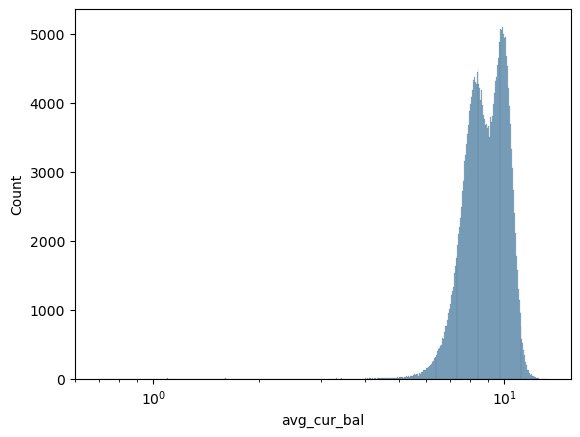

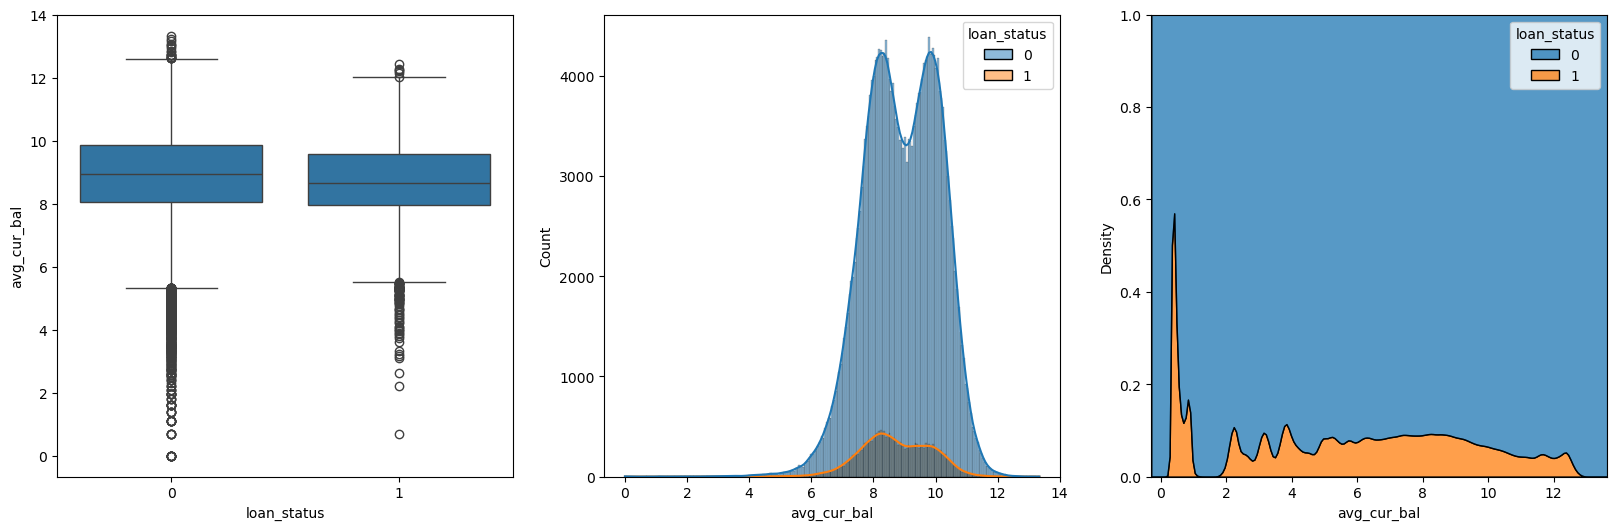

In [44]:
c = 'avg_cur_bal'

df1[c] = np.log(df1[c]).fillna(-1)

sns.histplot(df1, x=c, kde=True, log_scale=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=df1, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=df1, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=df1, x=c, hue=tar_col, multiple='fill', ax=axs[2])

'avg_cur_bal' is heavily skewed, with most individuals having very low average current balances. The log transformation successfully reduces the skewness in the 'avg_cur_bal' distribution, and now it's roughly bell-shaped with two peaks (bimodal).

Even after transformation, the distributions of the two loan statuses still overlap a lot, meaning 'avg_cur_bal' alone isn’t a strong separator for predicting loan status. But people who default tend to cluster a bit lower on the balance scale.

**Review 'Tot_cur_bal' column**

<Axes: xlabel='Tot_cur_bal', ylabel='Density'>

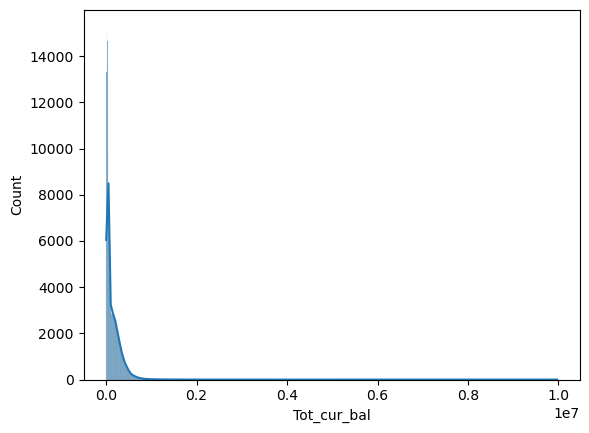

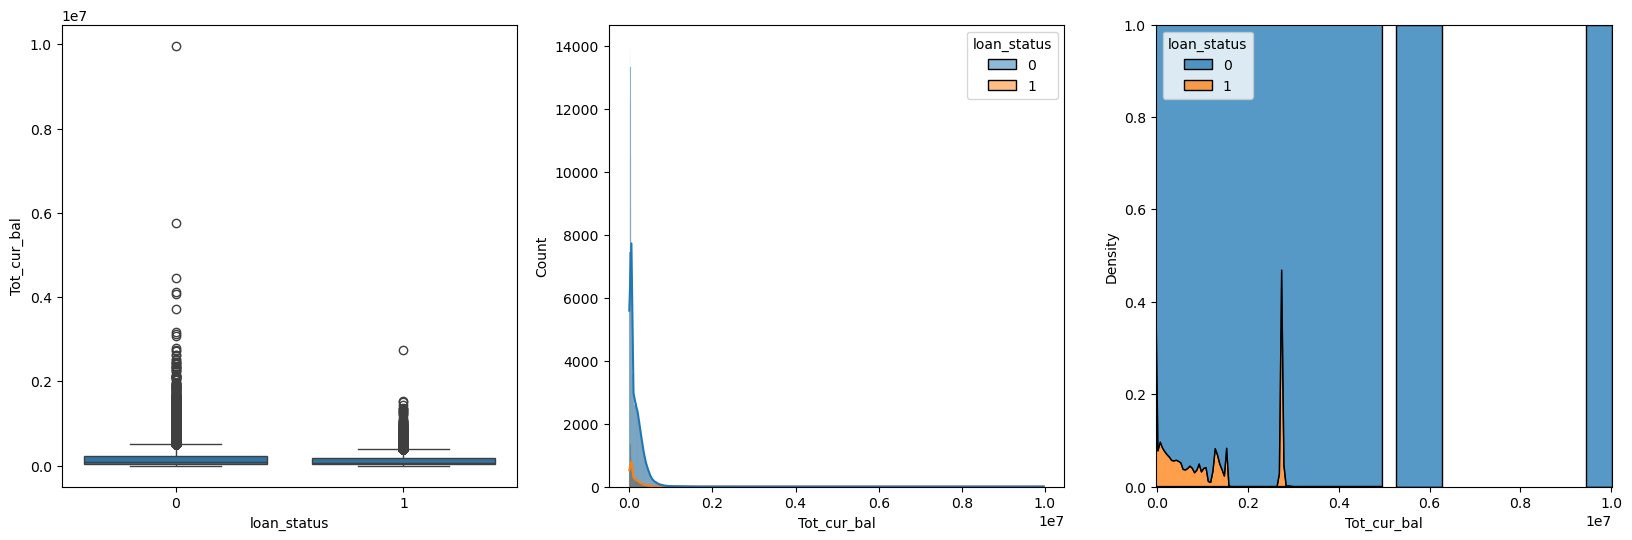

In [45]:
c = 'Tot_cur_bal'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

<Axes: xlabel='Tot_cur_bal', ylabel='Density'>

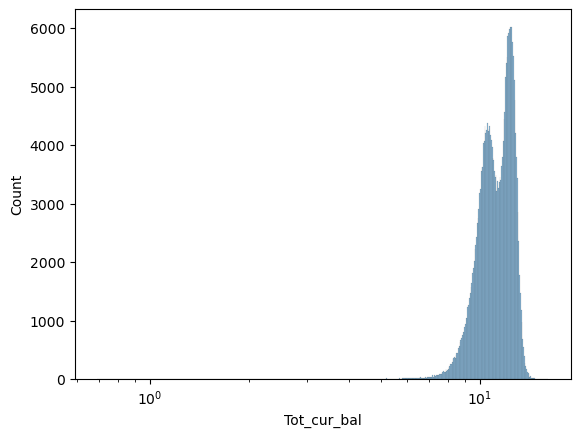

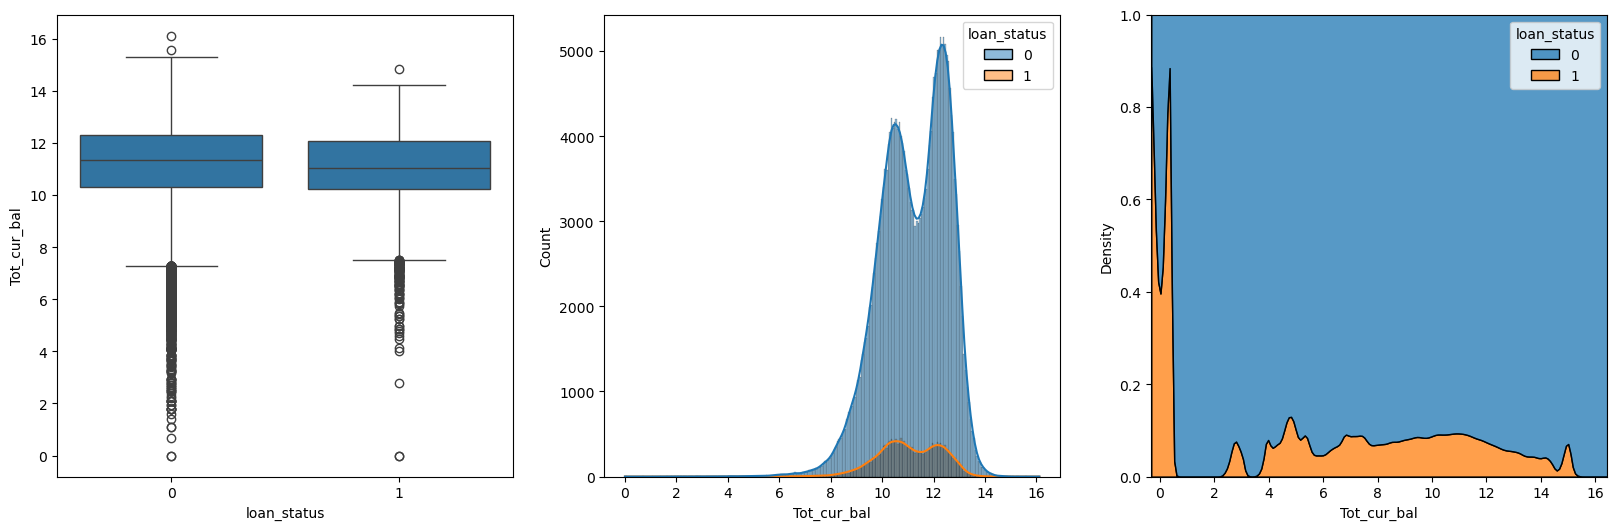

In [46]:
c = 'Tot_cur_bal'

df1[c] = np.log(df1[c]).fillna(-1)

sns.histplot(df1, x=c, kde=True, log_scale=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=df1, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=df1, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=df1, x=c, hue=tar_col, multiple='fill', ax=axs[2])

'Total_cur_bal' is similar to 'avg_cur_bal'.

**Review 'int_rate' column**

<Axes: xlabel='int_rate', ylabel='Density'>

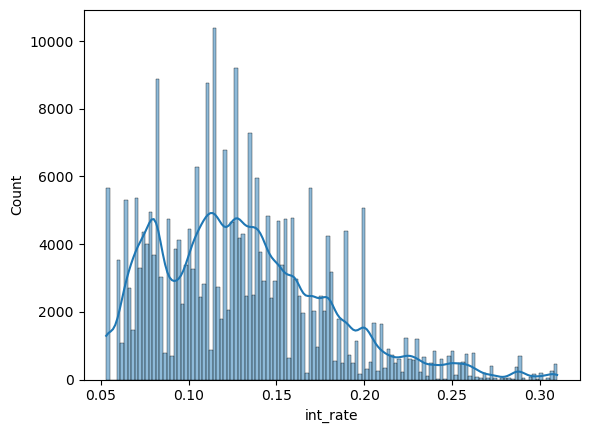

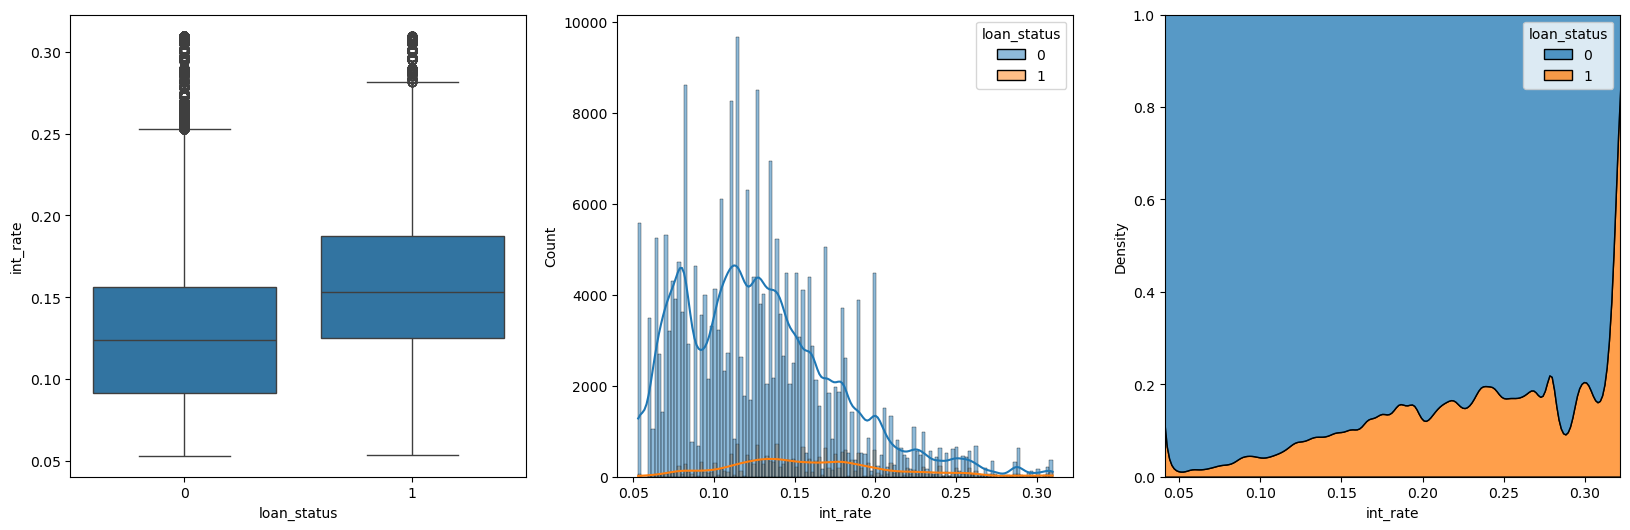

In [47]:
c = 'int_rate'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

'int_rate' is a strong predictor of default, customer with loan_status = 1 (defaults) tend to have higher interest rates.

In the density plot: Orange area (defaults) concentrate more heavily as interest rate increases, especially above 15%, default risk noticeably spikes. 

Higher interest rates → higher risk borrowers → more likely to default. 

**Review 'installment' column**

<Axes: xlabel='installment', ylabel='Density'>

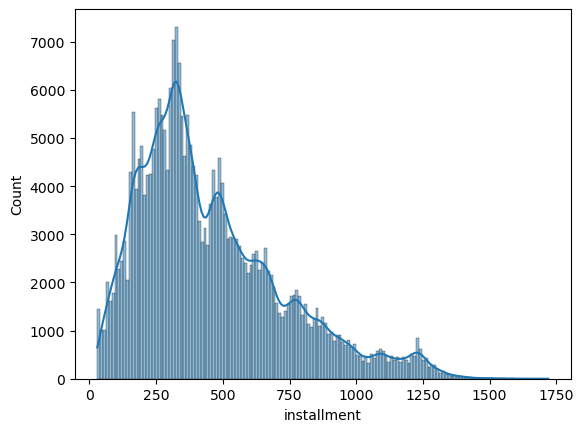

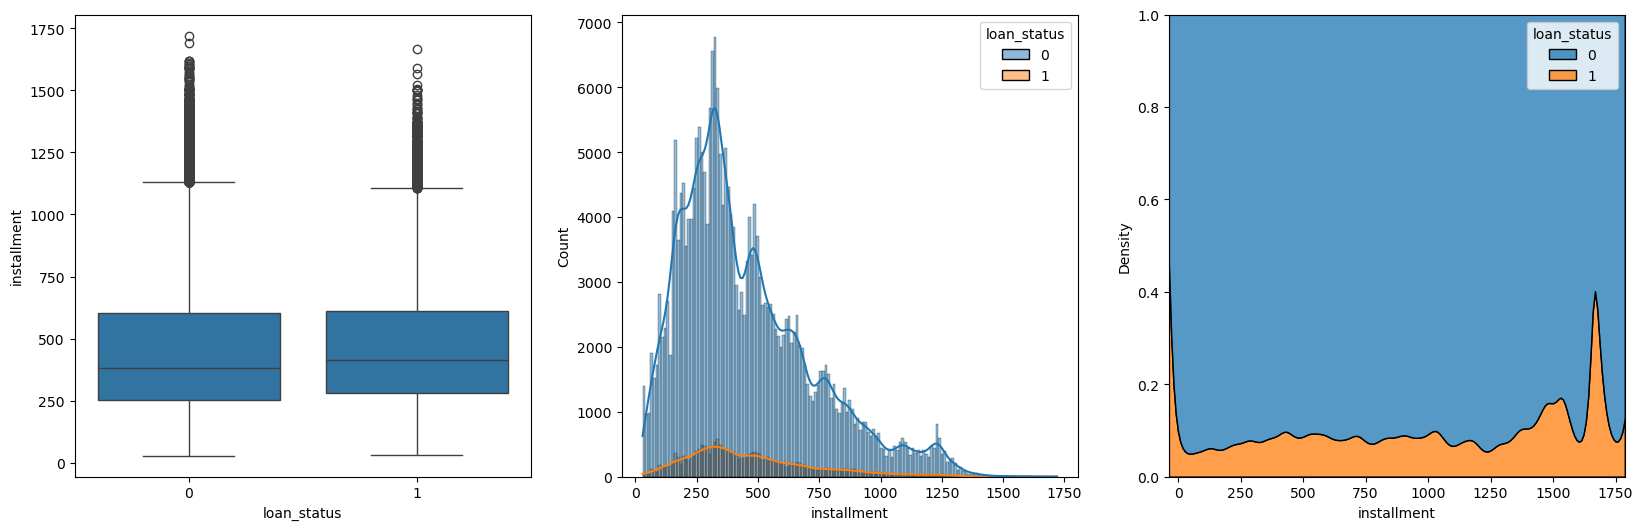

In [48]:
c = 'installment'

sns.histplot(merged_df, x=c, kde=True)

f, axs = plt.subplots(1,3,figsize=(20, 6))

sns.boxplot(data=merged_df, x=tar_col, y=c, ax=axs[0])
sns.histplot(data=merged_df, x=c, hue=tar_col,  kde=True, ax=axs[1])
sns.kdeplot(data=merged_df, x=c, hue=tar_col, multiple='fill', ax=axs[2])

Based on these plots, the 'installment' amount alone does not appear to be a strong standalone predictor or indicator of a loan's status. The distributions of installment for the two loan statuses largely overlap, suggesting that knowing the installment amount doesn't provide significant leverage in determining the loan status.

### 2.4 Multivariate Analysis

In [49]:
num_cols, cat_cols

(['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'total_inc'],
 ['home_ownership',
  'verification_status',
  'profession',
  'term',
  'grade',
  'pymnt_plan',
  'type',
  'purpose',
  'subregion',
  'have_inc_joint'])

#### 2.4.1 Correlation Analysis for Numerical Variables

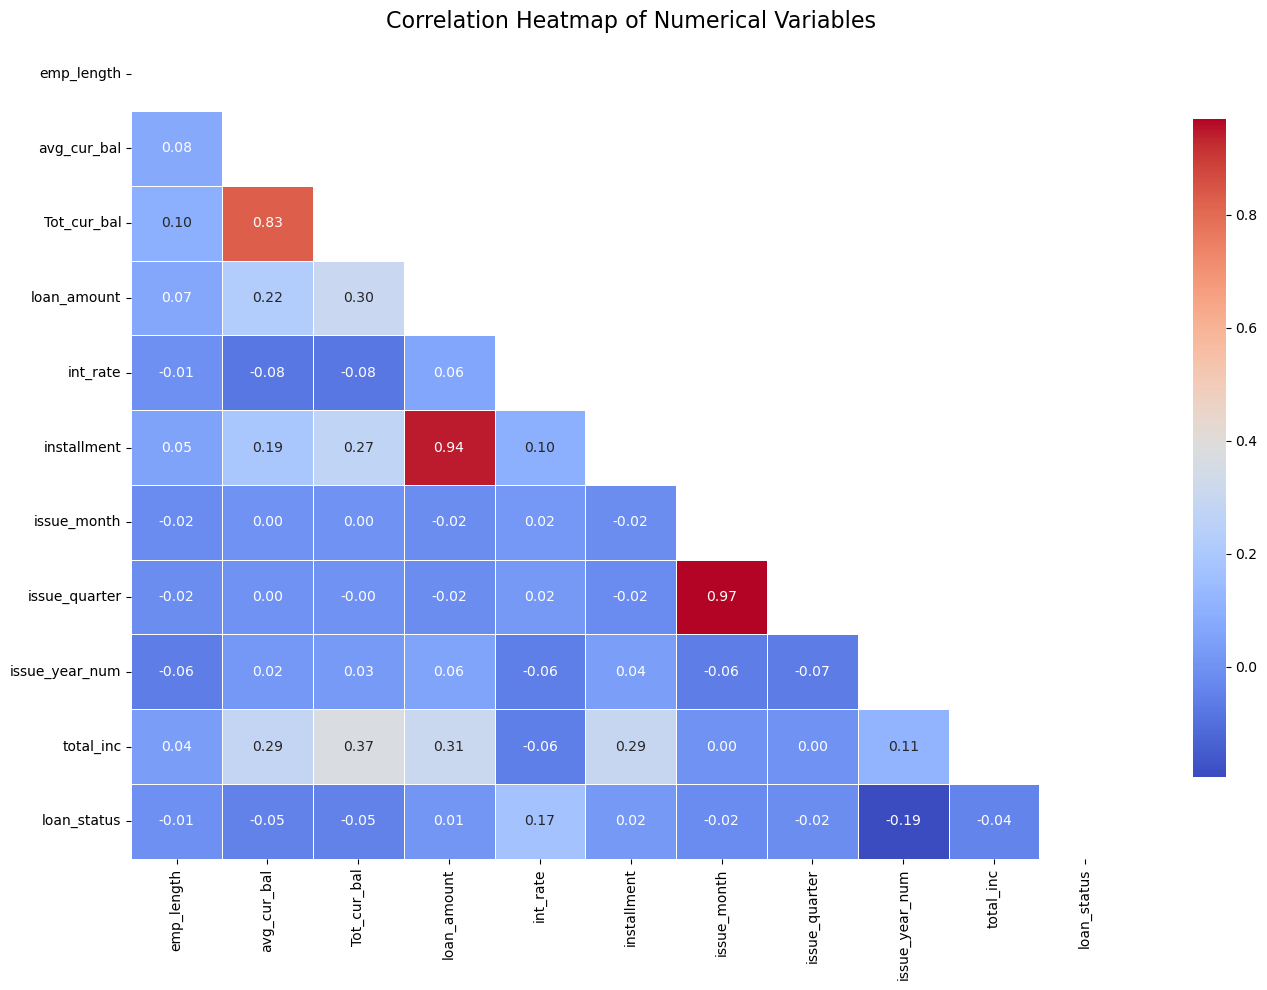


Potentially highly correlated features (|r| > 0.7):
avg_cur_bal and Tot_cur_bal: 0.827
loan_amount and installment: 0.944
issue_month and issue_quarter: 0.971


In [23]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
corr_matrix = merged_df[num_cols + ['loan_status']].corr()
mask = np.triu(corr_matrix)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()

# Identify high correlations (potential multicollinearity)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:  # Threshold for high correlation
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("\nPotentially highly correlated features (|r| > 0.7):")
    for var1, var2, corr in high_corr:
        print(f"{var1} and {var2}: {corr:.3f}")

#### 2.4.2 Pairplot for selected numerical variables

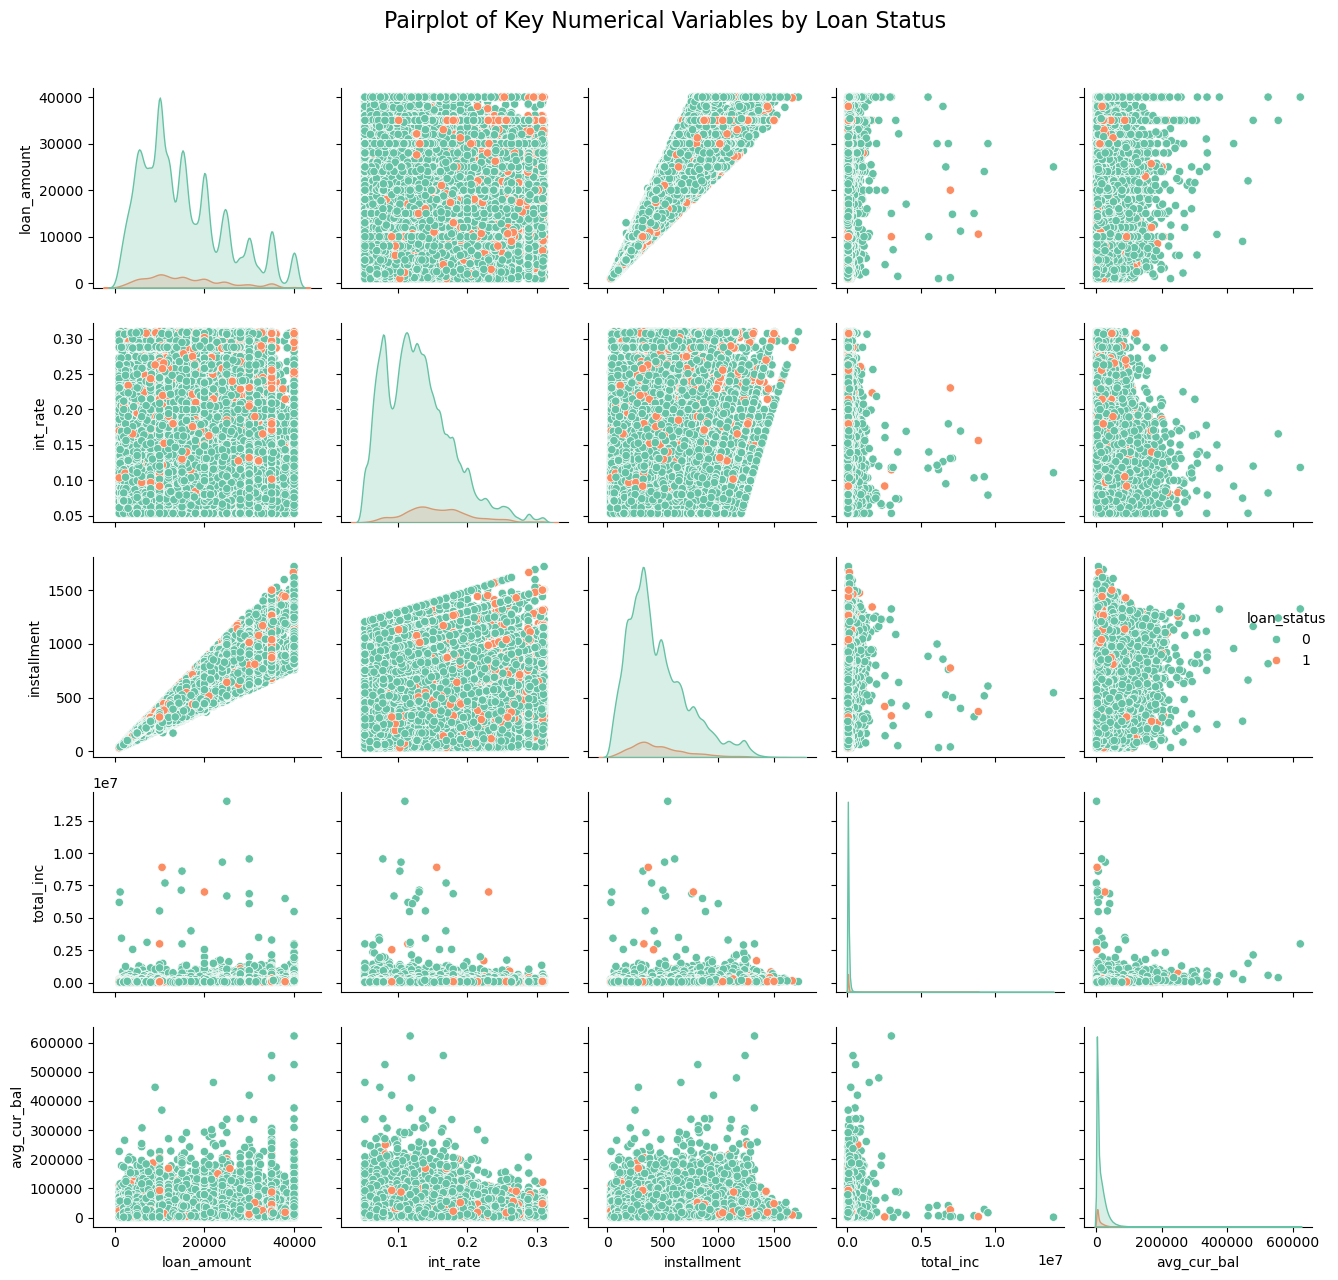

In [15]:
# Select a subset of numerical columns to avoid overcrowded plots
selected_num_cols = ['loan_amount', 'int_rate', 'installment', 'total_inc', 'avg_cur_bal']
sns.pairplot(merged_df[selected_num_cols + ['loan_status']], hue='loan_status', palette='Set2', diag_kind='kde', height=2.5)
plt.suptitle('Pairplot of Key Numerical Variables by Loan Status', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#### 2.4.3 Interaction between numerical and categorical variables

In [17]:
# Boxplots to visualize how numerical variables vary across categorical groups with target
def plot_num_cat_target_relationship(df, num_var, cat_var, target='loan_status', sort_by = None):
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=cat_var, y=num_var, hue=target, data=df, palette='Set2')
    plt.title(f'Distribution of {num_var} by {cat_var} and {target}', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

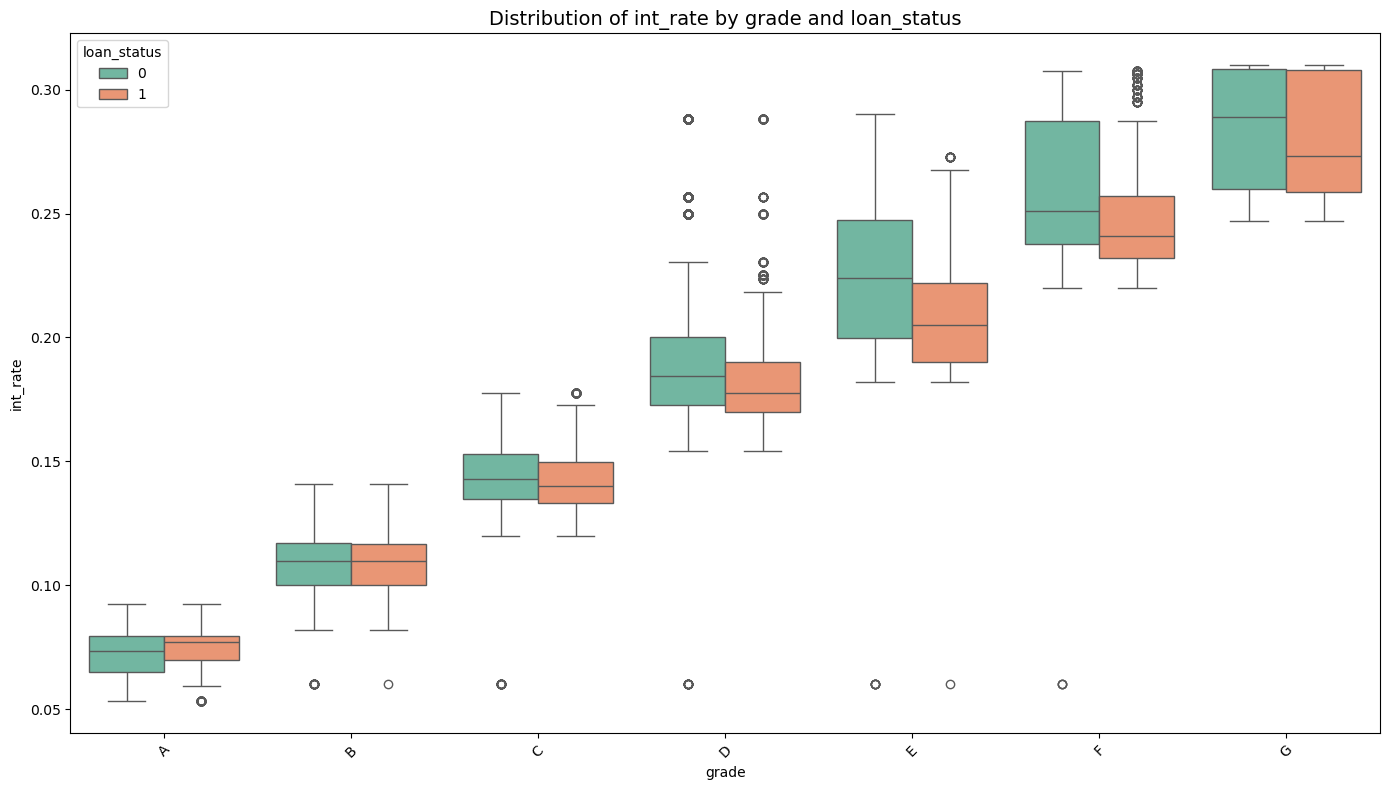

In [18]:
# Interaction of important numerical and categorical variable
# Interest rate and grade
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
merged_df['grade'] = pd.Categorical(merged_df['grade'], categories=grade_order, ordered=True)
plot_num_cat_target_relationship(merged_df, 'int_rate', 'grade', sort_by = 'grade')

It is clearly evident that customers assigned to lower 'grade' categories are charged higher interest rates, reflecting the higher risk associated with these borrowers, but the interest rate itself does not appear to significantly separate defaulted from non-defaulted loans within the same grade.

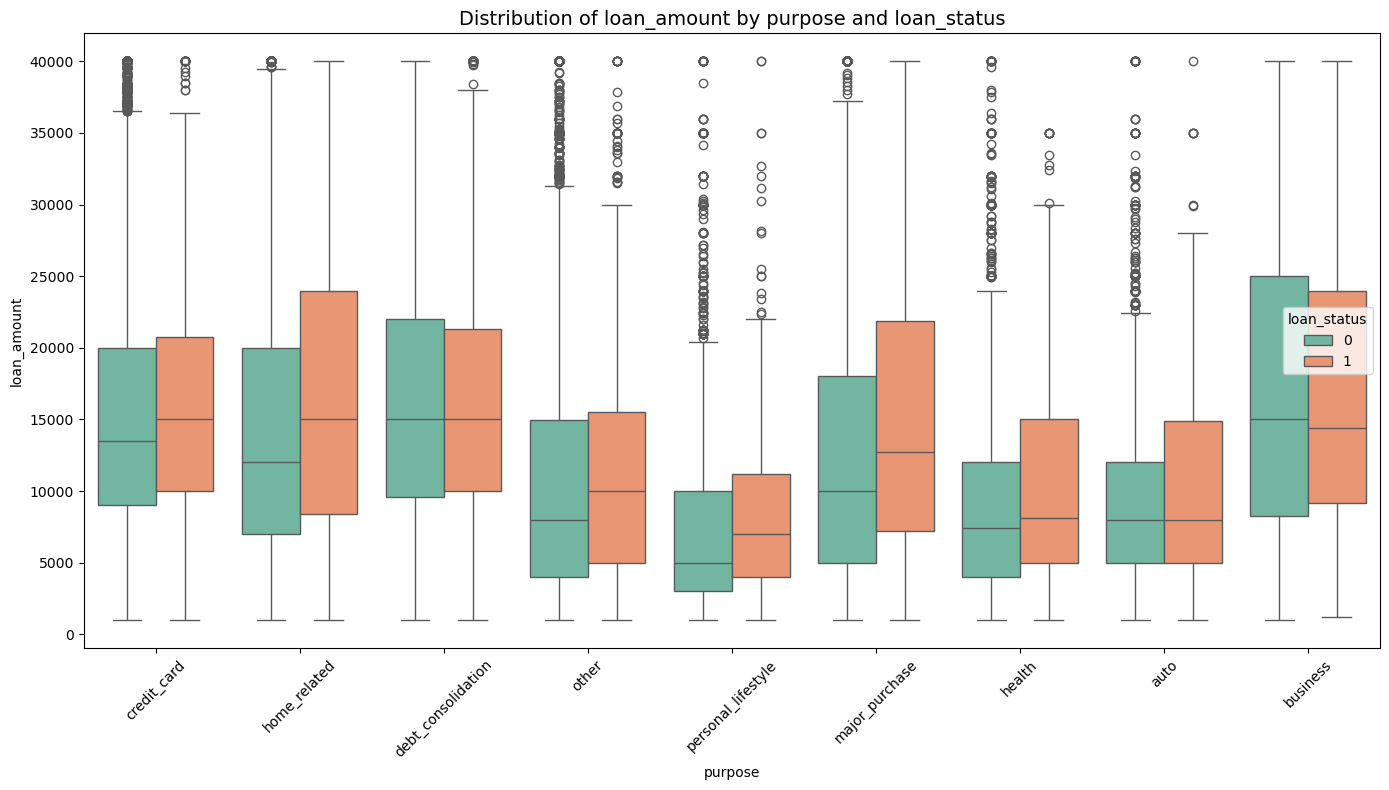

In [19]:
# Loan amount and purpose
plot_num_cat_target_relationship(merged_df, 'loan_amount', 'purpose')

While there is overlap in the distributions, the upward shift in the central tendency (median and IQR) for defaulted loans is a notable pattern. This suggests that, regardless of the loan's purpose, a higher loan amount might be associated with an increased risk of default. 

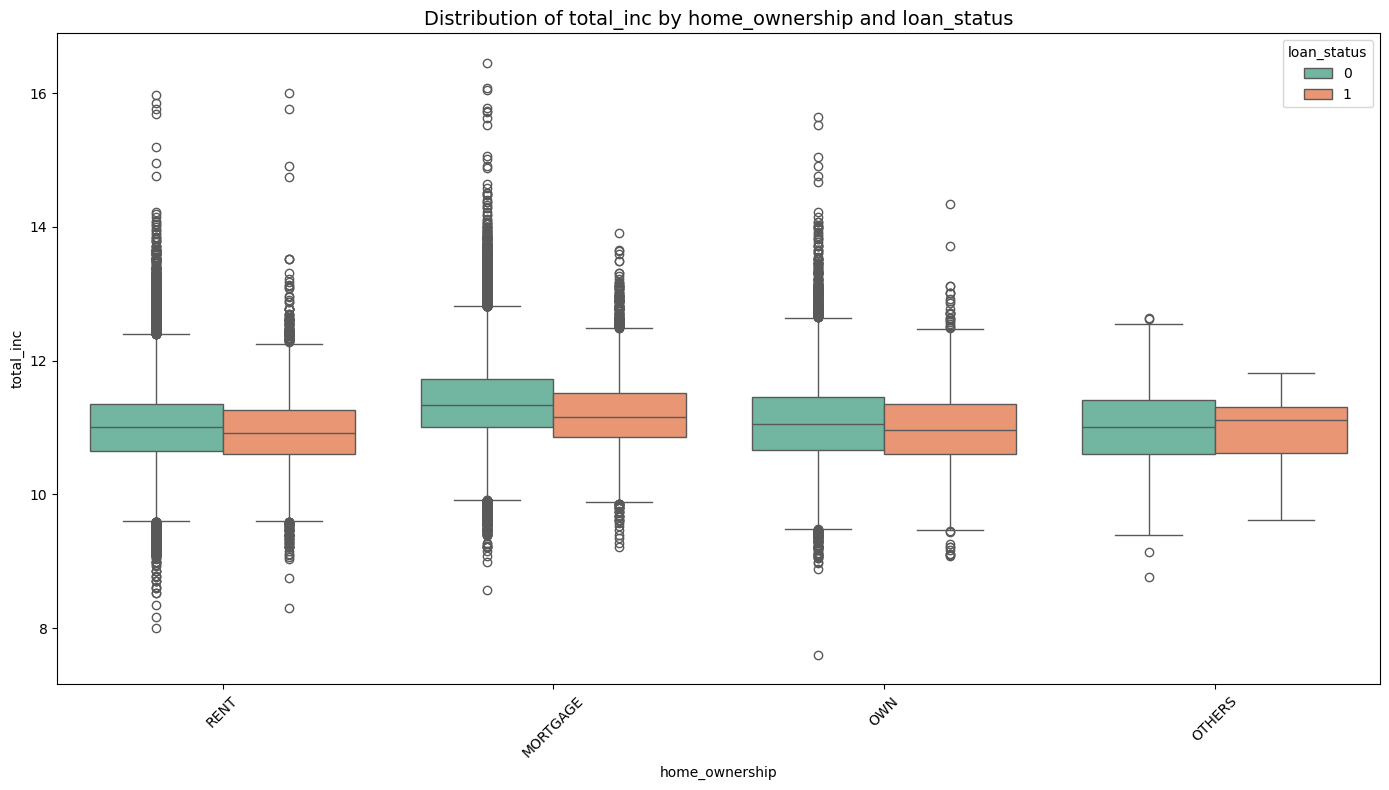

In [21]:
# Total income and home ownership
df1 = merged_df.copy()
df1['total_inc'] = np.log(df1['total_inc']).fillna(-1) # Log transformation to reduce the skewness
plot_num_cat_target_relationship(df1, 'total_inc', 'home_ownership')

While income is often considered a key factor in creditworthiness, this visualization suggests that in this dataset, total_inc itself might not be a primary driver distinguishing defaulted from non-defaulted loans within specific home ownership groups. Other factors are likely more influential in determining loan status.

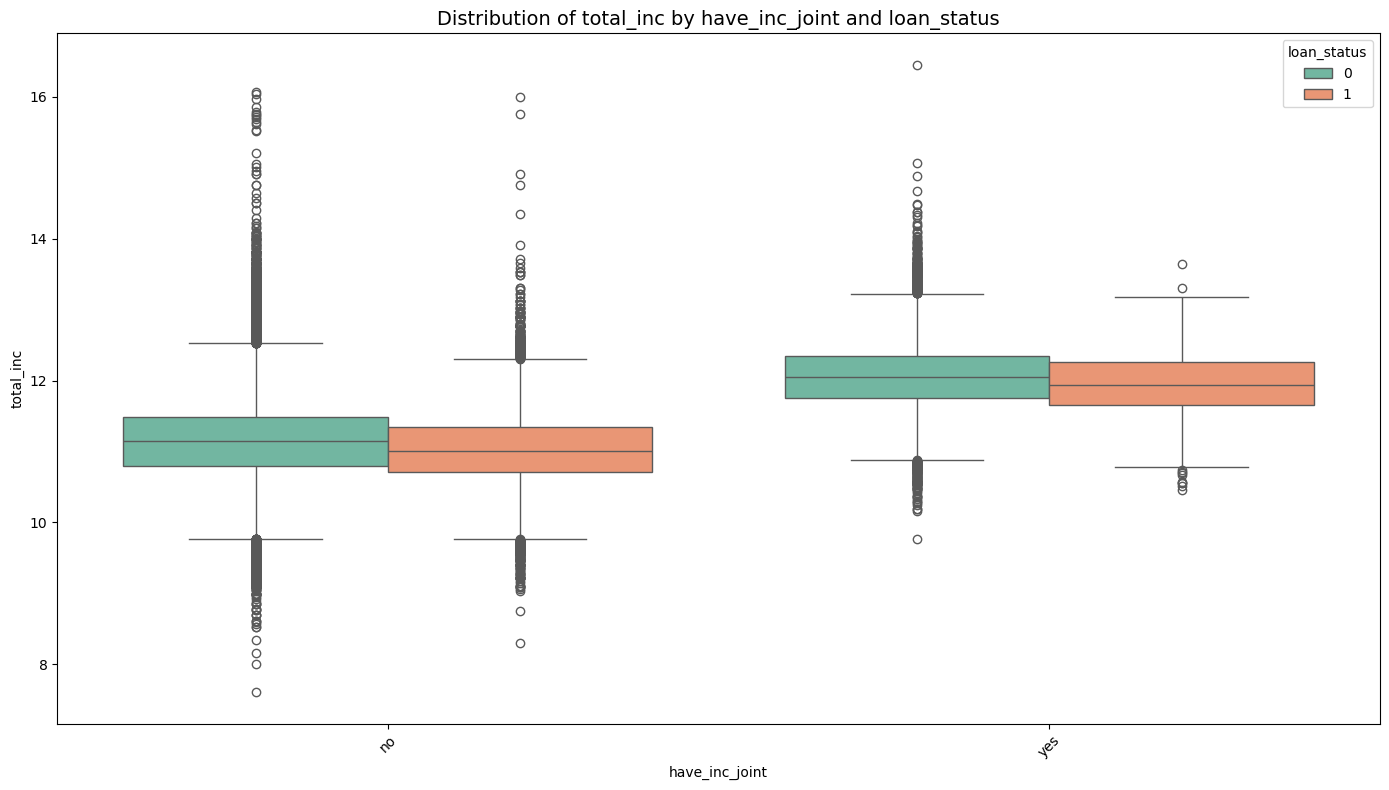

In [20]:
# total_inc and have_inc_joint
df1 = merged_df.copy()
df1['total_inc'] = np.log(df1['total_inc']).fillna(-1) # Log transformation to reduce the skewness
plot_num_cat_target_relationship(df1, 'total_inc', 'have_inc_joint')

While the presence of joint income is strongly associated with higher total income levels, the total income itself, whether individual or joint, does not appear to be a primary factor distinguishing defaulted from non-defaulted loans in this dataset.

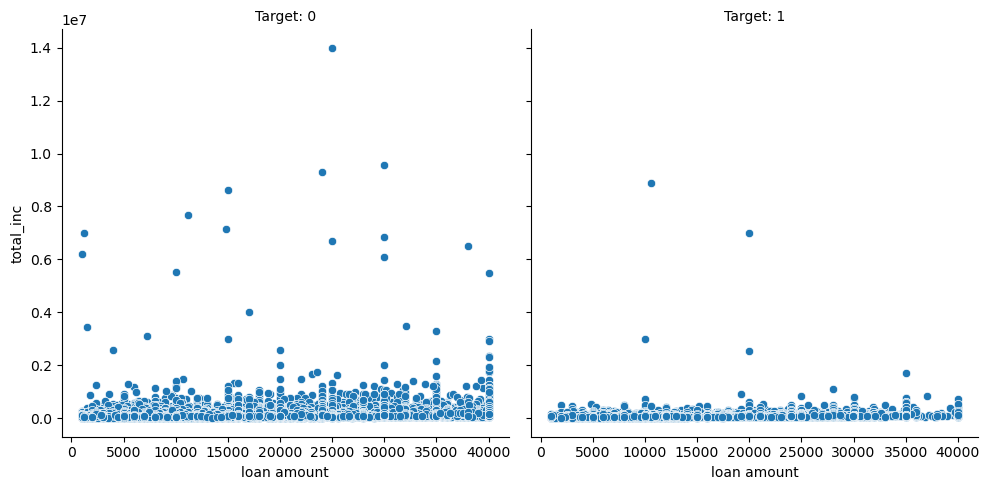

In [22]:
g = sns.FacetGrid(merged_df, col=tar_col, height=5, aspect=1)
g.map(sns.scatterplot, 'loan_amount', 'total_inc')
g.set_axis_labels('loan amount', 'total_inc')
g.set_titles(col_template='Target: {col_name}')
plt.tight_layout()
plt.show()

Although the distribution between the two classes does not show significant differences, it can be observed that higher income is associated with lower default risk. Therefore, creating a few new variables may help to further explore this relationship.

#### 2.4.4 Feature interaction analysis

Based on the available columns, calculate and create some new columns.

In [97]:
# Debt-to-Income ratio (monthly installment divided by income)
merged_df['dti'] = merged_df['installment'] / merged_df['total_inc']

# Loan-to-Income ratio
merged_df['lti'] = merged_df['loan_amount'] / merged_df['total_inc']

# Interest burden (int_rate is the annual interest rate, and total_inc is the total annual income)
merged_df['interest_burden'] = merged_df['int_rate'] * merged_df['loan_amount'] / merged_df['total_inc']

# Current balance to loan amount ratio
merged_df['bal_to_loan'] = merged_df['avg_cur_bal'] / merged_df['loan_amount']

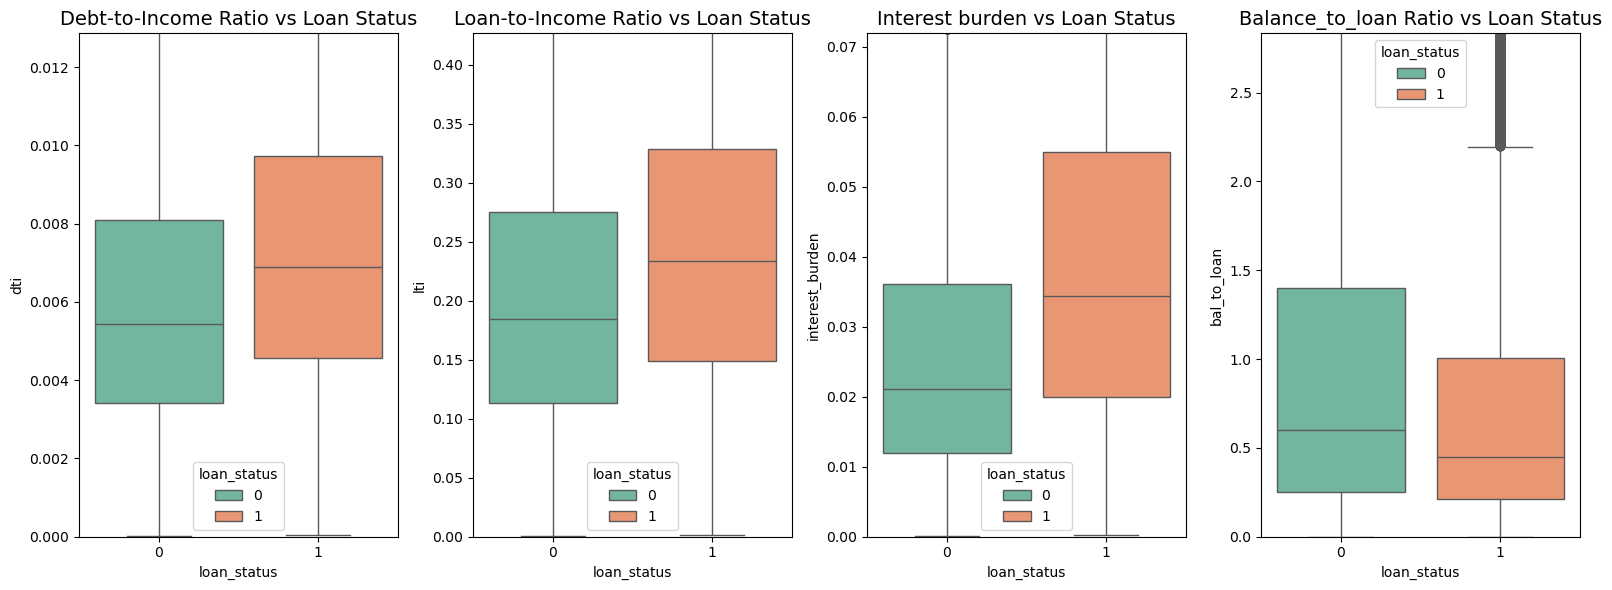

In [16]:
# Visualize these interaction features against the target
plt.figure(figsize=(16, 6))

plt.subplot(1, 4, 1)
sns.boxplot(x='loan_status', y='dti', data=merged_df, hue='loan_status', palette='Set2')
plt.title('Debt-to-Income Ratio vs Loan Status', fontsize=14)
plt.ylim(0, merged_df['dti'].quantile(0.95))  # Limit y-axis to remove outliers

plt.subplot(1, 4, 2)
sns.boxplot(x='loan_status', y='lti', data=merged_df, hue='loan_status', palette='Set2')
plt.title('Loan-to-Income Ratio vs Loan Status', fontsize=14) 
plt.ylim(0, merged_df['lti'].quantile(0.95))  # Limit y-axis to remove outliers

plt.subplot(1, 4, 3)
sns.boxplot(x='loan_status', y='interest_burden', data=merged_df, hue='loan_status', palette='Set2')
plt.title('Interest burden vs Loan Status', fontsize=14) 
plt.ylim(0, merged_df['interest_burden'].quantile(0.95))  # Limit y-axis to remove outliers

plt.subplot(1, 4, 4)
bal_to_loan_upper_limit = merged_df['bal_to_loan'].quantile(0.9) 
sns.boxplot(x='loan_status', y='bal_to_loan', data=merged_df, hue='loan_status', palette='Set2')
plt.title('Balance_to_loan Ratio vs Loan Status', fontsize=14) 
plt.ylim(0, bal_to_loan_upper_limit)

plt.tight_layout()
plt.show()

Borrowers with a higher 'dti', 'lti' or 'interest_burden' might be at a slightly increased risk of default.

Borrowers with a lower 'bal_to_loan' reflecting that many are paid down or off while higher indicating that a substantial portion of the original loan amount remains outstanding at the time of default. While this is a strong differentiator, it's important to note that this ratio captures the outcome state for defaulted loans rather than being a purely predictive input representing the state before default.

In conclusion, 'lti' and 'Interest Burden' appear to be particularly powerful features for predicting loan status, exhibiting clear separation in their distributions between defaulted and non-defaulted loans. 'dti' also shows a relationship, albeit less pronounced than 'lti' and 'Interest Burden'. The 'bal_to_loan' ratio confirms the state of defaulted loans but should be used carefully as a predictor depending on the modeling context.

#### 2.4.5 3D visualization for three variable relationships

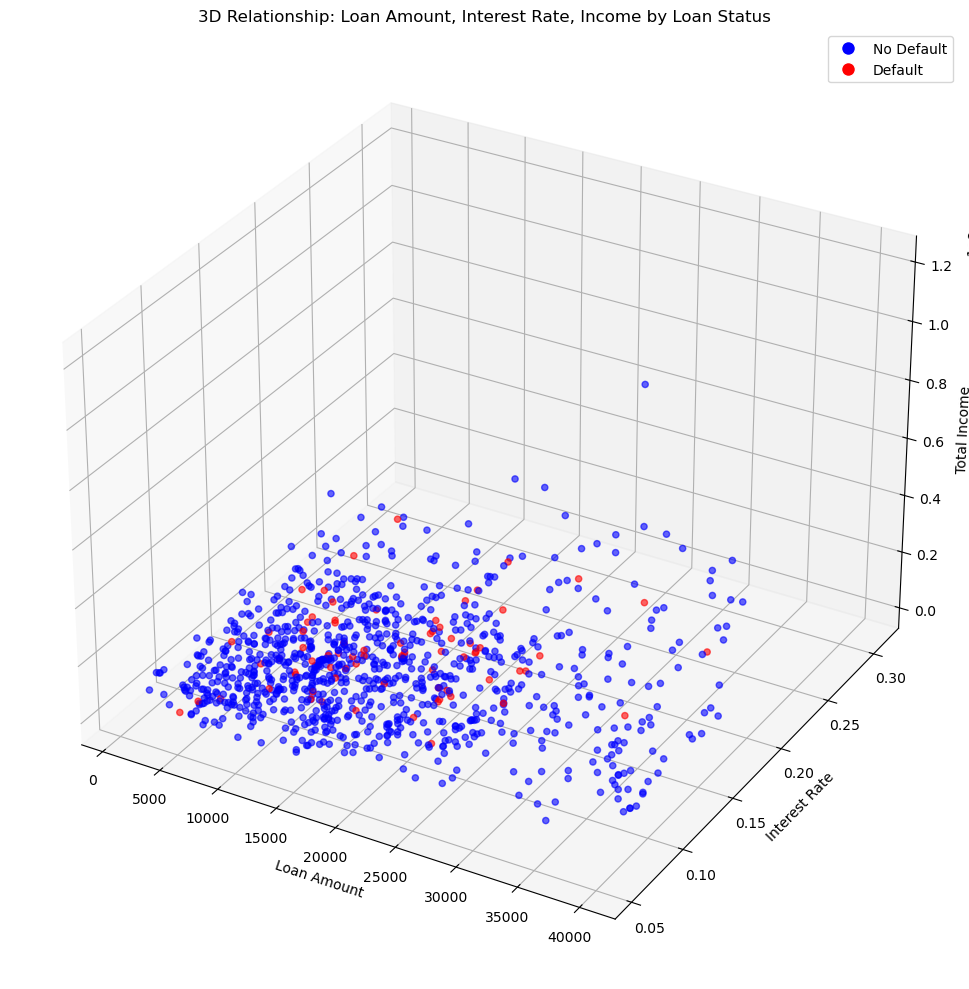

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample data to avoid overcrowding (optional)
sample_df = merged_df.sample(min(1000, len(merged_df)), random_state=42)

# Color mapping for target variable
colors = {0: 'blue', 1: 'red'}  # Assuming binary target: 0=no default, 1=default
scatter = ax.scatter(
    sample_df['loan_amount'], 
    sample_df['int_rate'], 
    sample_df['total_inc'],
    c=[colors[val] for val in sample_df['loan_status']],
    alpha=0.6
)

ax.set_xlabel('Loan Amount')
ax.set_ylabel('Interest Rate')
ax.set_zlabel('Total Income')
ax.set_title('3D Relationship: Loan Amount, Interest Rate, Income by Loan Status')

# Create legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', label='No Default', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Default', markersize=10)
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [25]:
df_clean = merged_df.copy()
outlier_stats = {}

In [26]:
# Get numerical columns excluding target
num_cols = ['emp_length', 'avg_cur_bal', 'Tot_cur_bal', 'loan_amount', 'int_rate', 'installment', 'issue_month', 'issue_quarter', 'issue_year_num', 'total_inc']

In [27]:
# Filter out date/time related features for outlier treatment
cols_to_process = [col for col in num_cols if col not in ['issue_month', 'issue_quarter', 'issue_year_num']]

Because the datasets contain skewed distributions -> use IQR method to handle outliers

In [28]:
# Calculate number of rows and columns needed for the subplot grid
n_cols = min(3, len(cols_to_process))
n_rows = (len(cols_to_process) + n_cols - 1) // n_cols  # Ceiling division

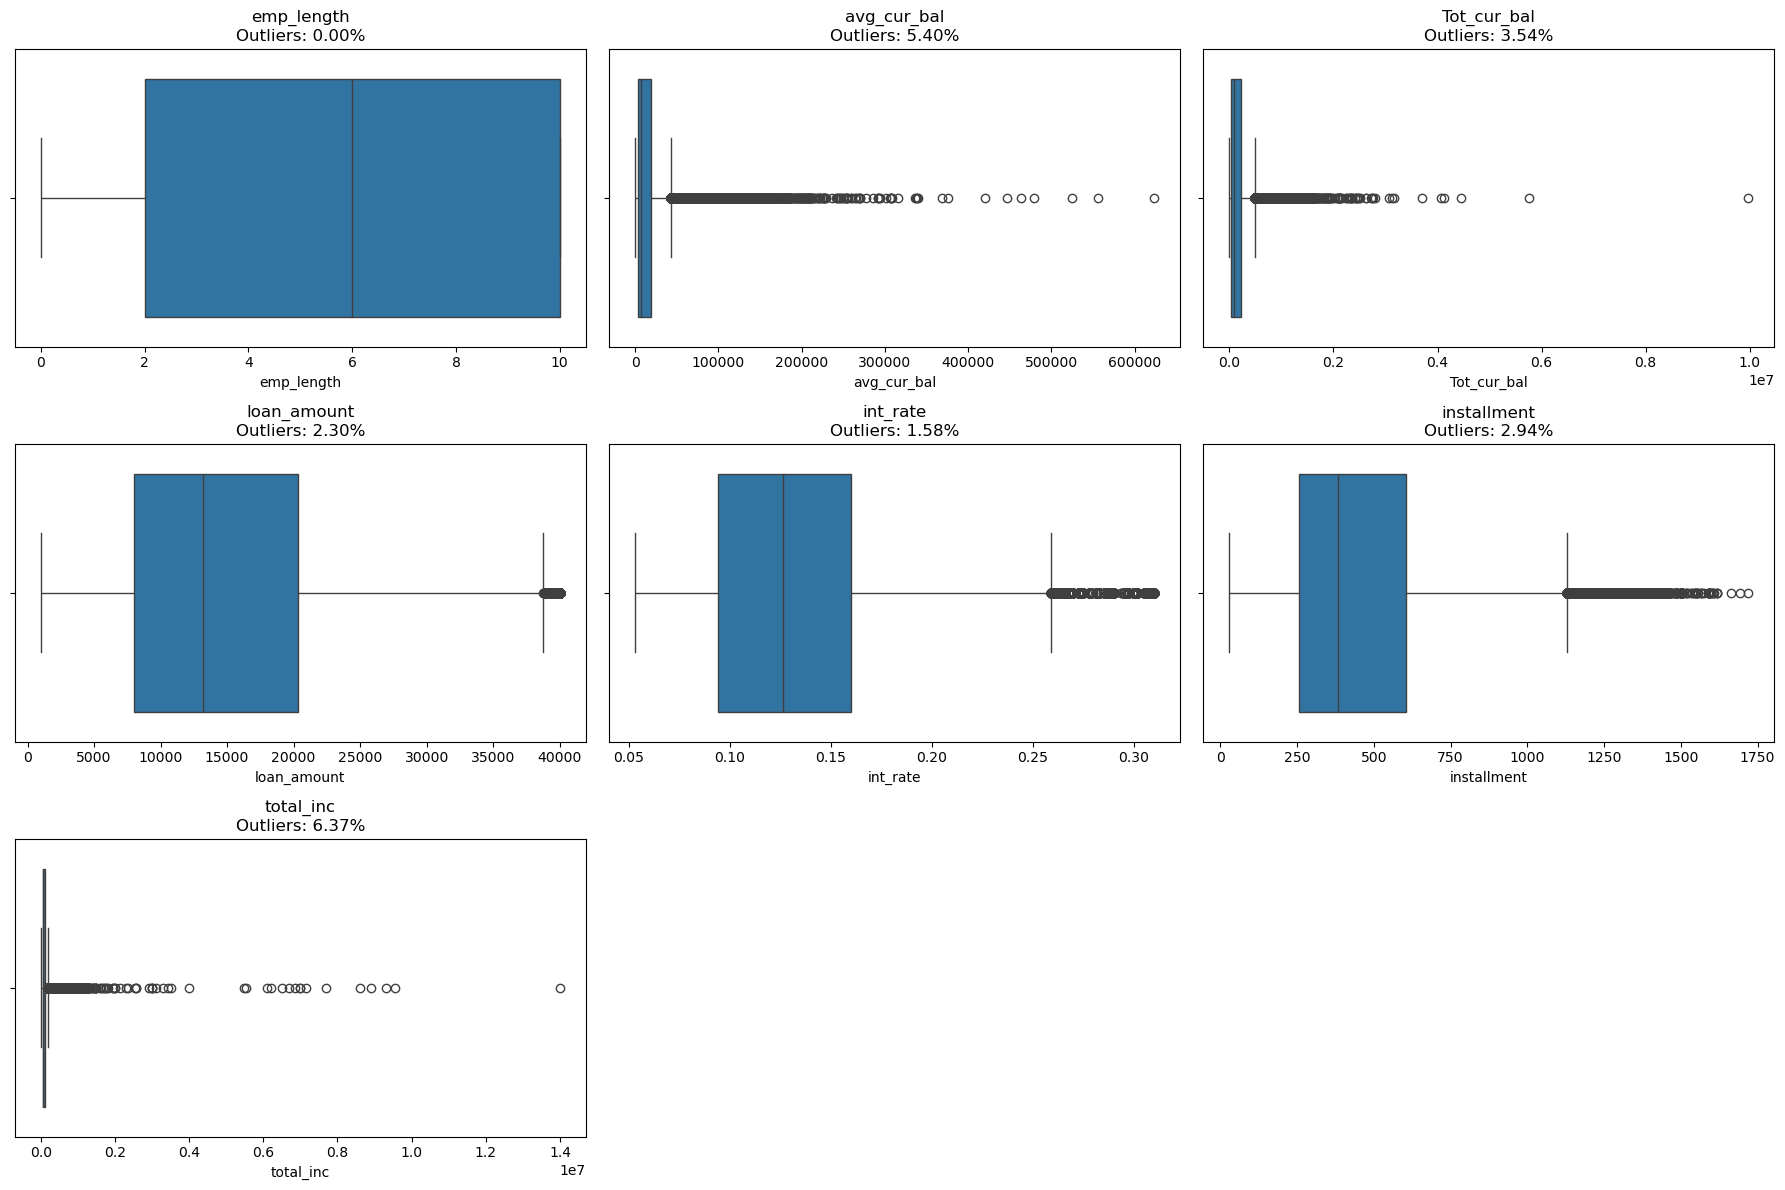

In [29]:
plt.figure(figsize=(18, n_rows * 4))
        
for i, col in enumerate(cols_to_process):
    # Calculate outlier boundaries
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
                
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_percentage = len(outliers) / len(df_clean) * 100
                
    # Store stats for reporting
    outlier_stats[col] = {
        'count': len(outliers),
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
                
    # Plot boxplot to visualize outliers - using 1-based indexing for subplot
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=df_clean[col])
    plt.title(f"{col}\nOutliers: {outlier_percentage:.2f}%")
    
    # Cap the outliers instead of removing them
    df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)

plt.tight_layout()
plt.show()

Recalculate some features after handling outliers.

In [30]:
df_clean['dti'] = df_clean['installment'] / df_clean['total_inc']
df_clean['lti'] = df_clean['loan_amount'] / df_clean['total_inc']
df_clean['interest_burden'] = df_clean['int_rate'] * df_clean['loan_amount'] / df_clean['total_inc']
df_clean['bal_to_loan'] = df_clean['avg_cur_bal'] / df_clean['loan_amount']

### 3.1 Feature Engineering and Selection

#### ** Feature Engineering

In [98]:
# Create new categorical feature
merged_df['grade_term'] = merged_df['grade'].astype(str) + '_' + merged_df['term'].astype(str)
merged_df['purpose_home'] = merged_df['purpose'] + '_' + merged_df['home_ownership']

Assess the change in the distribution of the 'emp_length' variable after filling missing values with the median.

In [30]:
# percentage of null
merged_df['emp_length'].isna().sum()/len(merged_df)

0.06934912818767365

In [31]:
# percentage of median
(merged_df['emp_length'] == merged_df['emp_length'].median()).sum()/len(merged_df)

0.04391433190651834

<Axes: >

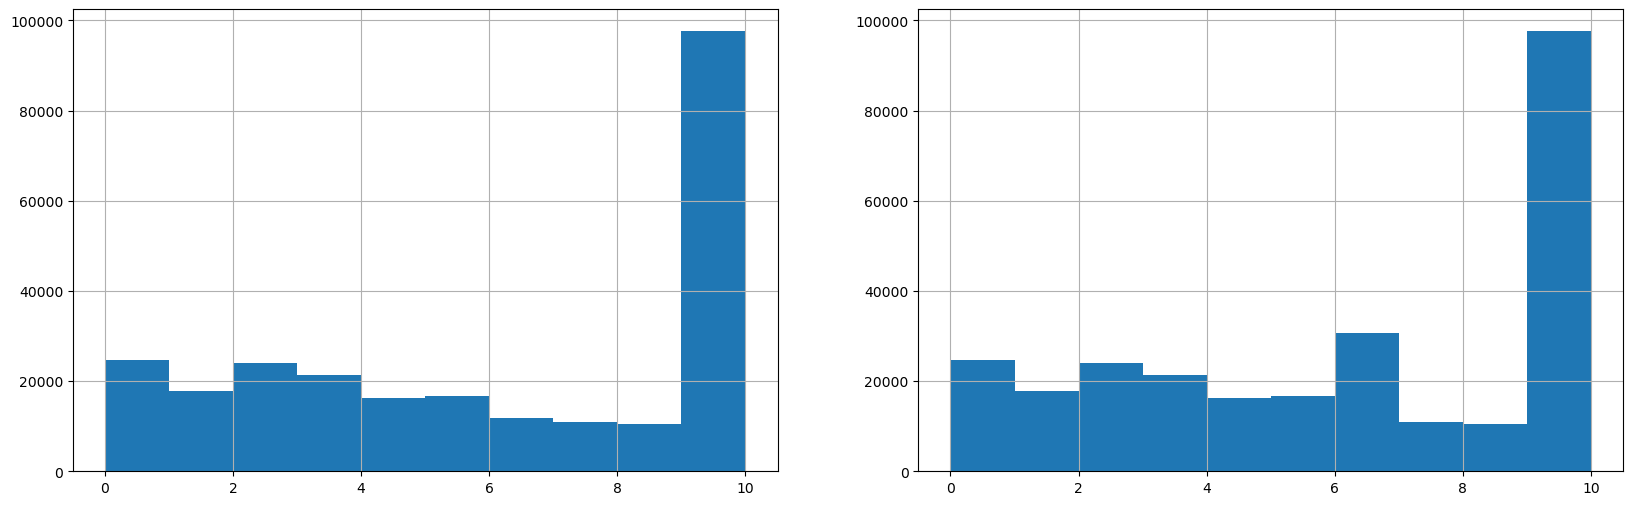

In [32]:
# Comparison of distribution change from simple impute
f, axs = plt.subplots(1,2, figsize=(20, 6))
merged_df['emp_length'].hist(ax=axs[0])
merged_df['emp_length'].fillna(merged_df['emp_length'].median()).hist(ax=axs[1])

The 'emp_length' column contains approximately 7% missing data. Filling these missing values with the median causes the percentage of the median value to increase from 4.3% to 11%.

#### ** Preprocessing for feature evaluation

In [124]:
num_cols = merged_df.select_dtypes(include='number').columns.tolist()
num_cols.remove(tar_col)
cat_cols = merged_df.select_dtypes(exclude='number').columns.tolist()

In [125]:
X = merged_df[num_cols + cat_cols]
y = merged_df[tar_col]
X.shape, y.shape

((270299, 26), (270299,))

In [126]:
# Train-test split for evaluation - use stratified split for better representation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (189209, 26), Test set: (81090, 26)


In [128]:
# Split features by type
cat = [col for col in cat_cols if col != 'grade']
ordinal_cat = ['grade']  

# Define ordinal mapping for grade
grade_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [129]:
# Create preprocessing steps for numerical and categorical features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())                    
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[grade_categories]))
])

# Create column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat),
        ('ord_cat', ordinal_cat_transformer, ordinal_cat)
    ],
    verbose_feature_names_out=False  # Use simpler feature names
)

In [130]:
X_train_pc = preprocessor.fit_transform(X_train, y_train)  
X_test_pc = preprocessor.transform(X_test)

In [131]:
feature_names = preprocessor.get_feature_names_out()

**Implements multiple feature selection methods and compares them:**

- Univariate Selection (ANOVA F-test): Identifies features with strong individual relationships to the target

- Mutual Information: Captures non-linear relationships between features and target

- Recursive Feature Elimination: Iteratively removes less important features

- Model-based Feature Importance: Uses Random Forest to rank features by importance

#### ** Method 1: Univariate Selection with optimization

In [132]:
selected_features = {}

In [133]:
k_features = min(20, X_train_pc.shape[1])
selector = SelectKBest(f_classif, k=k_features)

In [134]:
# Fit on the data
selector.fit(X_train_pc, y_train)

SelectKBest(k=20)

In [135]:
# Get selected feature names 
feature_indices = selector.get_support(indices=True)
selected_features_uni = [feature_names[i] for i in feature_indices]
selected_features['univariate'] = selected_features_uni

In [136]:
# Transform the data
X_train_selected = selector.transform(X_train_pc)
X_test_selected = selector.transform(X_test_pc)

In [137]:
# Train a simple model to evaluate
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [138]:
print("\n--- UNIVARIATE SELECTION (ANOVA F-TEST) ---")
print(f"Selected features: {len(selected_features_uni)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)
        
print("Top 20 features:")
print(feature_scores.head(20))


--- UNIVARIATE SELECTION (ANOVA F-TEST) ---
Selected features: 20
ROC-AUC Score: 0.7344
Top 20 features:
                              Feature        Score
116                             grade  8339.491865
8                      issue_year_num  7443.779244
4                            int_rate  5664.313617
12                    interest_burden  4673.245643
66            grade_term_A_ 36 months  2245.658821
75            grade_term_E_ 60 months  2003.617714
10                                dti  1545.357933
77            grade_term_F_ 60 months  1503.888983
11                                lti  1359.632184
18   verification_status_Not Verified  1208.189282
20       verification_status_Verified  1071.102471
40                    term_ 60 months   799.644773
39                    term_ 36 months   799.644773
72            grade_term_D_ 36 months   614.815439
79            grade_term_G_ 60 months   601.863505
74            grade_term_E_ 36 months   554.882823
68            grade_term_B_

#### ** Method 2: Mutual Information - optimize computation

In [139]:
# Use a smaller subset for mutual info because dataset is large
if X_train_pc.shape[0] > 50000:
    print("Using a subset of data for mutual information calculation")
    subset_indices = np.random.choice(X_train_pc.shape[0], 50000, replace=False)
    X_subset = X_train_pc[subset_indices]
    y_subset = y_train.iloc[subset_indices] if hasattr(y_train, 'iloc') else y_train[subset_indices]
    selector = SelectKBest(mutual_info_classif, k=k_features)
    selector.fit(X_subset, y_subset)
else:
    selector = SelectKBest(mutual_info_classif, k=k_features)
    selector.fit(X_train_pc, y_train)

Using a subset of data for mutual information calculation


In [140]:
# Get selected feature names
feature_indices = selector.get_support(indices=True)
selected_features_mi = [feature_names[i] for i in feature_indices]
selected_features['mutual_info'] = selected_features_mi

In [141]:
# Transform the data
X_train_selected = selector.transform(X_train_pc)
X_test_selected = selector.transform(X_test_pc)

In [142]:
# Train a simple model to evaluate
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [143]:
print("\n--- MUTUAL INFORMATION SELECTION ---")
print(f"Selected features: {len(selected_features_mi)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)
        
print("Top 20 features:")
print(feature_scores.head(20))


--- MUTUAL INFORMATION SELECTION ---
Selected features: 20
ROC-AUC Score: 0.7441
Top 20 features:
                                 Feature     Score
4                               int_rate  0.037349
8                         issue_year_num  0.028579
116                                grade  0.022773
12                       interest_burden  0.012603
5                            installment  0.011944
41                      pymnt_plan_False  0.011867
39                       term_ 36 months  0.010266
44                       type_INDIVIDUAL  0.009061
10                                   dti  0.008720
66               grade_term_A_ 36 months  0.007981
49            purpose_debt_consolidation  0.007726
14               home_ownership_MORTGAGE  0.007057
18      verification_status_Not Verified  0.006872
11                                   lti  0.006040
64                     have_inc_joint_no  0.005948
3                            loan_amount  0.005490
40                       term_ 60 

#### ** Method 3: Recursive Feature Elimination - OPTIMIZED

In [144]:
# Use a subset of data for RFE because dataset is large
sample_size_rfe = min(20000, X_train_pc.shape[0])  
if X_train_pc.shape[0] > sample_size_rfe:
    print(f"Using a sample of {sample_size_rfe} records for RFE")
    indices = np.random.choice(X_train_pc.shape[0], sample_size_rfe, replace=False)
    X_rfe = X_train_pc[indices]
    y_rfe = y_train.iloc[indices] if hasattr(y_train, 'iloc') else y_train[indices]
else:
    X_rfe = X_train_pc
    y_rfe = y_train

Using a sample of 20000 records for RFE


In [145]:
# Use a faster model for RFE
estimator = RandomForestClassifier(
    n_estimators=50,  # Reduce number of trees
    max_depth=10,     # Limit tree depth
    random_state=42,
    n_jobs=-1         # Use all CPU cores
        )

In [146]:
# Use a larger step size for RFE to remove more features at each step
k_features = min(20, X_train_pc.shape[1])
step_size = max(1, X_train_pc.shape[1] // 20)  # Remove 5% of features at each step
        
print(f"RFE step size: {step_size} features per iteration")
selector = RFE(
    estimator, 
    n_features_to_select=k_features, 
    step=step_size,
    verbose=1  # Show progress
        )

RFE step size: 5 features per iteration


In [147]:
# Fit RFE
selector.fit(X_rfe, y_rfe)

Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
Fitting estimator with 97 features.
Fitting estimator with 92 features.
Fitting estimator with 87 features.
Fitting estimator with 82 features.
Fitting estimator with 77 features.
Fitting estimator with 72 features.
Fitting estimator with 67 features.
Fitting estimator with 62 features.
Fitting estimator with 57 features.
Fitting estimator with 52 features.
Fitting estimator with 47 features.
Fitting estimator with 42 features.
Fitting estimator with 37 features.
Fitting estimator with 32 features.
Fitting estimator with 27 features.
Fitting estimator with 22 features.


RFE(estimator=RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1,
                                     random_state=42),
    n_features_to_select=20, step=5, verbose=1)

In [148]:
# Get selected feature names
feature_indices = selector.get_support(indices=True)
selected_features_rfe = [feature_names[i] for i in feature_indices]
selected_features['rfe'] = selected_features_rfe

In [151]:
# Transform full dataset with selected features
X_train_selected = selector.transform(X_train_pc)
X_test_selected = selector.transform(X_test_pc)

In [152]:
# Train a model to evaluate
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

In [153]:
print("\n--- RECURSIVE FEATURE ELIMINATION ---")
print(f"Selected features: {len(selected_features_rfe)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
print("Selected features:")
print(selected_features_rfe)


--- RECURSIVE FEATURE ELIMINATION ---
Selected features: 20
ROC-AUC Score: 0.7686
Selected features:
['emp_length', 'avg_cur_bal', 'Tot_cur_bal', 'loan_amount', 'int_rate', 'installment', 'issue_month', 'issue_quarter', 'issue_year_num', 'total_inc', 'dti', 'lti', 'interest_burden', 'bal_to_loan', 'verification_status_Not Verified', 'verification_status_Verified', 'grade_term_A_ 36 months', 'grade_term_E_ 60 months', 'grade_term_F_ 60 months', 'grade']


#### ** Method 4: Model-based Feature Importance - optimize with fewer trees and parallel processing

In [154]:
# Train a faster random forest model
model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,  # Let trees grow fully for better feature importance
    random_state=42,
    n_jobs=-1        # Use all CPU cores
)

In [155]:
# Use sample for model fitting if data is large
if X_train_pc.shape[0] > 50000:
    print("Using a subset of data for model-based feature importance")
    subset_indices = np.random.choice(X_train_pc.shape[0], 50000, replace=False)
    X_subset = X_train_pc[subset_indices]
    y_subset = y_train.iloc[subset_indices] if hasattr(y_train, 'iloc') else y_train[subset_indices]
    model.fit(X_subset, y_subset)
else:
    model.fit(X_train_pc, y_train)

Using a subset of data for model-based feature importance


In [156]:
# Get feature importances
importances = model.feature_importances_
        
# Create a dataframe for visualization
feature_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

In [157]:
# Select top k features
k_features = min(20, X_train_pc.shape[1])
selected_features_rf = feature_imp.head(k_features)['Feature'].tolist()
selected_features['model_based'] = selected_features_rf
        
# Extract selected features
selected_indices = [list(feature_names).index(feat) for feat in selected_features_rf]
X_train_selected = X_train_pc[:, selected_indices]
X_test_selected = X_test_pc[:, selected_indices]

In [158]:
# Train a new model with selected features
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict_proba(X_test_selected)[:,1]

print("\n--- MODEL-BASED FEATURE IMPORTANCE ---")
print(f"Selected features: {len(selected_features_rf)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")
print("Top 15 features by importance:")
print(feature_imp.head(20))

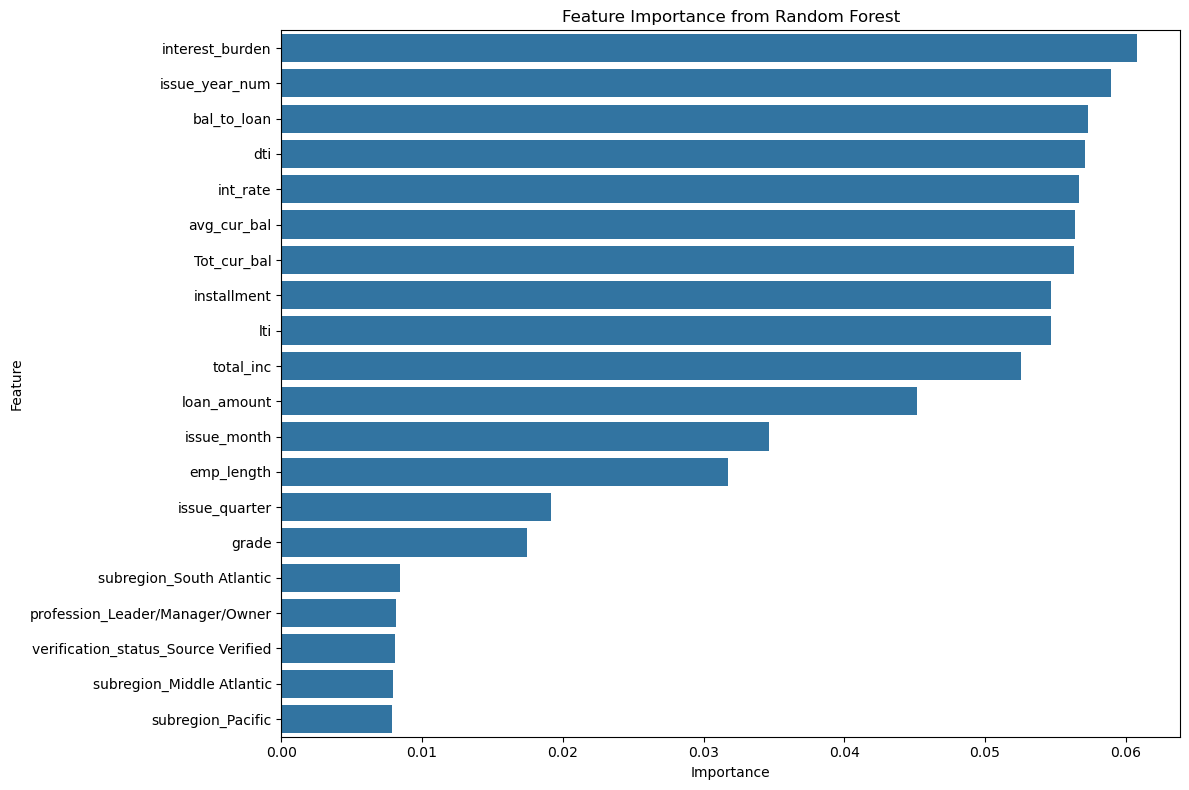

In [159]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
plt.title('Feature Importance from Random Forest')
plt.tight_layout()

#### ** Compare Methods

In [160]:
print("\n--- COMPARING FEATURE SELECTION METHODS ---")
all_selected_features = set()
for method, features in selected_features.items():
    all_selected_features.update(features)
    
comparison = pd.DataFrame(index=list(all_selected_features))
    
for method, features in selected_features.items():
    comparison[method] = [1 if feat in features else 0 for feat in comparison.index]

# Add a count of methods that selected each feature
comparison['Total'] = comparison.sum(axis=1)
comparison = comparison.sort_values('Total', ascending=False)

pd.set_option('display.width', 1000)
print(comparison)


--- COMPARING FEATURE SELECTION METHODS ---
                                     univariate  mutual_info  rfe  model_based  Total
issue_year_num                                1            1    1            1      4
dti                                           1            1    1            1      4
grade                                         1            1    1            1      4
interest_burden                               1            1    1            1      4
int_rate                                      1            1    1            1      4
lti                                           1            1    1            1      4
installment                                   0            1    1            1      3
verification_status_Not Verified              1            1    1            0      3
grade_term_A_ 36 months                       1            1    1            0      3
verification_status_Verified                  1            1    1            0      3
loan_amou

In [161]:
# Recommend the best features (selected by at least 2 methods)
recommended_features = comparison[comparison['Total'] >= 2].index.tolist()
print("\n--- RECOMMENDED FEATURES ---")
print(f"Number of recommended features: {len(recommended_features)}")
print(recommended_features)


--- RECOMMENDED FEATURES ---
Number of recommended features: 23
['issue_year_num', 'dti', 'grade', 'interest_burden', 'int_rate', 'lti', 'installment', 'verification_status_Not Verified', 'grade_term_A_ 36 months', 'verification_status_Verified', 'loan_amount', 'avg_cur_bal', 'bal_to_loan', 'emp_length', 'total_inc', 'grade_term_E_ 60 months', 'issue_month', 'term_ 36 months', 'term_ 60 months', 'grade_term_F_ 60 months', 'Tot_cur_bal', 'verification_status_Source Verified', 'issue_quarter']


### 3.2 Outlier detection and handling

In [162]:
rcm_features = ['interest_burden', 'int_rate', 'grade', 'dti', 'issue_year_num', 'verification_status', 'lti', 'Tot_cur_bal', 'installment', 'avg_cur_bal', 'total_inc', 'issue_quarter', 'grade_term', 'bal_to_loan', 'loan_amount', 'term', 'emp_length', 'issue_month', 'purpose', 'home_ownership', 'issue_quarter']

In [164]:
cat_cols = X_train.select_dtypes(exclude='number')
num_cols = X_train.select_dtypes(include='number')

In [165]:
cat_cols = [col for col in cat_cols if col in rcm_features]
num_cols = [col for col in num_cols if col in rcm_features]
cat_cols, num_cols

(['home_ownership',
  'verification_status',
  'term',
  'grade',
  'purpose',
  'grade_term'],
 ['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'total_inc',
  'dti',
  'lti',
  'interest_burden',
  'bal_to_loan'])

Only handle outlier in train set

In [168]:
X_clean = X_train[num_cols + cat_cols]
X_clean.shape, y_train.shape

((189209, 20), (189209,))

In [169]:
outlier_stats = {}

In [170]:
# Filter out date/time related features and ratio features for outlier treatment
cols_to_process = [col for col in num_cols if col not in ['issue_month', 'issue_quarter', 'issue_year_num', 'dti', 'lti','bal_to_loan', 'interest_burden']]

Because the datasets contain skewed distributions -> use IQR method to handle outliers

In [171]:
# Calculate number of rows and columns needed for the subplot grid
n_cols = min(3, len(cols_to_process))
n_rows = (len(cols_to_process) + n_cols - 1) // n_cols  # Ceiling division

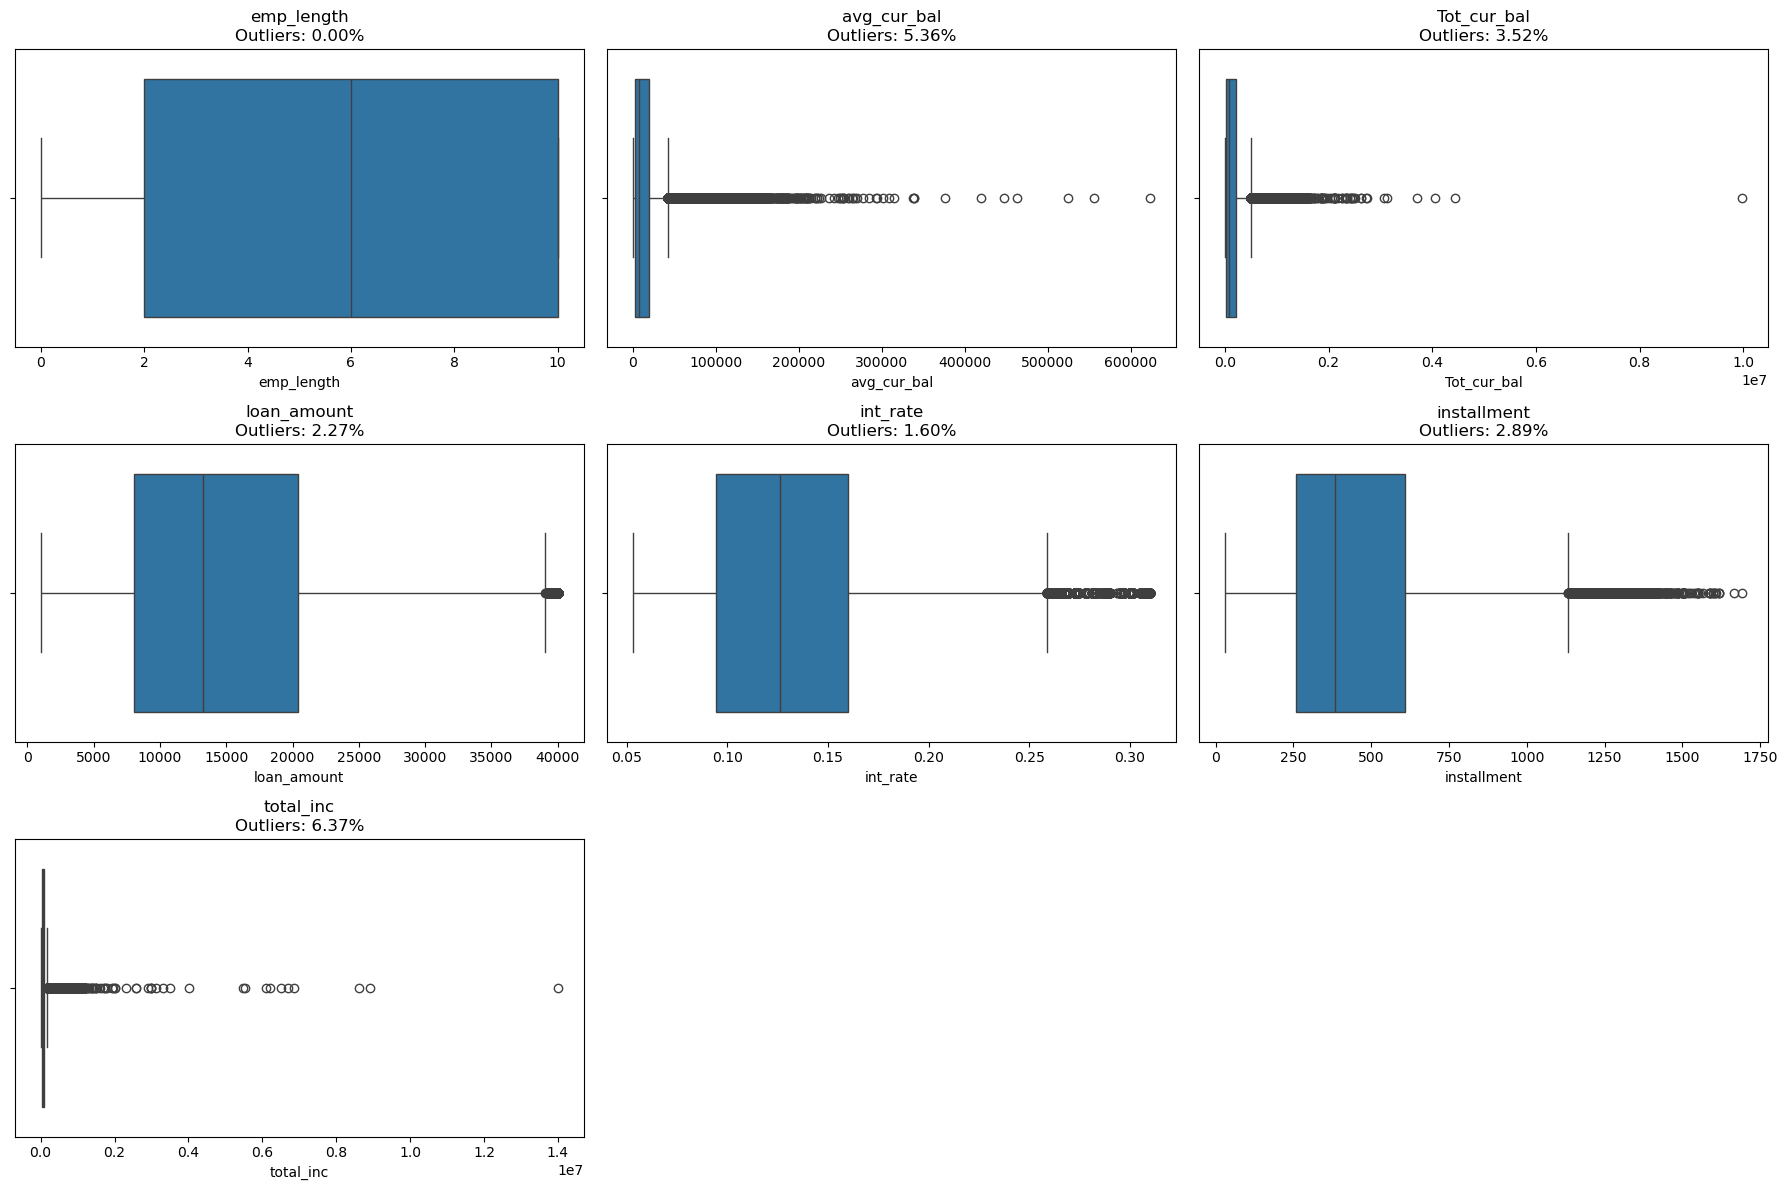

In [172]:
plt.figure(figsize=(18, n_rows * 4))
        
for i, col in enumerate(cols_to_process):
    # Calculate outlier boundaries
    Q1 = X_clean[col].quantile(0.25)
    Q3 = X_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
                
    outliers = X_clean[(X_clean[col] < lower_bound) | (X_clean[col] > upper_bound)]
    outlier_percentage = len(outliers) / len(X_clean) * 100
                
    # Store stats for reporting
    outlier_stats[col] = {
        'count': len(outliers),
        'percentage': outlier_percentage,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
                
    # Plot boxplot to visualize outliers - using 1-based indexing for subplot
    plt.subplot(n_rows, n_cols, i+1)
    sns.boxplot(x=X_clean[col])
    plt.title(f"{col}\nOutliers: {outlier_percentage:.2f}%")
    
    # Cap the outliers instead of removing them
    X_clean[col] = X_clean[col].clip(lower=lower_bound, upper=upper_bound)

plt.tight_layout()
plt.show()

Train set: X_clean, y_train

Test set: X_test, y_test

In [178]:
X_train = X_clean

## 4. Data Pipeline

In [179]:
# Split features by type
cat = [col for col in cat_cols if col != 'grade']
ordinal_cat = ['grade']  

# Define ordinal mapping for grade
grade_categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [180]:
cat, ordinal_cat, num_cols

(['home_ownership', 'verification_status', 'term', 'purpose', 'grade_term'],
 ['grade'],
 ['emp_length',
  'avg_cur_bal',
  'Tot_cur_bal',
  'loan_amount',
  'int_rate',
  'installment',
  'issue_month',
  'issue_quarter',
  'issue_year_num',
  'total_inc',
  'dti',
  'lti',
  'interest_burden',
  'bal_to_loan'])

In [181]:
# Define preprocessing steps
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ordinal_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[grade_categories]))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', cat_pipeline, cat),
        ('ord_cat', ordinal_cat_pipeline, ordinal_cat)
    ]
)

In [182]:
# Fit and transform with the standard preprocessor
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train)  
X_test_preprocessed = preprocessor.transform(X_test)

In [183]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['emp_length', 'avg_cur_bal', 'Tot_cur_bal',
                                  'loan_amount', 'int_rate', 'installment',
                                  'issue_month', 'issue_quarter',
                                  'issue_year_num', 'total_inc', 'dti', 'lti',
                                  'interest_burden', 'bal_to_loan']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['home_ownership', 'verification_status',
                                  'term', 'purpose', 'grade_term']),
                                ('ord_cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['A',
                                                                              'B',
                                                                              'C',
                                                                              'D',
                                                                              'E',
                                                                              'F',
                                                                              'G']]))]),
                                 ['grade'])])

In [184]:
X_train.shape, X_train_preprocessed.shape

((189209, 20), (189209, 47))

## 5. Model Perfomance

**Assess model performance**

In [185]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    
    # ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    # Gini
    gini = 2 * roc_auc - 1
    
    # Precision-Recall AUC
    if y_prob is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
    else:
        pr_auc = None
    
    # Print results
    print(f"\n--- {model_name} Results ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall/Sensitivity: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Gini: {gini:.4f}")
    if pr_auc is not None:
        print(f"PR AUC: {pr_auc:.4f}")

    # Plot 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    
    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Default', 'Default'],
                yticklabels=['Non-Default', 'Default'], ax=axs[0,0])
    axs[0, 0].set_title(f'Confusion Matrix - {model_name}')
    axs[0, 0].set_xlabel('Predicted')
    axs[0, 0].set_ylabel('Actual')
    
    # ROC curve
    if y_prob is not None:
        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_predictions(y_test, y_prob, name=model_name, ax=axs[0, 1])
        axs[0, 1].plot([0, 1], [0, 1], 'k--')
        axs[0, 1].set_xlabel('False Positive Rate')
        axs[0, 1].set_ylabel('True Positive Rate')
        axs[0, 1].set_title(f'ROC Curve - {model_name}')
    
    # Precision-Recall curve
    if y_prob is not None:
        from sklearn.metrics import PrecisionRecallDisplay
        PrecisionRecallDisplay.from_predictions(y_test, y_prob, name=model_name, ax=axs[1, 0])
        axs[1, 0].set_xlabel('Recall')
        axs[1, 0].set_ylabel('Precision')
        axs[1, 0].set_title(f'Precision-Recall Curve - {model_name}')

    # KDE plot
    if y_prob is not None:
        df_rank = pd.DataFrame({
            'label': y_test,
            'score': y_prob
        })
        sns.kdeplot(data=df_rank, x='score', hue='label', common_norm=True, multiple="fill", ax=axs[1, 1])
        axs[1, 1].set_title(f'KDE - {model_name}')
        axs[1, 1].set_xlim(0, 1)
        axs[1, 1].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

    return {
        'model': model_name,
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

**Assess Model Stability**

In [186]:
def calculate_psi(expected, actual, bins=10):
    # Create bins based on the percentiles of the expected distribution
    breakpoints = np.percentile(expected, np.linspace(0, 100, bins + 1))
    # Ensure the breakpoints are unique (in case of duplicate values)
    breakpoints = np.unique(breakpoints)
    
    # Calculate the histogram (bin counts) for expected and actual data
    expected_counts, _ = np.histogram(expected, bins=breakpoints)
    actual_counts, _ = np.histogram(actual, bins=breakpoints)
    
    # Convert counts to percentages
    expected_percents = expected_counts / len(expected)
    actual_percents = actual_counts / len(actual)
    
    # Replace any 0 values with a small number to avoid division by zero or log(0)
    expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
    actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
    
    # Calculate PSI for each bin and sum up
    psi_values = (actual_percents - expected_percents) * np.log(actual_percents / expected_percents)
    psi_value = np.sum(psi_values)
    
    return psi_value

In [187]:
def print_psi(feature, psi_val):
    level = 'LOW'
    if (psi_val > 0.1) & (psi_val <= 0.25):
        level = 'MEDIUM'
    elif psi_val > 0.25:
        level = 'HIGH'
    print(f"PSI for {feature}: {psi_val:.4f} - {level}")

In [188]:
# Calculate PSI for each feature
psi_results = {}

for feature in num_cols:
    psi_results[feature] = calculate_psi(X_train[feature].values, X_test[feature].values, bins=10)

for feature, psi_val in psi_results.items():
    print_psi(feature, psi_val)

PSI for emp_length: 0.0000 - LOW
PSI for avg_cur_bal: 0.0423 - LOW
PSI for Tot_cur_bal: 0.0159 - LOW
PSI for loan_amount: 0.0068 - LOW
PSI for int_rate: 0.0030 - LOW
PSI for installment: 0.0108 - LOW
PSI for issue_month: 0.0002 - LOW
PSI for issue_quarter: 0.0000 - LOW
PSI for issue_year_num: 0.0001 - LOW
PSI for total_inc: 0.0638 - LOW
PSI for dti: 0.0001 - LOW
PSI for lti: 0.0001 - LOW
PSI for interest_burden: 0.0002 - LOW
PSI for bal_to_loan: 0.0003 - LOW


-> Indicates little or no shift in the feature’s distribution between the datasets.

#### # Approach 1: Baseline model without handling imbalance

**Logistic Regression**

In [189]:
baseline_model_logistic = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, class_weight='balanced'))
])

PSI for Prob score: 0.0003 - LOW

--- Baseline Logistic Regression (Class Weights) Results ---
Accuracy: 0.6971
Balanced Accuracy: 0.7071
Precision: 0.1717
Recall/Sensitivity: 0.7190
F1 Score: 0.2773
Matthews Correlation Coefficient: 0.2386
ROC AUC: 0.7694
Gini: 0.5388
PR AUC: 0.2225


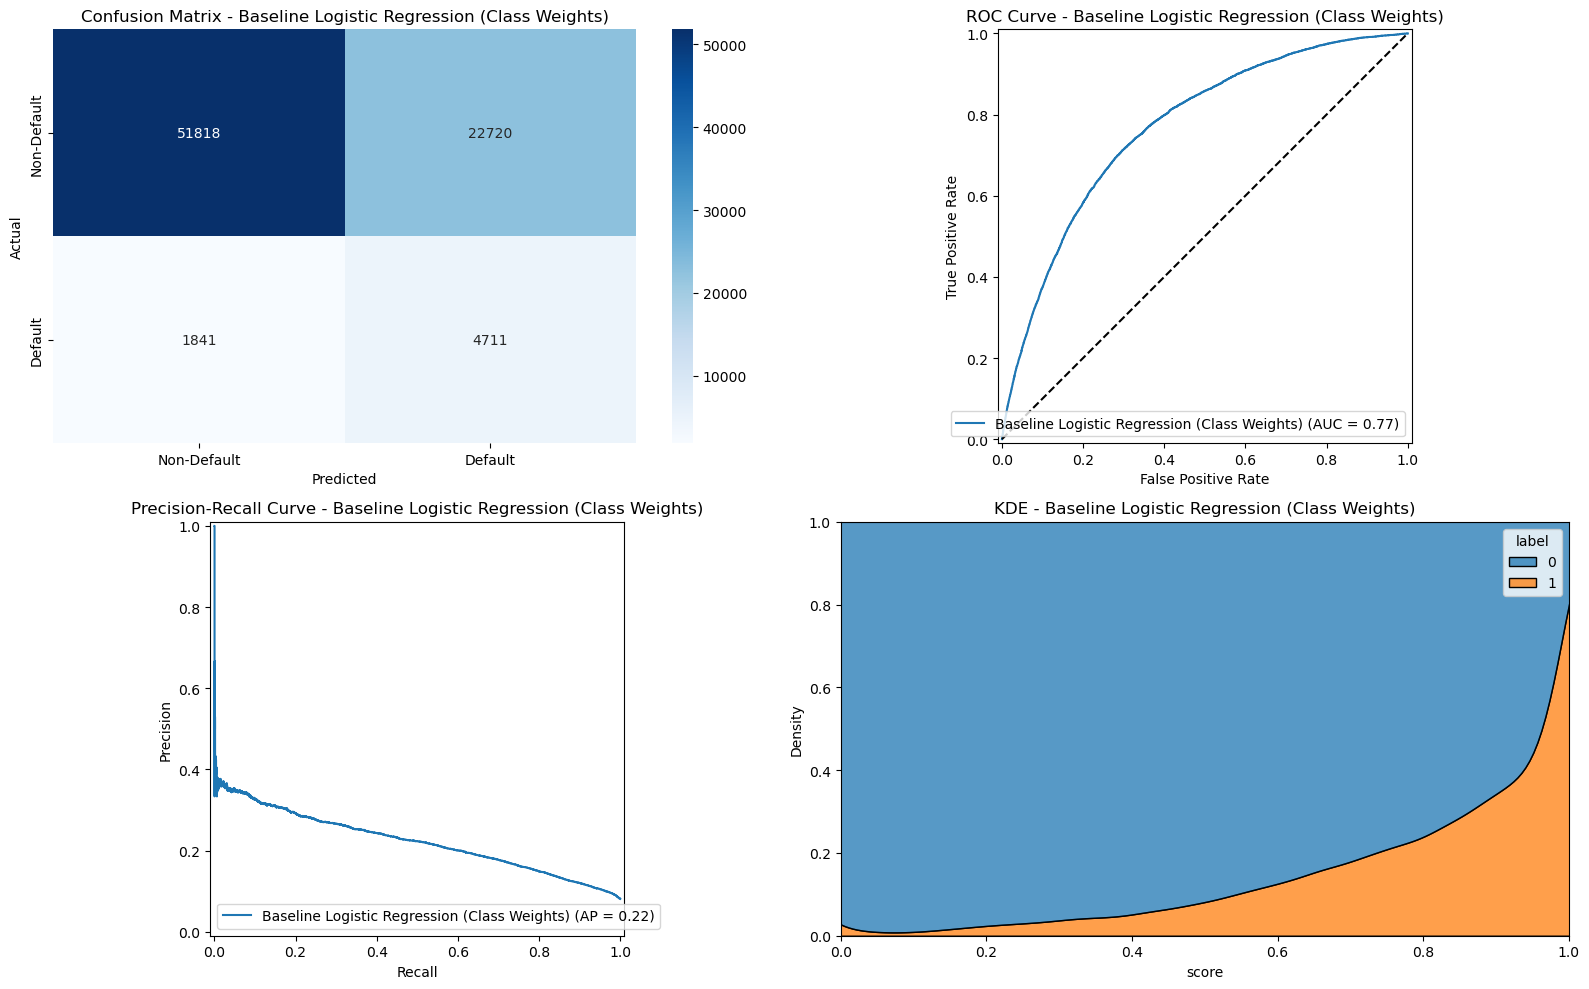

In [190]:
baseline_model_logistic.fit(X_train, y_train)
y_train_prob = baseline_model_logistic.predict_proba(X_train)
y_test_prob = baseline_model_logistic.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
baseline_results_logistic = evaluate_model(baseline_model_logistic, X_test, y_test, "Baseline Logistic Regression (Class Weights)")

In [191]:
# Predict train & test
y_train_pred = baseline_model_logistic.predict(X_train)
y_test_pred = baseline_model_logistic.predict(X_test)

y_train_prob = baseline_model_logistic.predict_proba(X_train)[:, 1]
y_test_prob = baseline_model_logistic.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.2771 | Test: 0.2773
ROC AUC Train: 0.7717 | Test: 0.7694


**Random Forest**

In [192]:
baseline_model_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100, max_depth=None))
])

PSI for Prob score: 0.6704 - HIGH

--- Baseline Random Forest (Class Weights) Results ---
Accuracy: 0.9191
Balanced Accuracy: 0.5051
Precision: 0.4625
Recall/Sensitivity: 0.0113
F1 Score: 0.0221
Matthews Correlation Coefficient: 0.0623
ROC AUC: 0.7659
Gini: 0.5318
PR AUC: 0.2294


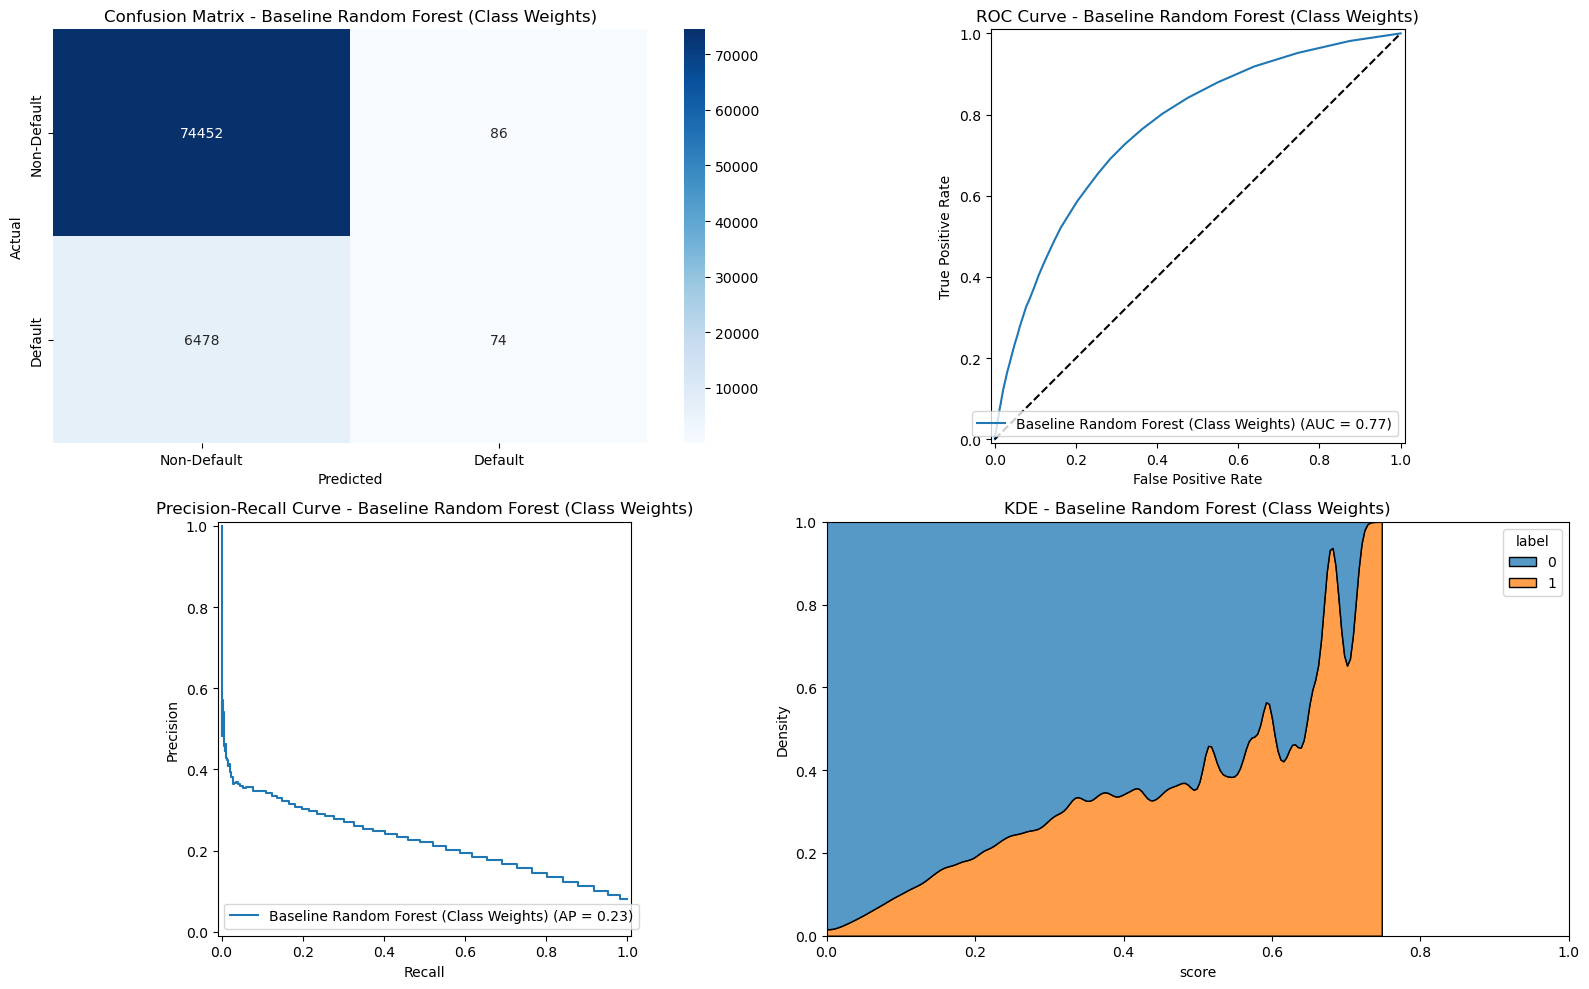

In [193]:
baseline_model_RF.fit(X_train, y_train)
y_train_prob = baseline_model_RF.predict_proba(X_train)
y_test_prob = baseline_model_RF.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
baseline_results_RF = evaluate_model(baseline_model_RF, X_test, y_test, "Baseline Random Forest (Class Weights)")

In [194]:
# Predict train & test
y_train_pred = baseline_model_RF.predict(X_train)
y_test_pred = baseline_model_RF.predict(X_test)

y_train_prob = baseline_model_RF.predict_proba(X_train)[:, 1]
y_test_prob = baseline_model_RF.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.9998 | Test: 0.0221
ROC AUC Train: 1.0000 | Test: 0.7659


**XGBoost**

In [195]:
baseline_model_XGB = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, class_weight='balanced'))
])

PSI for Prob score: 0.0001 - LOW

--- Baseline XGBoost (Class Weights) Results ---
Accuracy: 0.9184
Balanced Accuracy: 0.5104
Precision: 0.4167
Recall/Sensitivity: 0.0237
F1 Score: 0.0448
Matthews Correlation Coefficient: 0.0837
ROC AUC: 0.7900
Gini: 0.5800
PR AUC: 0.2415


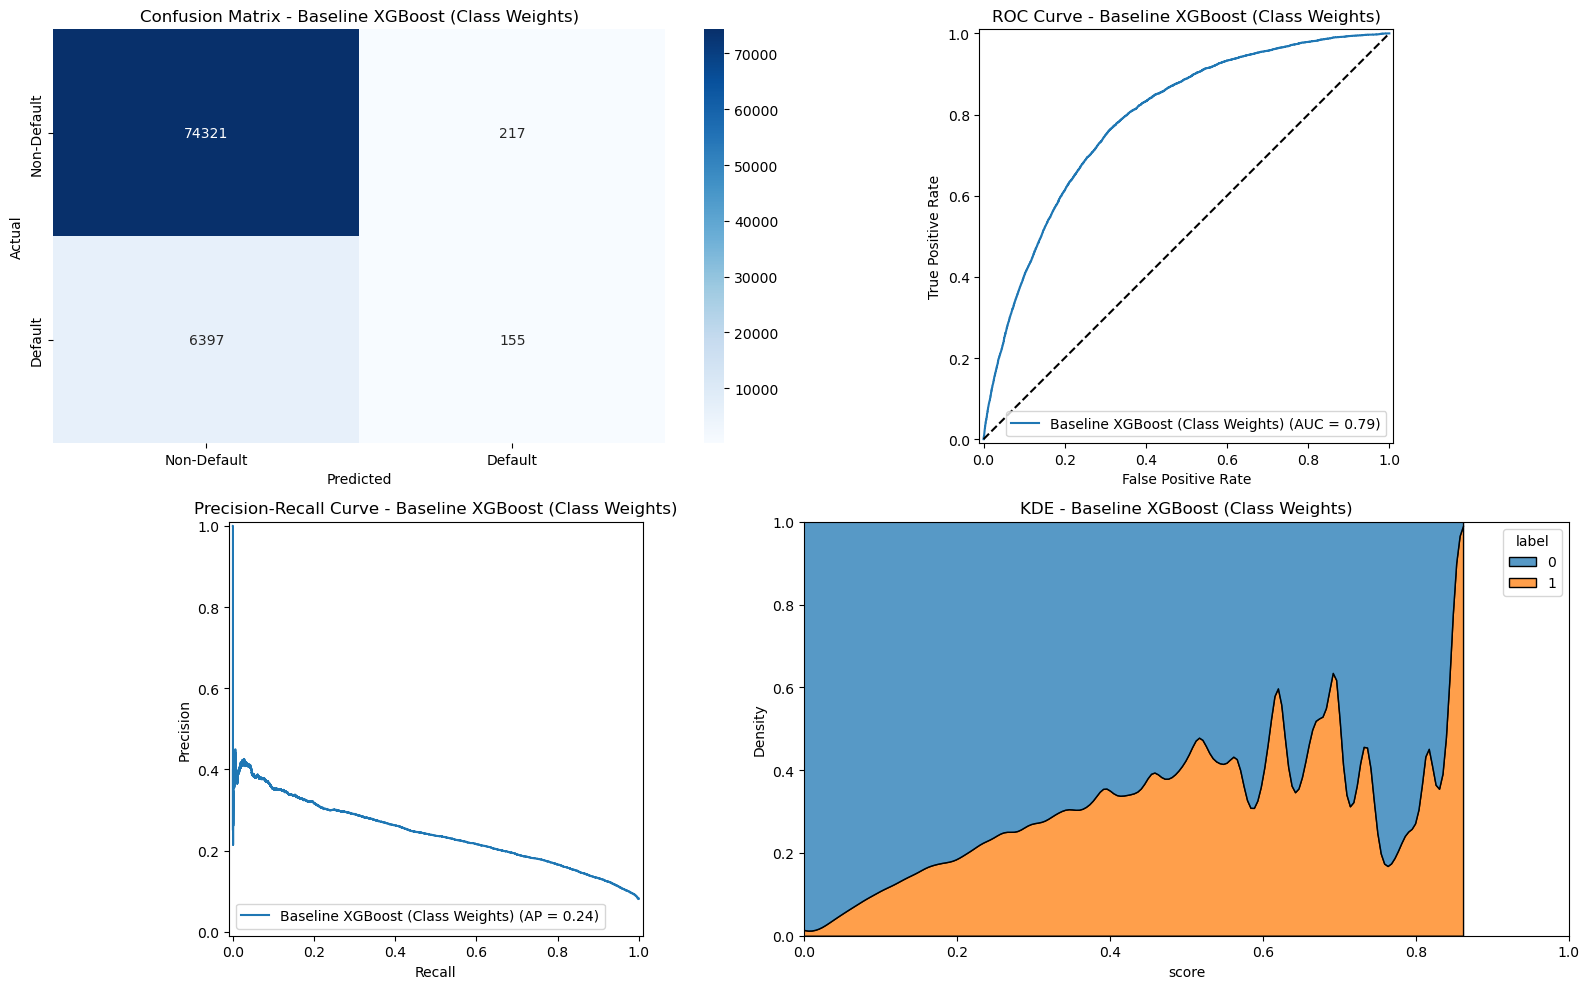

In [196]:
baseline_model_XGB.fit(X_train, y_train)
y_train_prob = baseline_model_XGB.predict_proba(X_train)
y_test_prob = baseline_model_XGB.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
baseline_results_XGB = evaluate_model(baseline_model_XGB, X_test, y_test, "Baseline XGBoost (Class Weights)")

In [197]:
# Predict train & test
y_train_pred = baseline_model_XGB.predict(X_train)
y_test_pred = baseline_model_XGB.predict(X_test)

y_train_prob = baseline_model_XGB.predict_proba(X_train)[:, 1]
y_test_prob = baseline_model_XGB.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.1192 | Test: 0.0448
ROC AUC Train: 0.8773 | Test: 0.7900


#### # Approach 2: Cost-sensitive learning with weighted XGBoost

In [198]:
from collections import Counter

In [199]:
xgb_weighted_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],  # Weight based on imbalance
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='aucpr'  # Use precision-recall AUC as metric
    ))
])

PSI for Prob score: 0.0001 - LOW

--- XGBoost (Weighted) Results ---
Accuracy: 0.7135
Balanced Accuracy: 0.7290
Precision: 0.1850
Recall/Sensitivity: 0.7476
F1 Score: 0.2966
Matthews Correlation Coefficient: 0.2662
ROC AUC: 0.7994
Gini: 0.5988
PR AUC: 0.2631


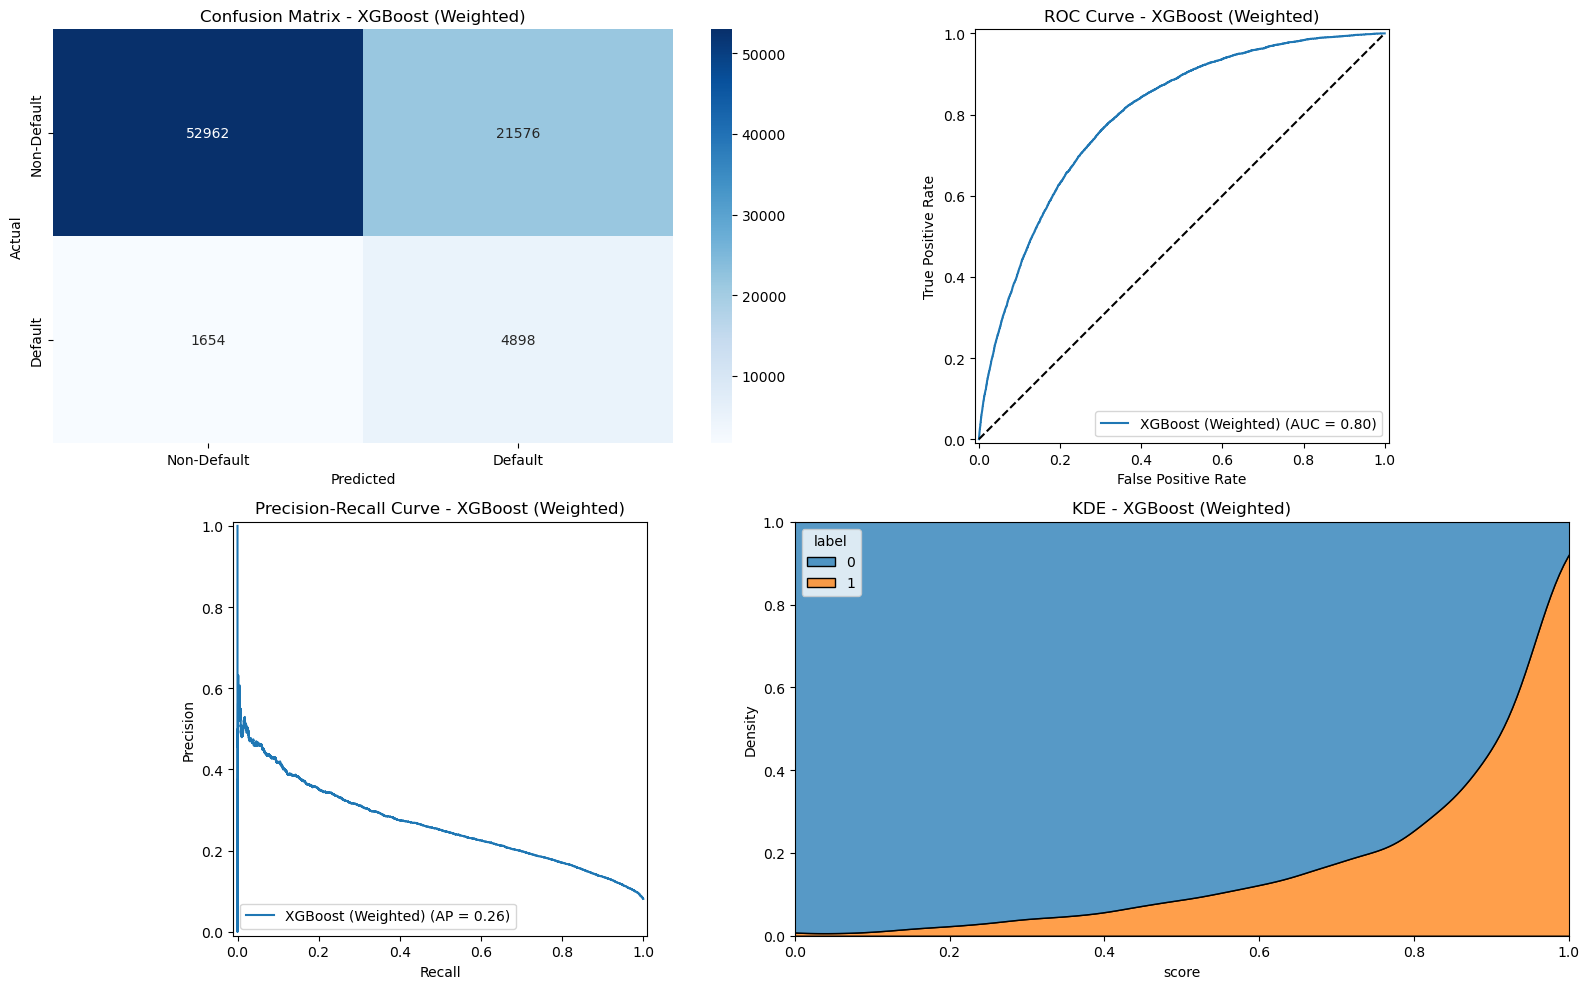

In [200]:
xgb_weighted_model.fit(X_train, y_train)
y_train_prob = xgb_weighted_model.predict_proba(X_train)
y_test_prob = xgb_weighted_model.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
xgb_weighted_model_results = evaluate_model(xgb_weighted_model, X_test, y_test, "XGBoost (Weighted)")

In [201]:
# Predict train & test
y_train_pred = xgb_weighted_model.predict(X_train)
y_test_pred = xgb_weighted_model.predict(X_test)

y_train_prob = xgb_weighted_model.predict_proba(X_train)[:, 1]
y_test_prob = xgb_weighted_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.3102 | Test: 0.2966
ROC AUC Train: 0.8231 | Test: 0.7994


#### # Approach 3: Undersampling with Balanced Random Forest

In [202]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [203]:
balanced_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', BalancedRandomForestClassifier(
        random_state=42,
        n_estimators=100,
        sampling_strategy='auto',  # Uses undersampling internally
        replacement=False,
        bootstrap=True
    ))
])

PSI for Prob score: 0.0294 - LOW

--- Balanced Random Forest Results ---
Accuracy: 0.7143
Balanced Accuracy: 0.7190
Precision: 0.1818
Recall/Sensitivity: 0.7245
F1 Score: 0.2907
Matthews Correlation Coefficient: 0.2555
ROC AUC: 0.7831
Gini: 0.5662
PR AUC: 0.2405


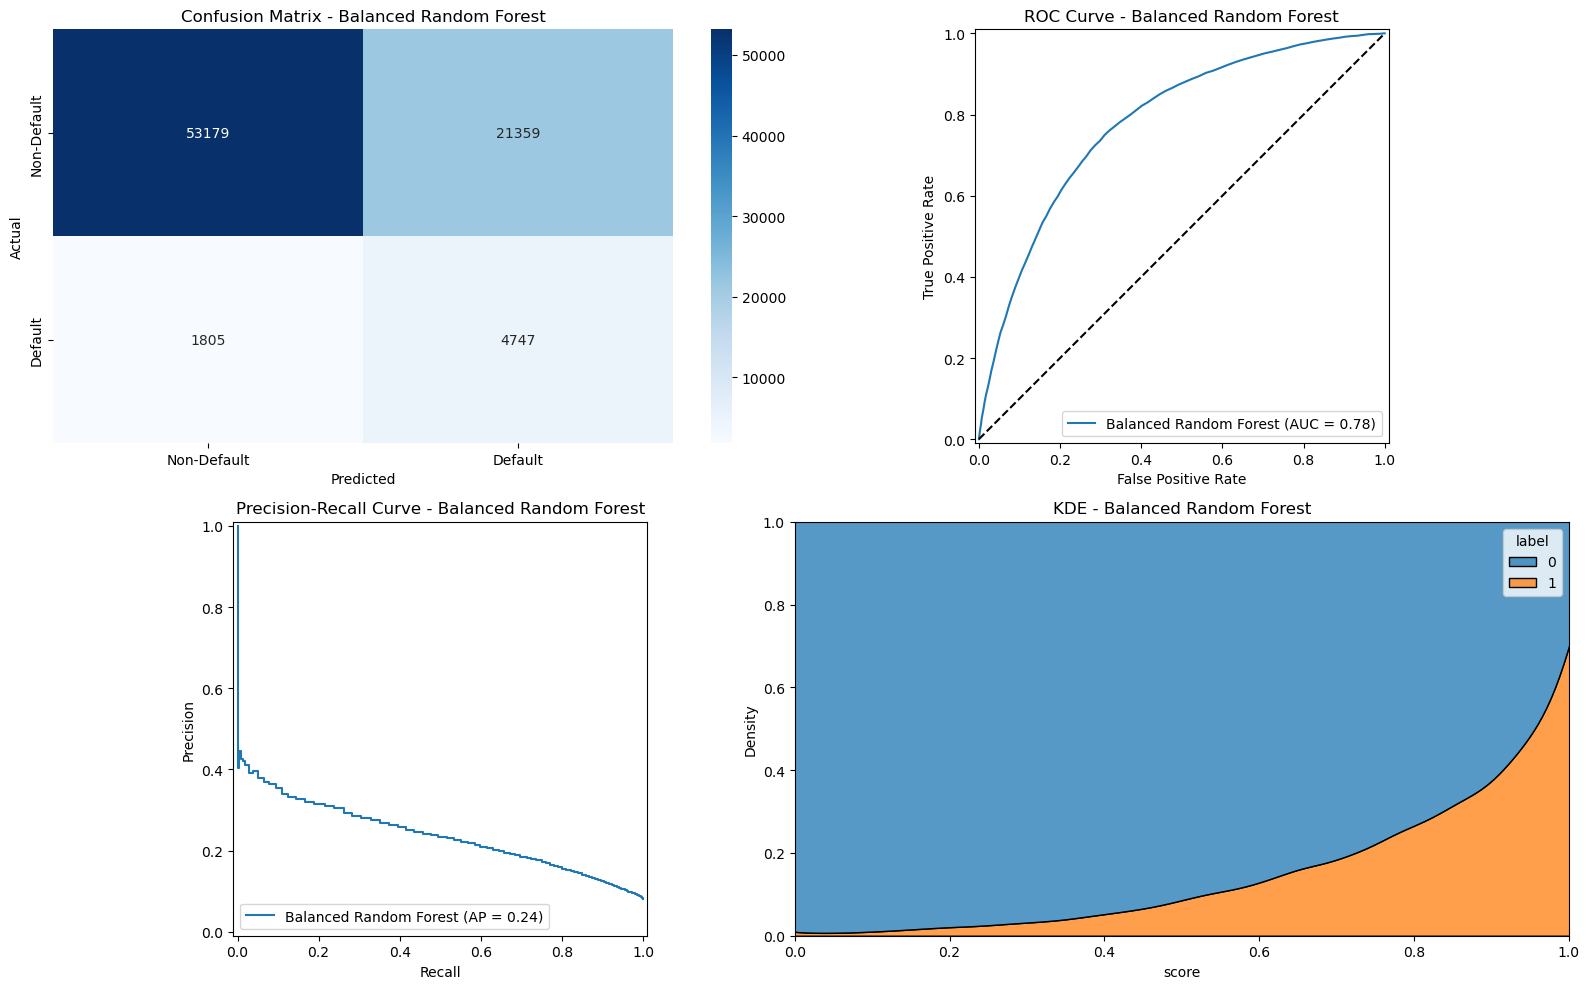

In [204]:
balanced_rf_model.fit(X_train, y_train)
y_train_prob = balanced_rf_model.predict_proba(X_train)
y_test_prob = balanced_rf_model.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
balanced_rf_model_results = evaluate_model(balanced_rf_model, X_test, y_test, "Balanced Random Forest")

In [205]:
# Predict train & test
y_train_pred = balanced_rf_model.predict(X_train)
y_test_pred = balanced_rf_model.predict(X_test)

y_train_prob = balanced_rf_model.predict_proba(X_train)[:, 1]
y_test_prob = balanced_rf_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.4072 | Test: 0.2907
ROC AUC Train: 0.9883 | Test: 0.7831


#### # Approach 4: Cost-sensitive XGBoost with focal loss

In [209]:
# Focal loss helps focus on hard examples and downweights easy ones
xgb_focal_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        random_state=42,
        scale_pos_weight=Counter(y_train)[0]/Counter(y_train)[1],
        max_depth=5,
        learning_rate=0.1,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='aucpr',
        gamma=2.0  # Focal loss parameter - focuses on hard examples
    ))
])

PSI for Prob score: 0.0001 - LOW

--- XGBoost with Focal Loss Results ---
Accuracy: 0.7134
Balanced Accuracy: 0.7290
Precision: 0.1849
Recall/Sensitivity: 0.7477
F1 Score: 0.2965
Matthews Correlation Coefficient: 0.2662
ROC AUC: 0.7992
Gini: 0.5984
PR AUC: 0.2624


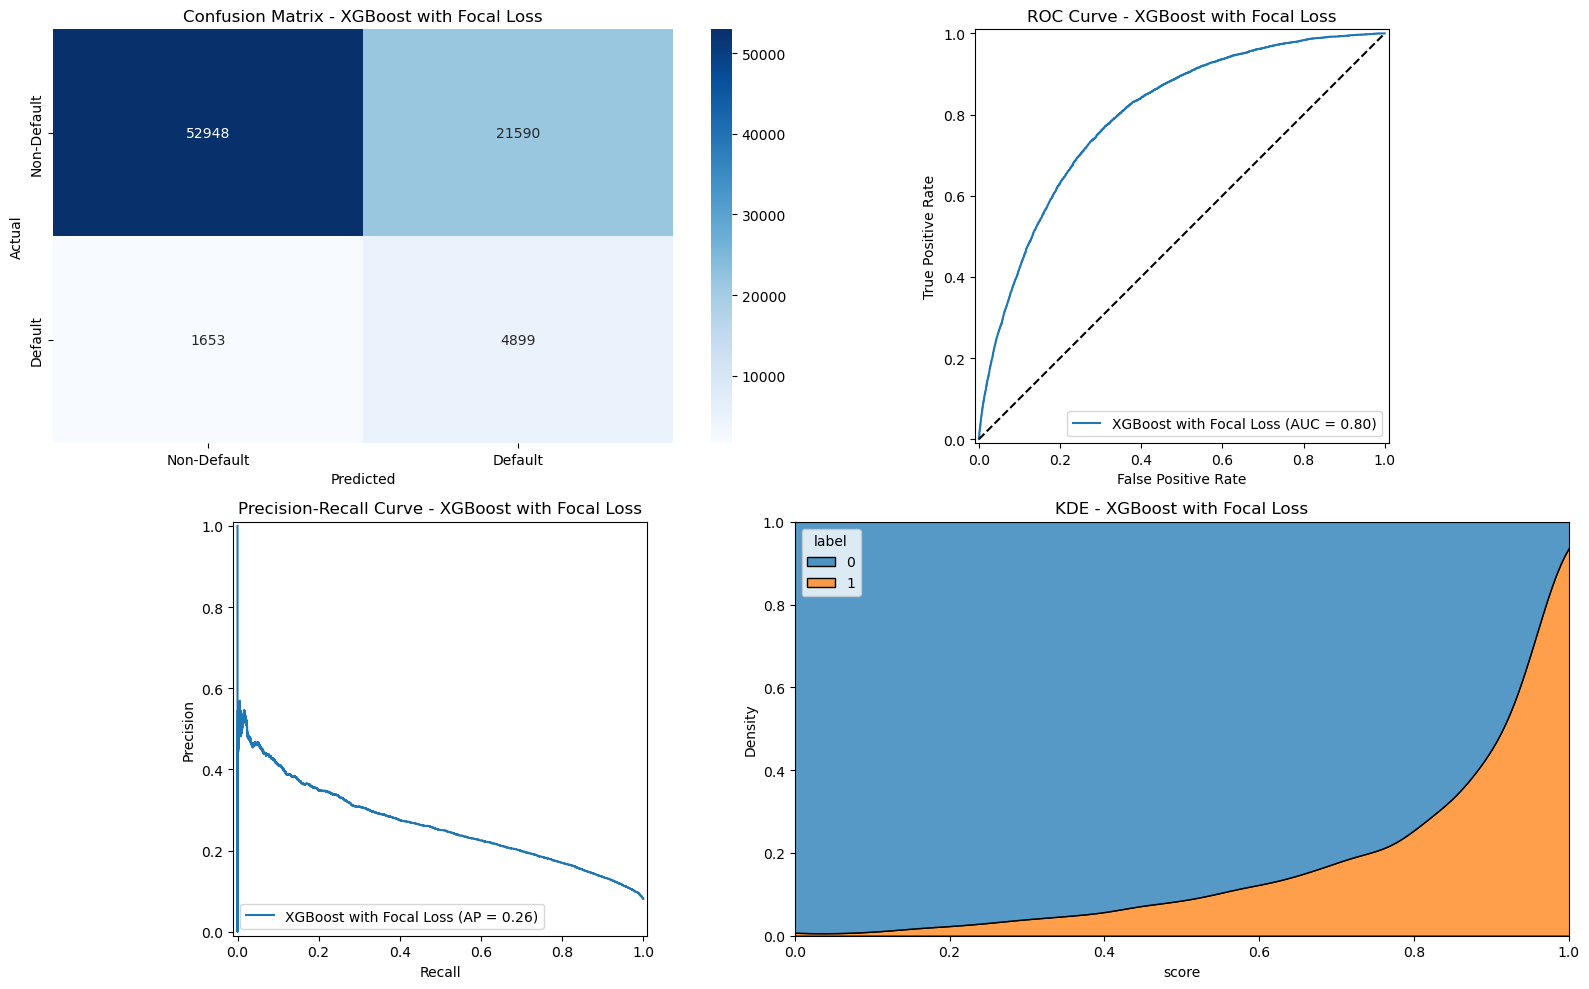

In [210]:
xgb_focal_model.fit(X_train, y_train)
y_train_prob = xgb_focal_model.predict_proba(X_train)
y_test_prob = xgb_focal_model.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
xgb_focal_model_results = evaluate_model(xgb_focal_model, X_test, y_test, "XGBoost with Focal Loss")

In [211]:
# Predict train & test
y_train_pred = xgb_focal_model.predict(X_train)
y_test_pred = xgb_focal_model.predict(X_test)

y_train_prob = xgb_focal_model.predict_proba(X_train)[:, 1]
y_test_prob = xgb_focal_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.3096 | Test: 0.2965
ROC AUC Train: 0.8228 | Test: 0.7992


#### # Approach 5: CatBoost with built-in handling for imbalanced data

In [212]:
from catboost import CatBoostClassifier

In [213]:
# Get categorical feature indices for CatBoost
cat_features = []
for i, col in enumerate(X_train.columns):
    if col in cat_cols:
        cat_features.append(i)

In [214]:
catboost_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(
        random_state=42,
        auto_class_weights='Balanced',  # Automatic class weighting
        loss_function='Logloss',
        eval_metric='AUC',
        iterations=100,
        depth=6,
        learning_rate=0.1,
        verbose=False
    ))
])

PSI for Prob score: 0.0003 - LOW

--- CatBoost Results ---
Accuracy: 0.7090
Balanced Accuracy: 0.7306
Precision: 0.1839
Recall/Sensitivity: 0.7564
F1 Score: 0.2958
Matthews Correlation Coefficient: 0.2669
ROC AUC: 0.7993
Gini: 0.5985
PR AUC: 0.2641


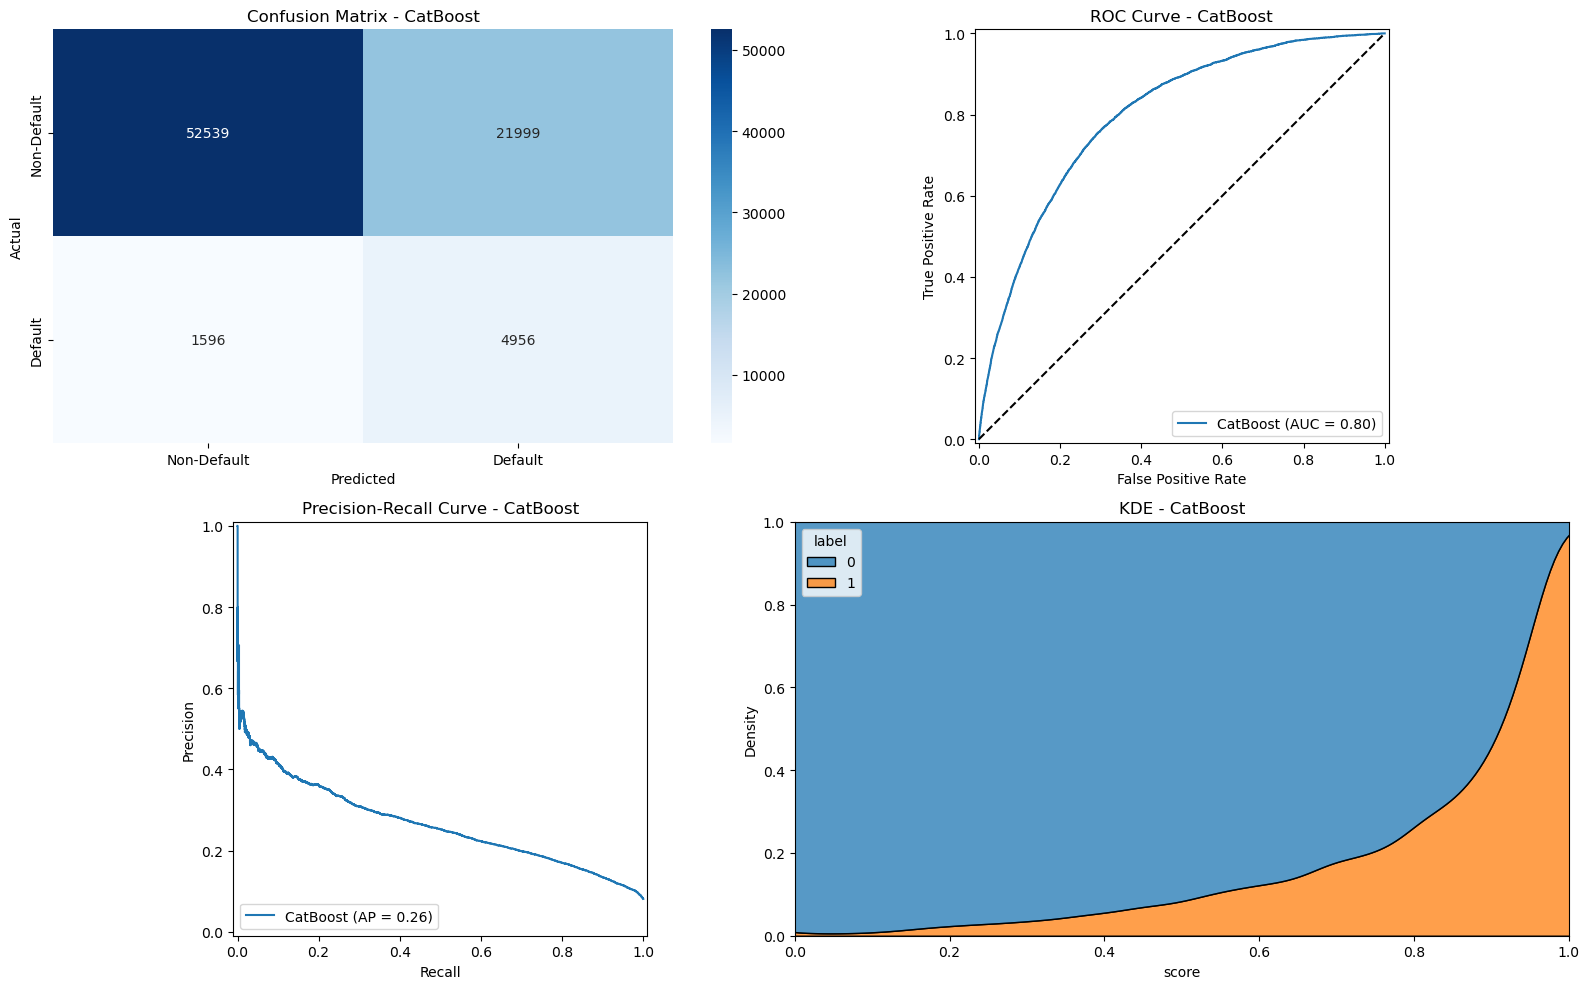

In [215]:
catboost_model.fit(X_train, y_train)
y_train_prob = catboost_model.predict_proba(X_train)
y_test_prob = catboost_model.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
catboost_model_results = evaluate_model(catboost_model, X_test, y_test, "CatBoost")

In [74]:
# Predict train & test
y_train_pred = catboost_model.predict(X_train)
y_test_pred = catboost_model.predict(X_test)

y_train_prob = catboost_model.predict_proba(X_train)[:, 1]
y_test_prob = catboost_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.2971 | Test: 0.2916
ROC AUC Train: 0.8181 | Test: 0.8087


#### # Approach 6: LightGBM with built-in imbalance handling

In [216]:
import lightgbm as lgb

In [217]:
lgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(
        random_state=42,
        is_unbalance=True,  # Built-in handling for imbalanced data
        class_weight={0: 1, 1: Counter(y_train)[0]/Counter(y_train)[1]},  # Class weighting
        objective='binary',
        metric='auc',
        boost_from_average=False,  # Important for imbalanced data
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.1
    ))
])

In [218]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 15287, number of negative: 173922
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2656
[LightGBM] [Info] Number of data points in the train set: 189209, number of used features: 47


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['emp_length', 'avg_cur_bal',
                                                   'Tot_cur_bal', 'loan_amount',
                                                   'int_rate', 'installment',
                                                   'issue_month',
                                                   'issue_quarter',
                                                   'issue_year_num',
                                                   'total_inc', 'dti', 'lti',
                                                   'interest_burden',
                                                   'bal_to_loan']),
                                                 ('...
                                                   'term', 'purpose',
                                                   'grade_term']),
                                                 ('ord_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'E',
                                                                                               'F',
                                                                                               'G']]))]),
                                                  ['grade'])])),
                ('classifier',
                 LGBMClassifier(boost_from_average=False,
                                class_weight={0: 1, 1: 11.377117812520442},
                                is_unbalance=True, metric='auc',
                                objective='binary', random_state=42))])

PSI for Prob score: 0.0002 - LOW

--- LightGBM (Imbalance-Aware) Results ---
Accuracy: 0.2907
Balanced Accuracy: 0.6020
Precision: 0.1001
Recall/Sensitivity: 0.9733
F1 Score: 0.1815
Matthews Correlation Coefficient: 0.1355
ROC AUC: 0.7925
Gini: 0.5850
PR AUC: 0.2583


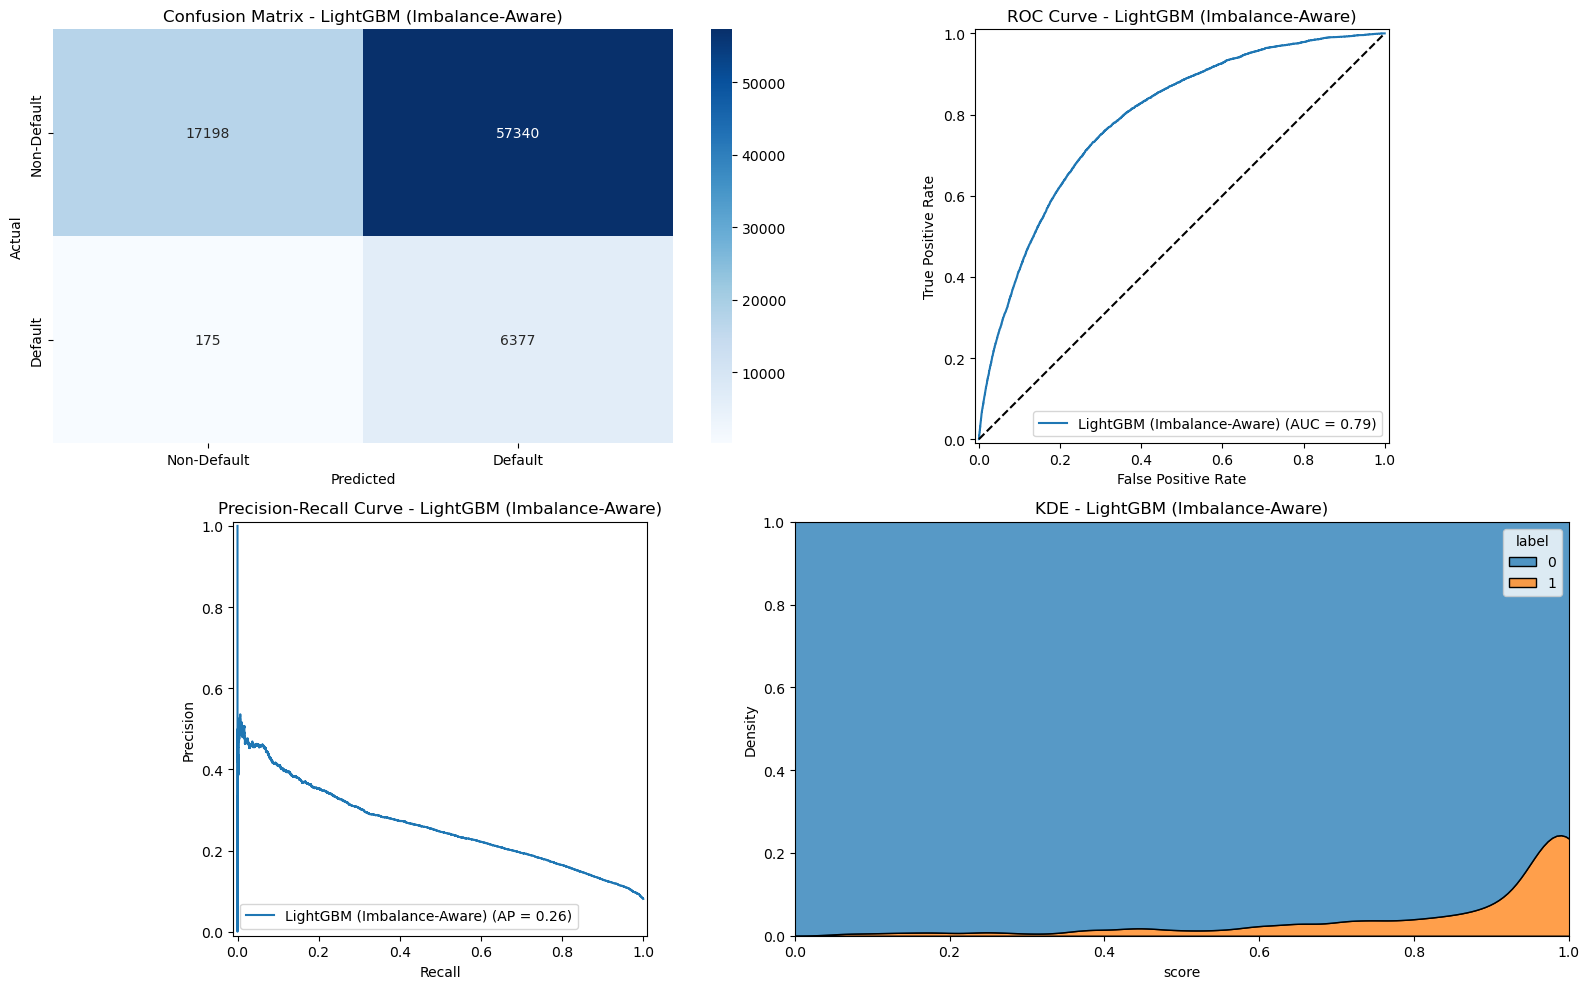

In [219]:
y_train_prob = lgb_model.predict_proba(X_train)
y_test_prob = lgb_model.predict_proba(X_test)
print_psi('Prob score', calculate_psi(y_train_prob, y_test_prob))
lgb_model_results = evaluate_model(lgb_model, X_test, y_test, "LightGBM (Imbalance-Aware)")

In [220]:
# Predict train & test
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

y_train_prob = lgb_model.predict_proba(X_train)[:, 1]
y_test_prob = lgb_model.predict_proba(X_test)[:, 1]

# F1
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

# ROC AUC
roc_train = roc_auc_score(y_train, y_train_prob)
roc_test = roc_auc_score(y_test, y_test_prob)

print(f"F1 Train: {f1_train:.4f} | Test: {f1_test:.4f}")
print(f"ROC AUC Train: {roc_train:.4f} | Test: {roc_test:.4f}")

F1 Train: 0.1868 | Test: 0.1815
ROC AUC Train: 0.8309 | Test: 0.7925


#### # Compare all models

In [221]:
all_results = [baseline_results_logistic, baseline_results_RF, baseline_results_XGB, xgb_weighted_model_results, balanced_rf_model_results, xgb_focal_model_results, lgb_model_results, catboost_model_results]

results_df = pd.DataFrame(all_results)
results_df = results_df.set_index('model')

<Figure size 1400x800 with 0 Axes>

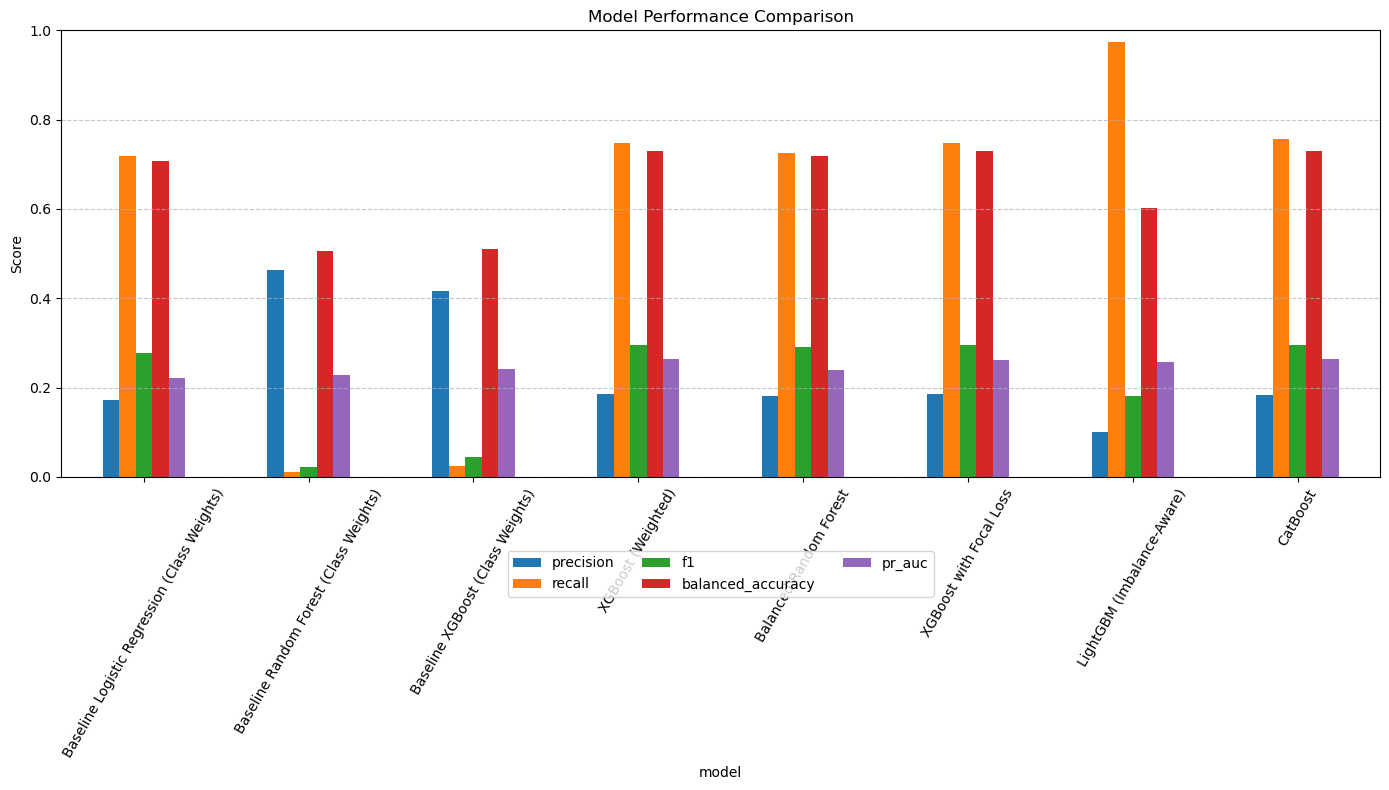

In [222]:
# Plot comparison of key metrics
plt.figure(figsize=(14, 8))
metrics_to_plot = ['precision', 'recall', 'f1', 'balanced_accuracy', 'pr_auc']
results_df[metrics_to_plot].plot(kind='bar', figsize=(14, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=60)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.show()

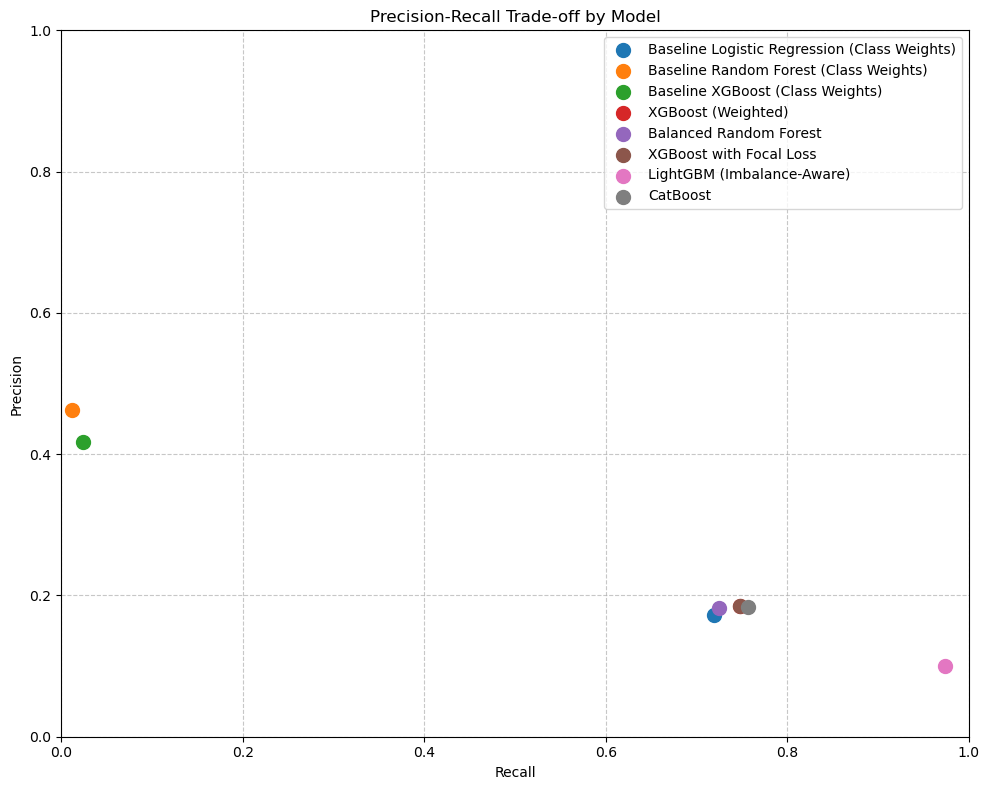

In [223]:
# Additional analysis: Precision-Recall trade-off visualization 
# This is especially important for imbalanced classification
plt.figure(figsize=(10, 8))
for idx, (model_name, row) in enumerate(results_df.iterrows()):
    plt.scatter(row['recall'], row['precision'], s=100, label=model_name)
    
plt.title('Precision-Recall Trade-off by Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [224]:
# Print the final table for easy comparison
pd.set_option('display.width', 1000)
print("\n--- Final Model Comparison ---")
print(results_df[['precision', 'recall', 'f1', 'balanced_accuracy', 'pr_auc']])


--- Final Model Comparison ---
                                              precision    recall        f1  balanced_accuracy    pr_auc
model                                                                                                   
Baseline Logistic Regression (Class Weights)   0.171740  0.719017  0.277256           0.707103  0.222461
Baseline Random Forest (Class Weights)         0.462500  0.011294  0.022050           0.505070  0.229405
Baseline XGBoost (Class Weights)               0.416667  0.023657  0.044772           0.510373  0.241481
XGBoost (Weighted)                             0.185012  0.747558  0.296615           0.729047  0.263071
Balanced Random Forest                         0.181836  0.724512  0.290710           0.718980  0.240476
XGBoost with Focal Loss                        0.184945  0.747711  0.296541           0.729030  0.262403
LightGBM (Imbalance-Aware)                     0.100083  0.973291  0.181503           0.602009  0.258295
CatBoost               

Based on the metrics, the XGBoost (Weighted), XGBoost with Focal Loss, and CatBoost models appear to be the strongest performers. They offer a good balance of high recall and reasonable precision, resulting in strong balanced accuracy and PR AUC scores.

Considering the goals of credit default prediction (maximizing the identification of defaults while maintaining a reasonable level of incorrect classifications), CatBoost seem to be the top contender due to it combination of high recall and competitive balanced accuracy/PR AUC.

## 6. Export Model

In [225]:
import joblib

In [227]:
joblib.dump(catboost_model, 'model_catboost.pkl')

['model_catboost.pkl']

In [ ]:
# Dowload Model
#files.download('model_randomforest.pkl')